In [1]:
cd ../src

C:\Users\Sam\smore\src


In [2]:
%load_ext autoreload
%autoreload 2

In [23]:
from pathlib import Path
import nibabel as nib
import numpy as np
from utils.plot import *
from utils.resize import resize
from utils.rotate import rotate_vol_2D
from utils.degrade import *
from utils.patch_ops import *
from utils.augmentations import *

# 1. Load data into RAM

In [4]:
fpath = Path("../SUPERRES-ADNIPHANTOM_20200711_PHANTOM-T2-TSE-2D-CORONAL-PRE-ACQ1-04mm_resampled.nii")
obj = nib.load(fpath)
header = obj.header
img = obj.get_fdata(dtype=np.float32)

# 2. Orient s.t. z is the LR axis

In [5]:
img.shape

(256, 256, 45)

# 3. Get the scale factor

In [6]:
k = max(header.get_zooms()) / min(header.get_zooms())

In [7]:
k

4.0

In [51]:
# If we assume the blur FWHM and sample factor are the same...
blur_k = k

# 4. Upsample to correct grid size with b-spline interpolation

In [8]:
dxyz = [1, 1, 1/k]
img = resize(img, dxyz, order=3)

In [9]:
img.shape

(256, 256, 180)

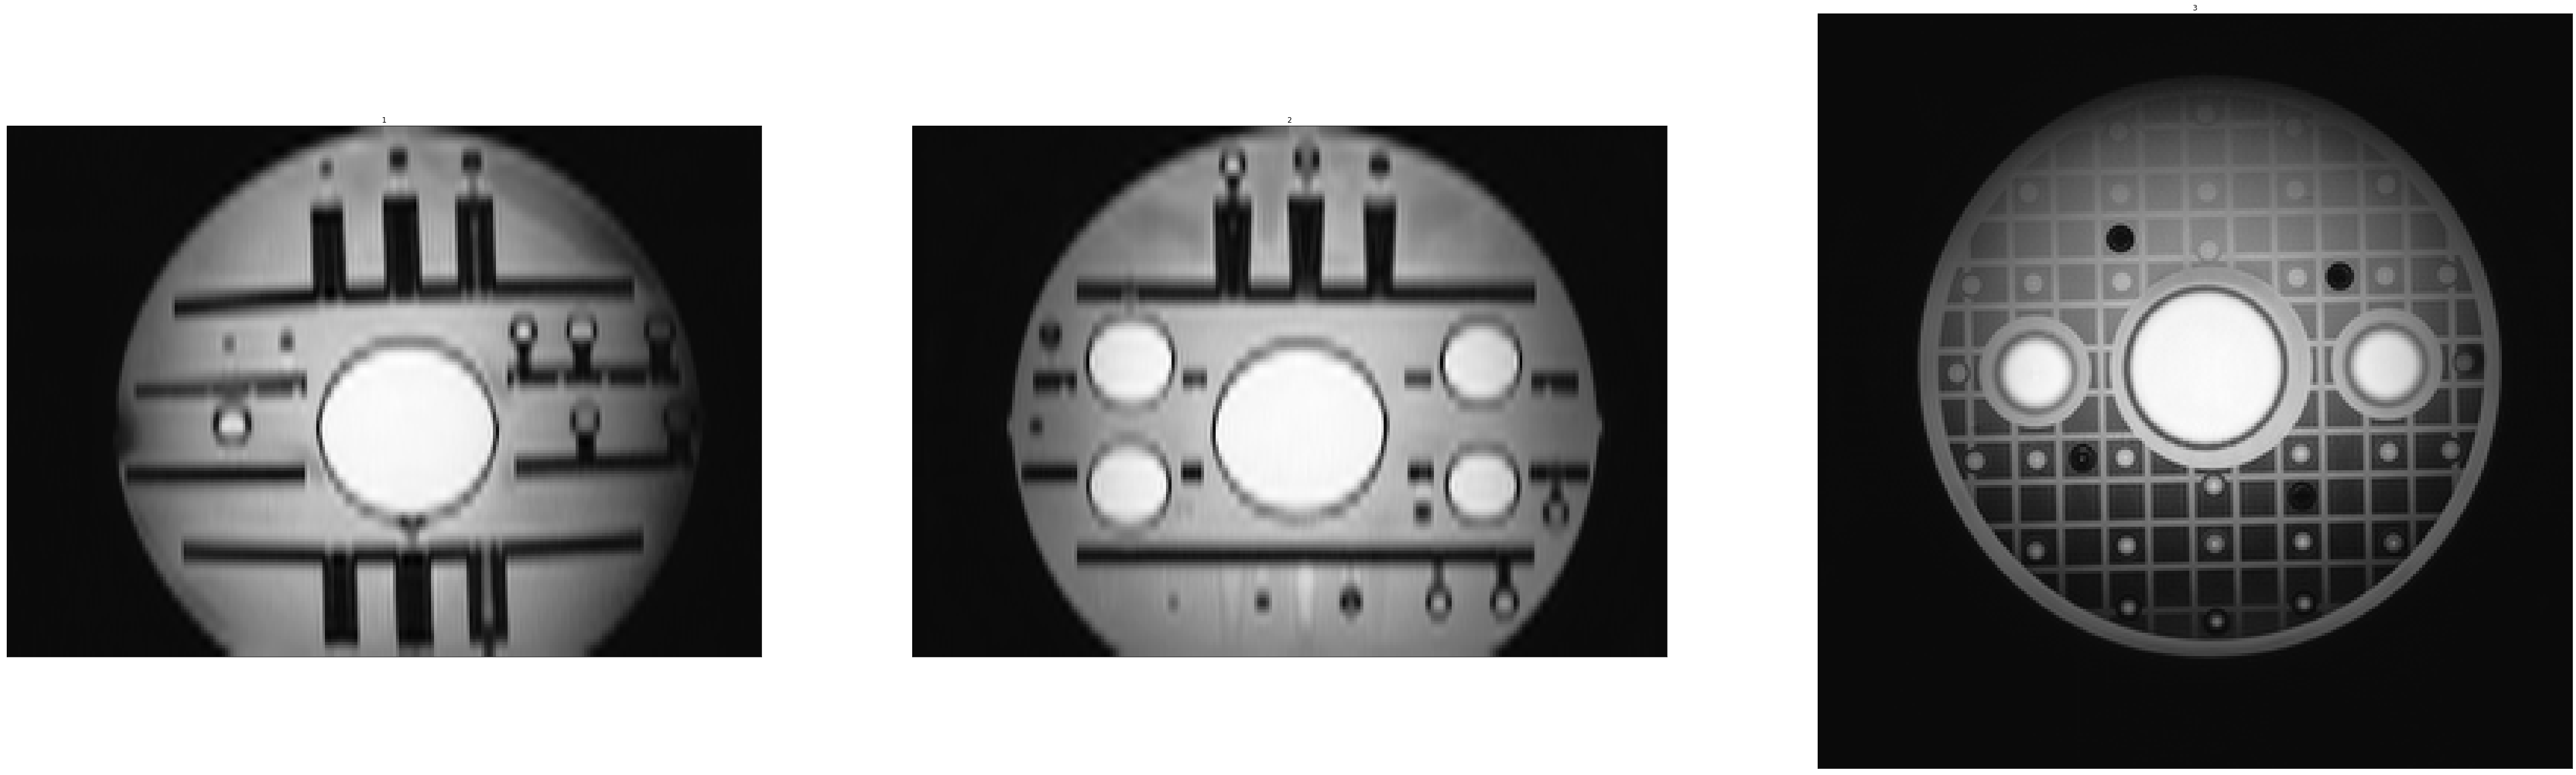

In [10]:
center_vol_plot(img)

# 5. Create rotations

In [11]:
min_angle = 0
max_angle = 90
n_rots = 2
angles = list(range(min_angle, max_angle+1, max_angle//n_rots))

In [12]:
imgs_rot = [rotate_vol_2D(img, angle) for angle in angles]

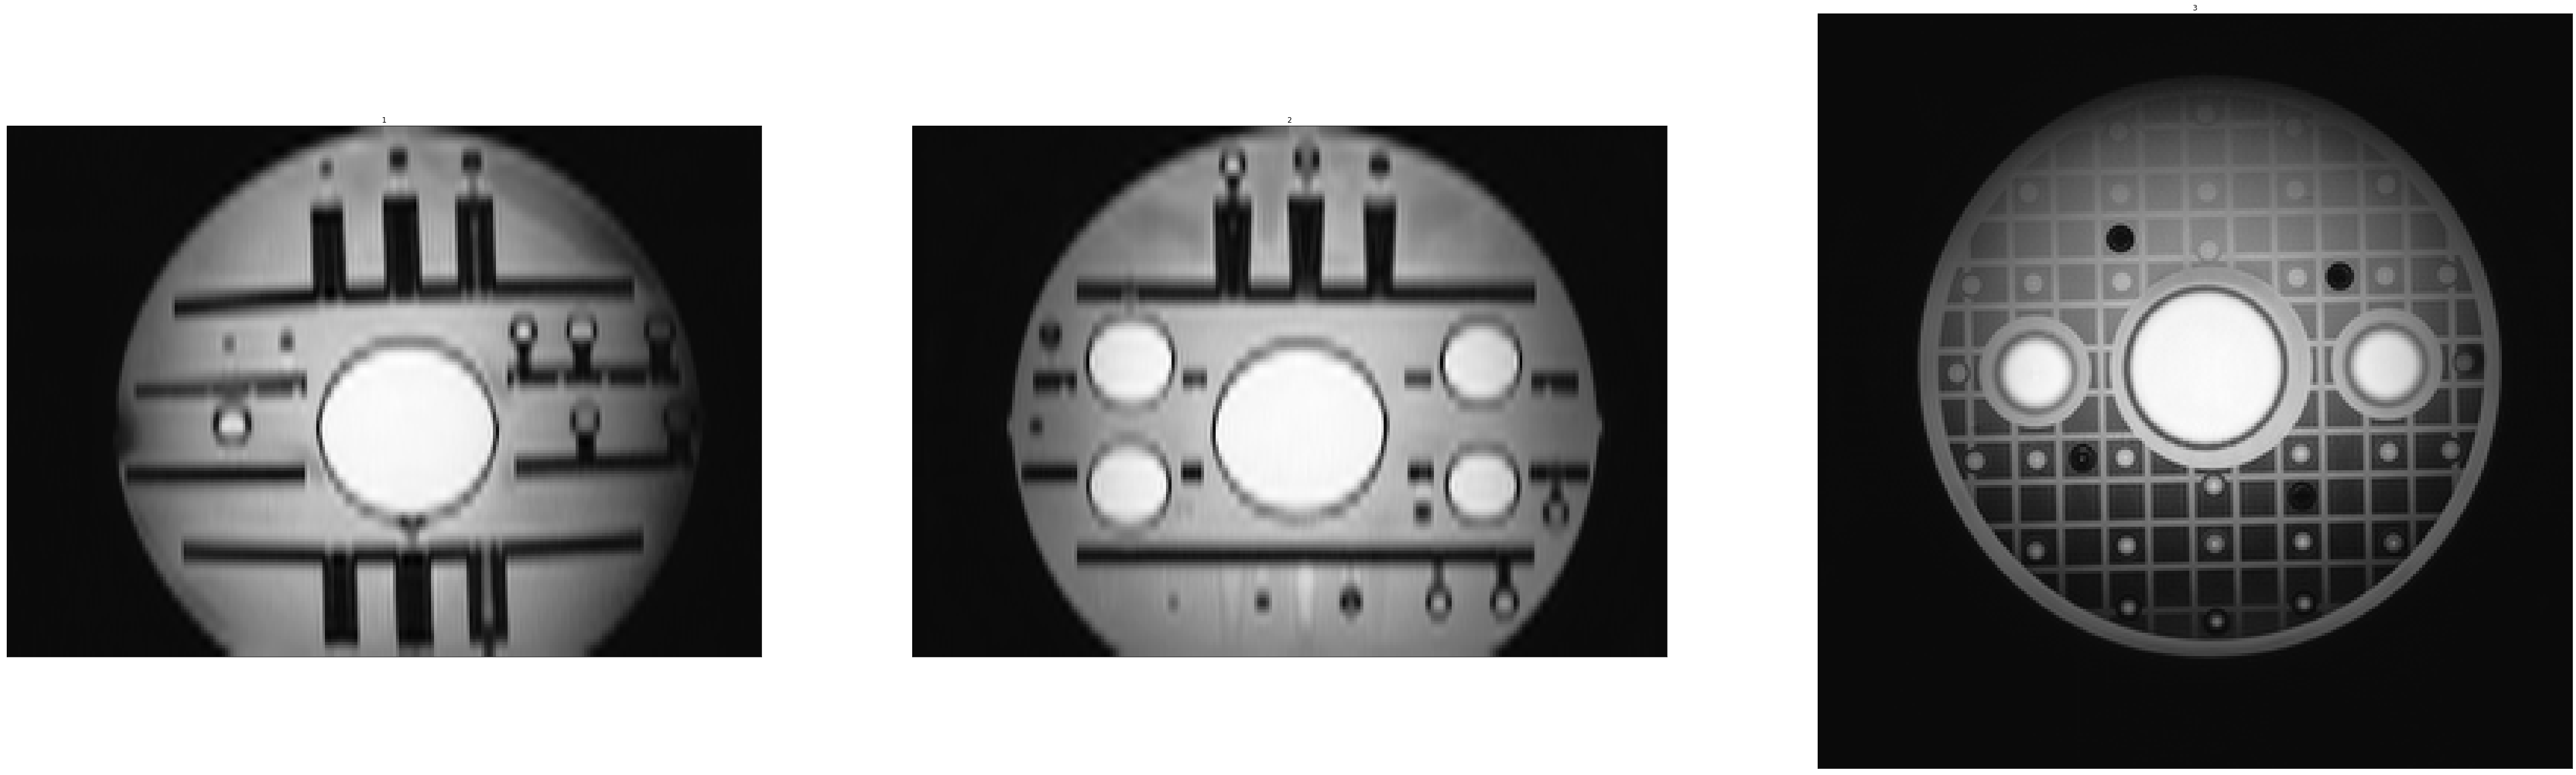

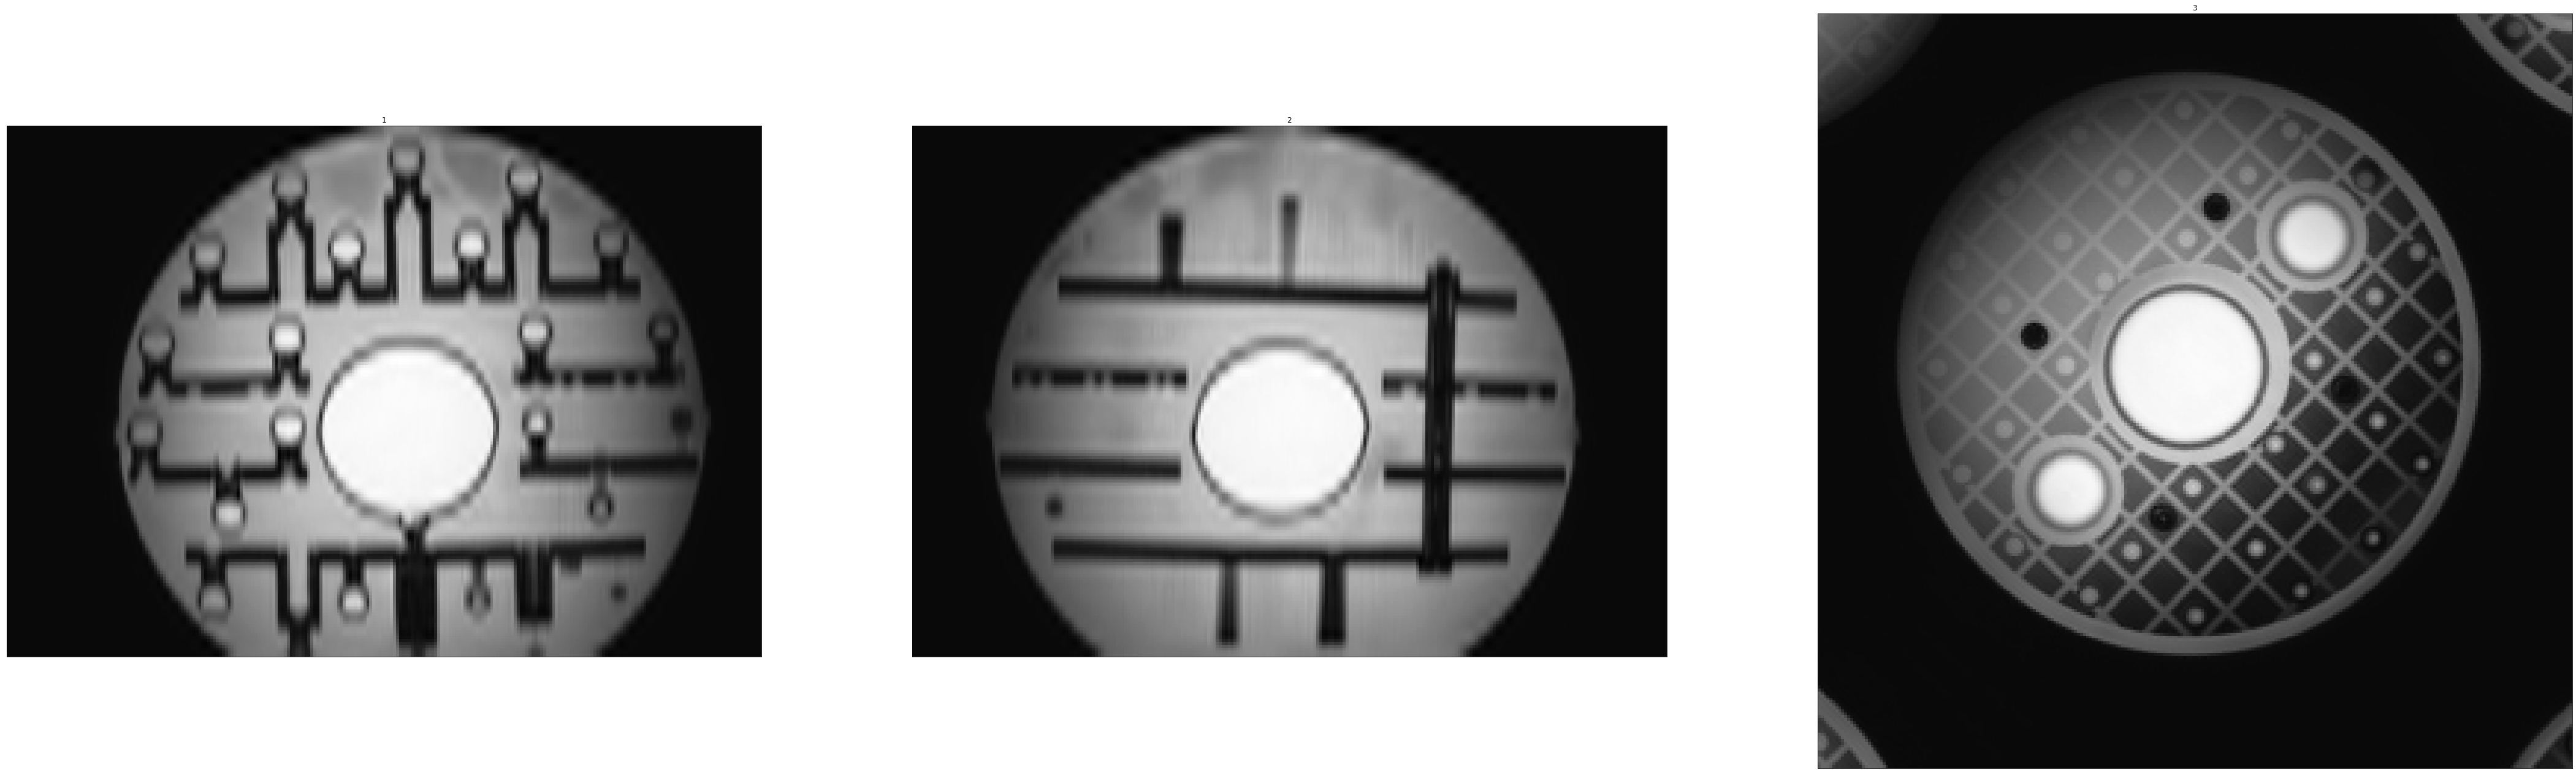

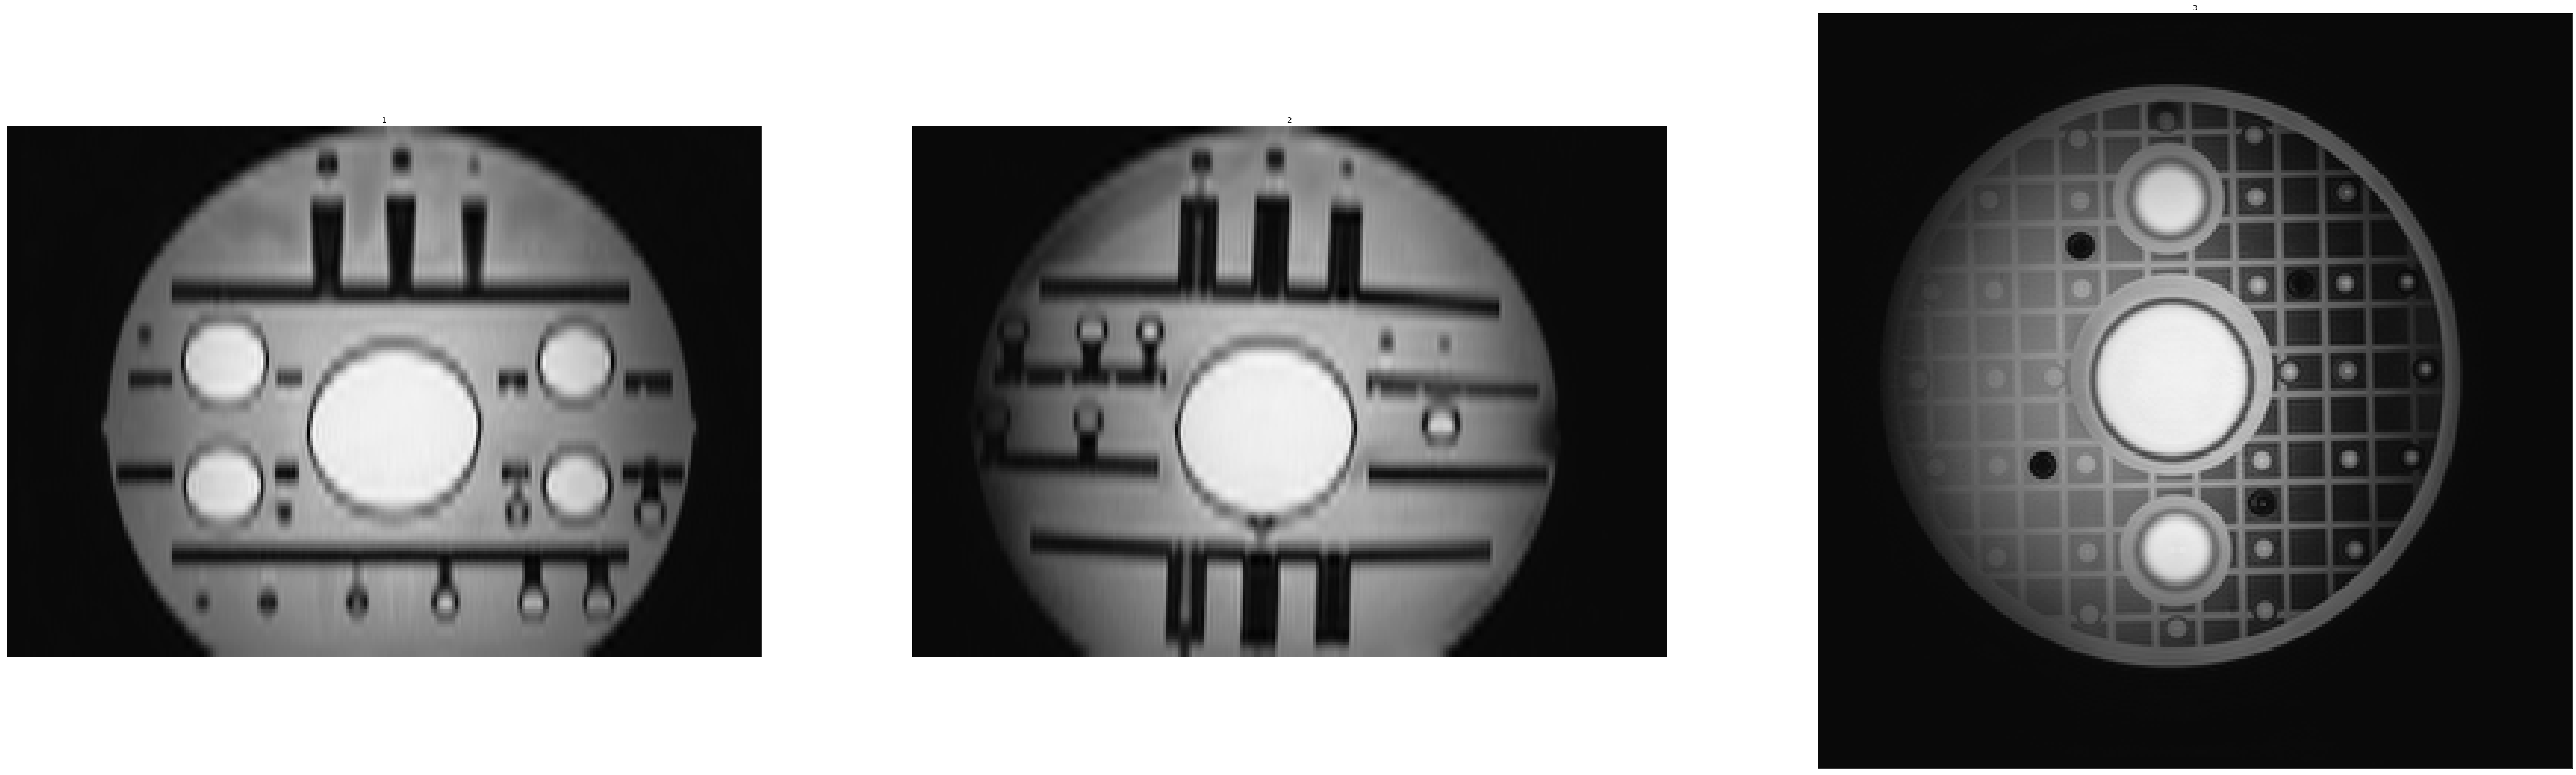

In [13]:
for img_rot in imgs_rot:
    center_vol_plot(img_rot)

# 6. Blur in-plane in 1D,  x-direction

In [14]:
imgs_blur = [blur(img_rot, blur_k, axis=0) for img_rot in imgs_rot]

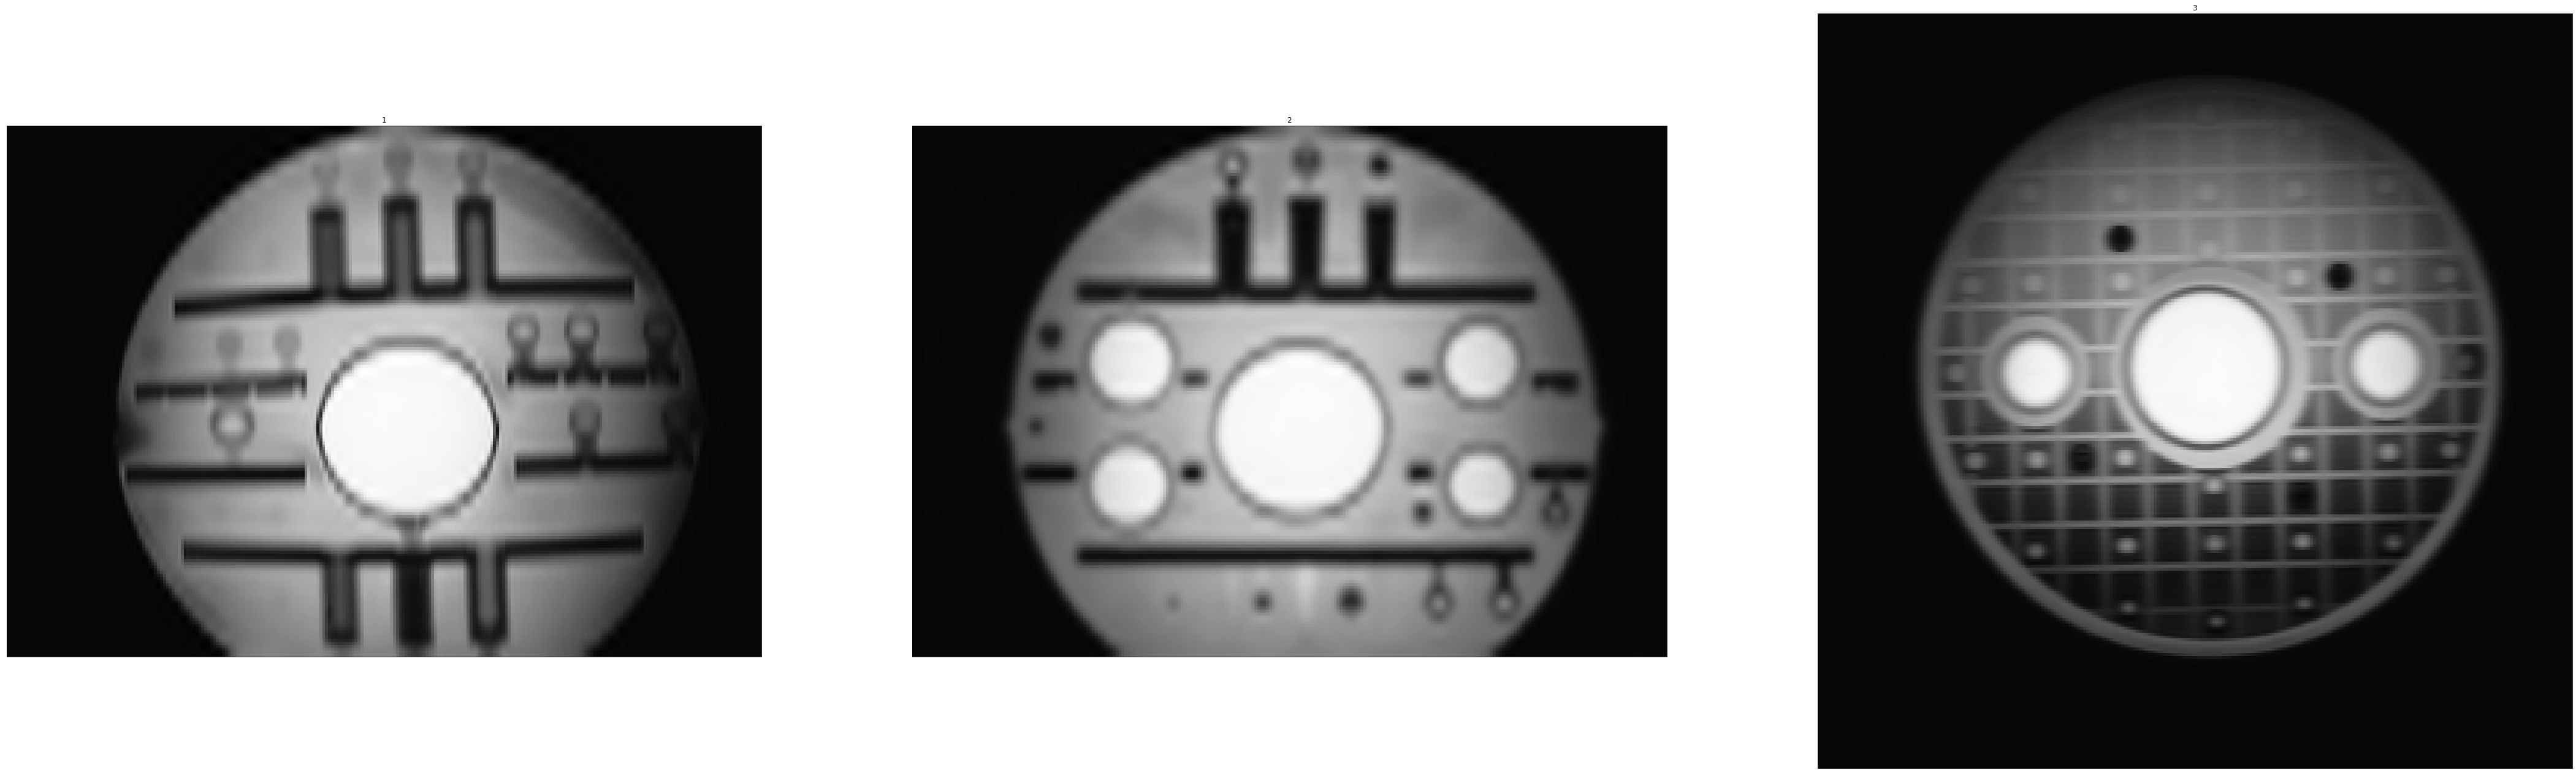

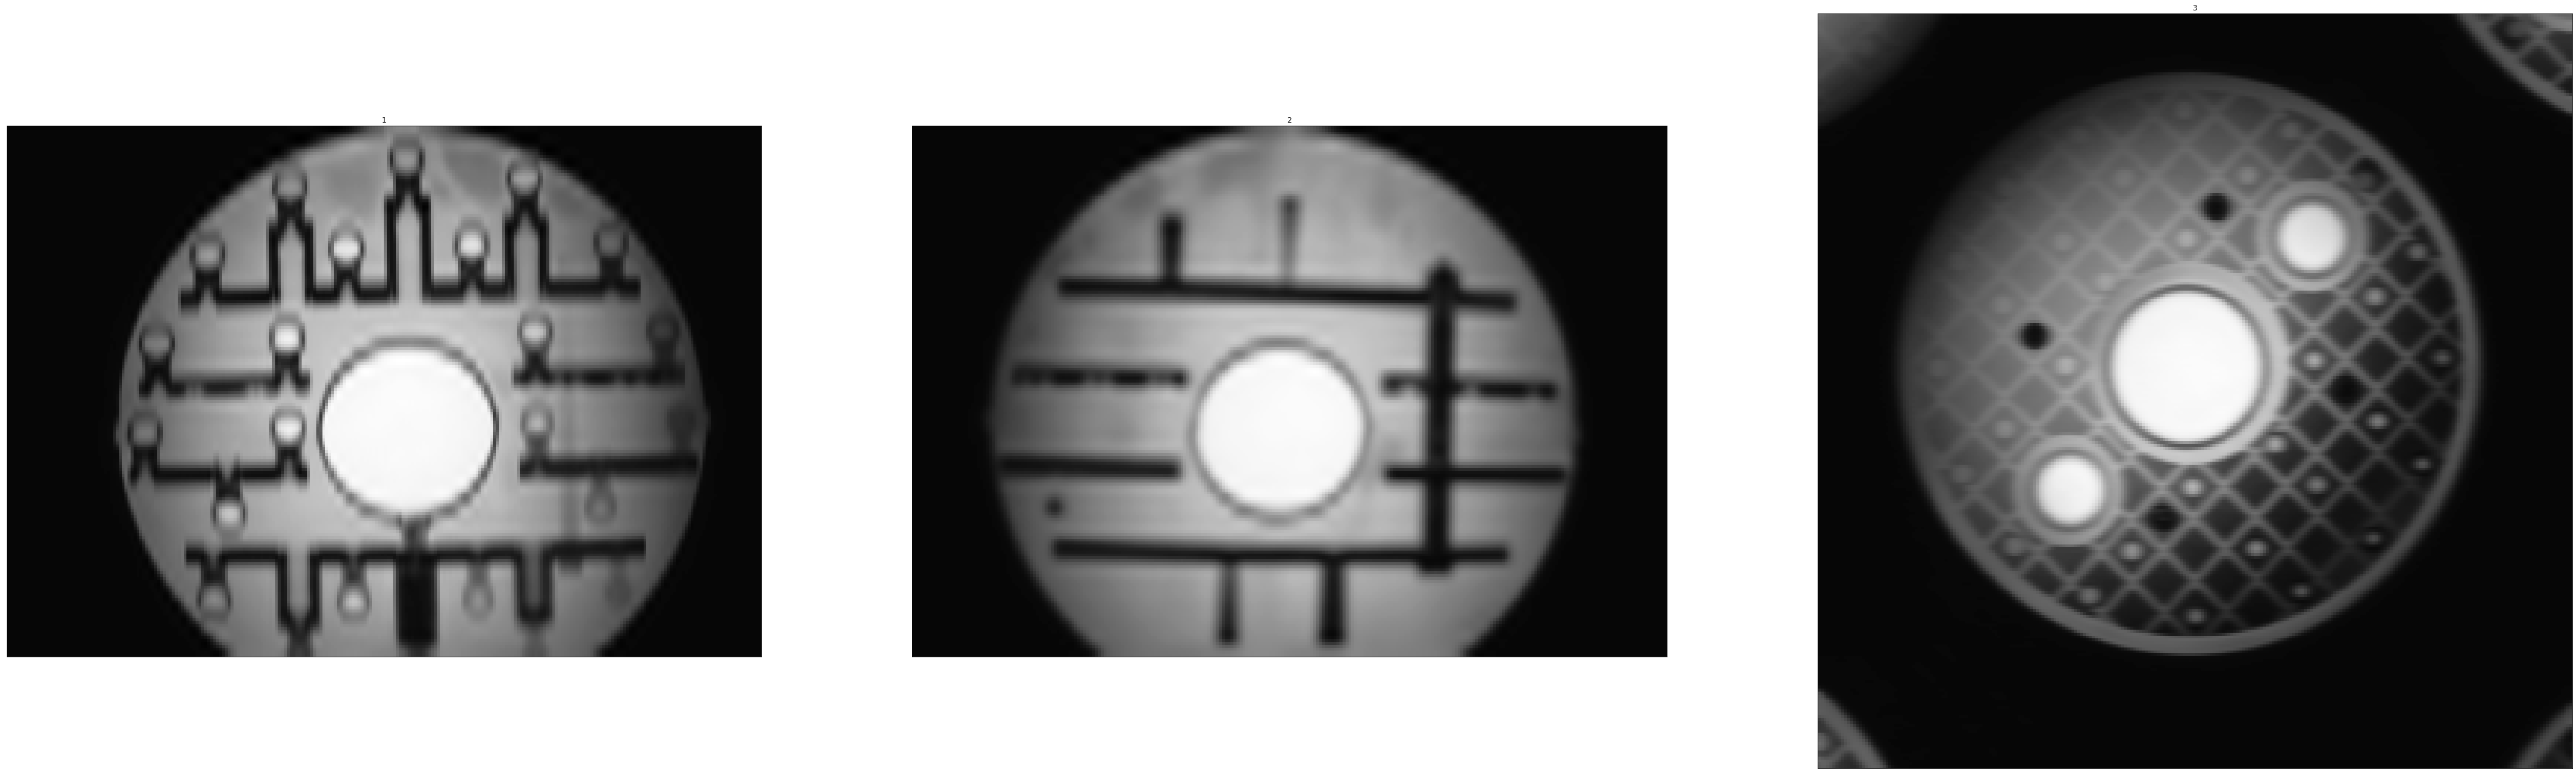

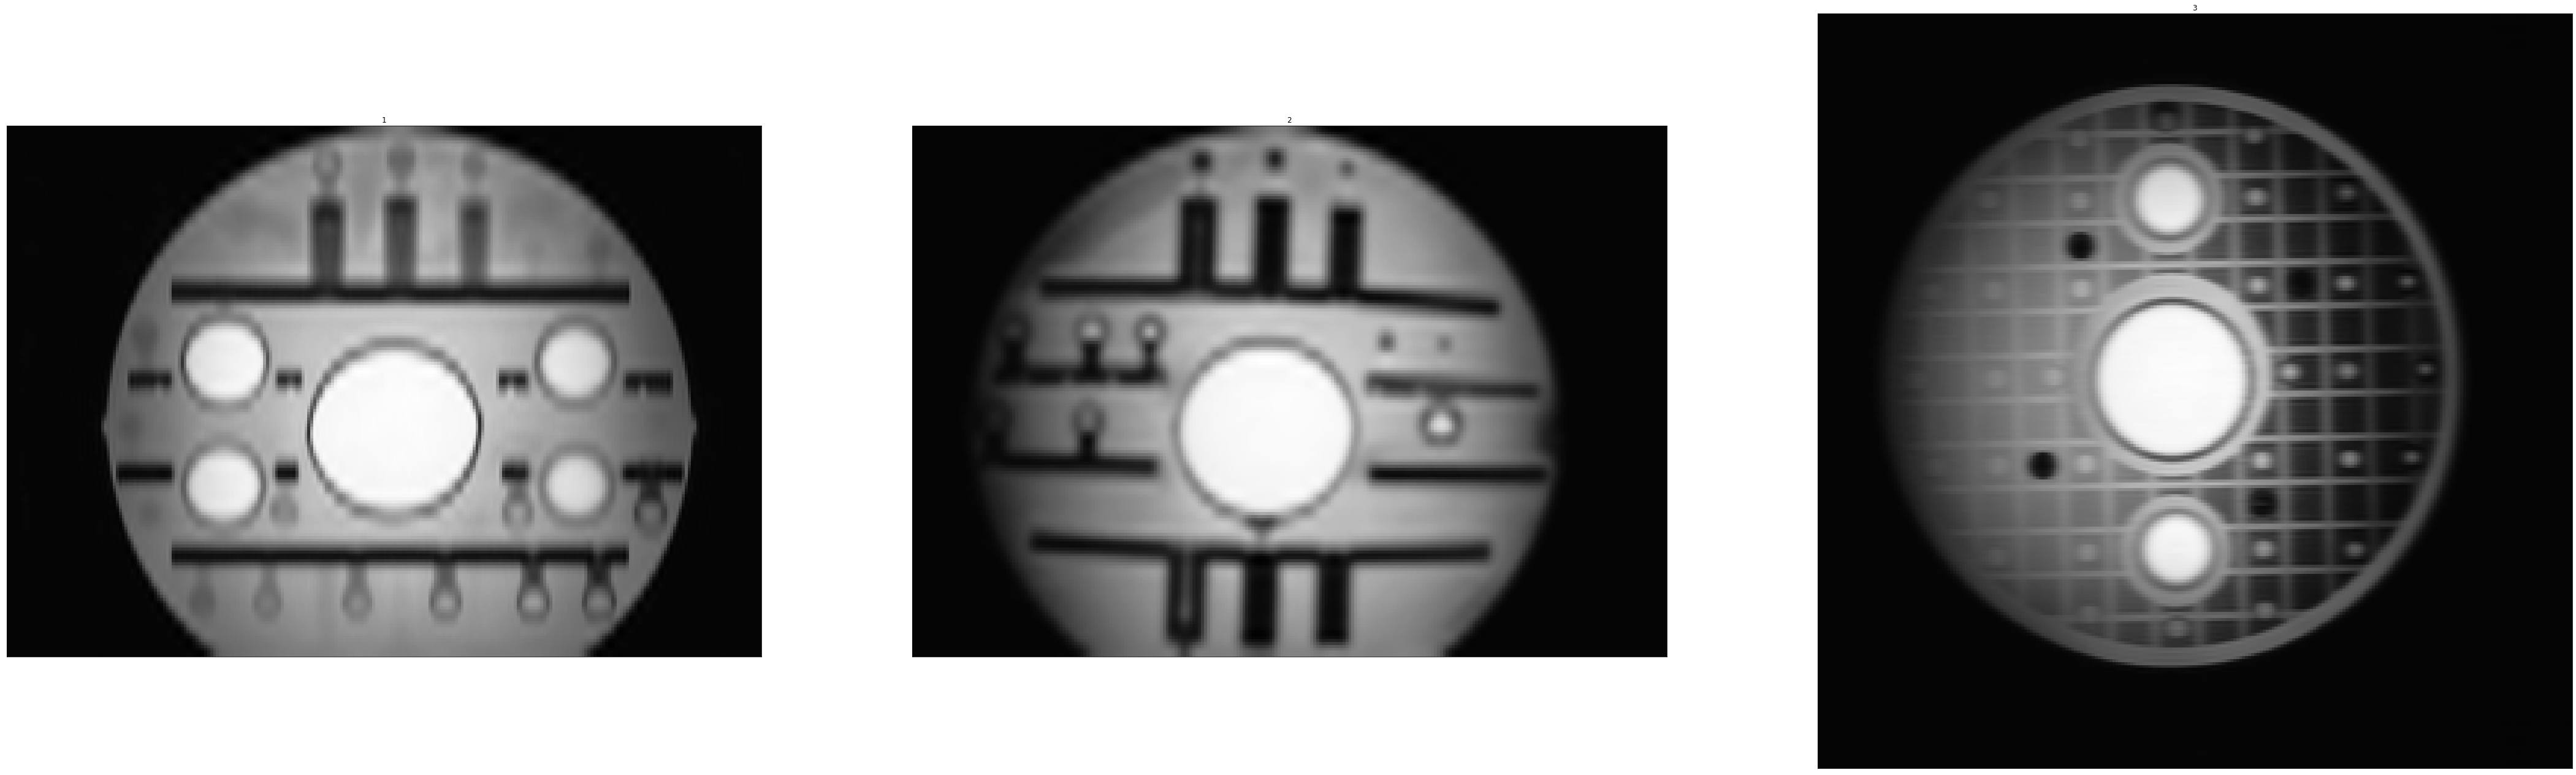

In [15]:
for img_blur in imgs_blur:
    center_vol_plot(img_blur)

# 7. Downsample in-plane in 1D, x-direction

In [16]:
dxyz_down = (k, 1.0, 1.0)
imgs_ds = [resize(img_blur, dxyz_down, order=1) for img_blur in imgs_blur]

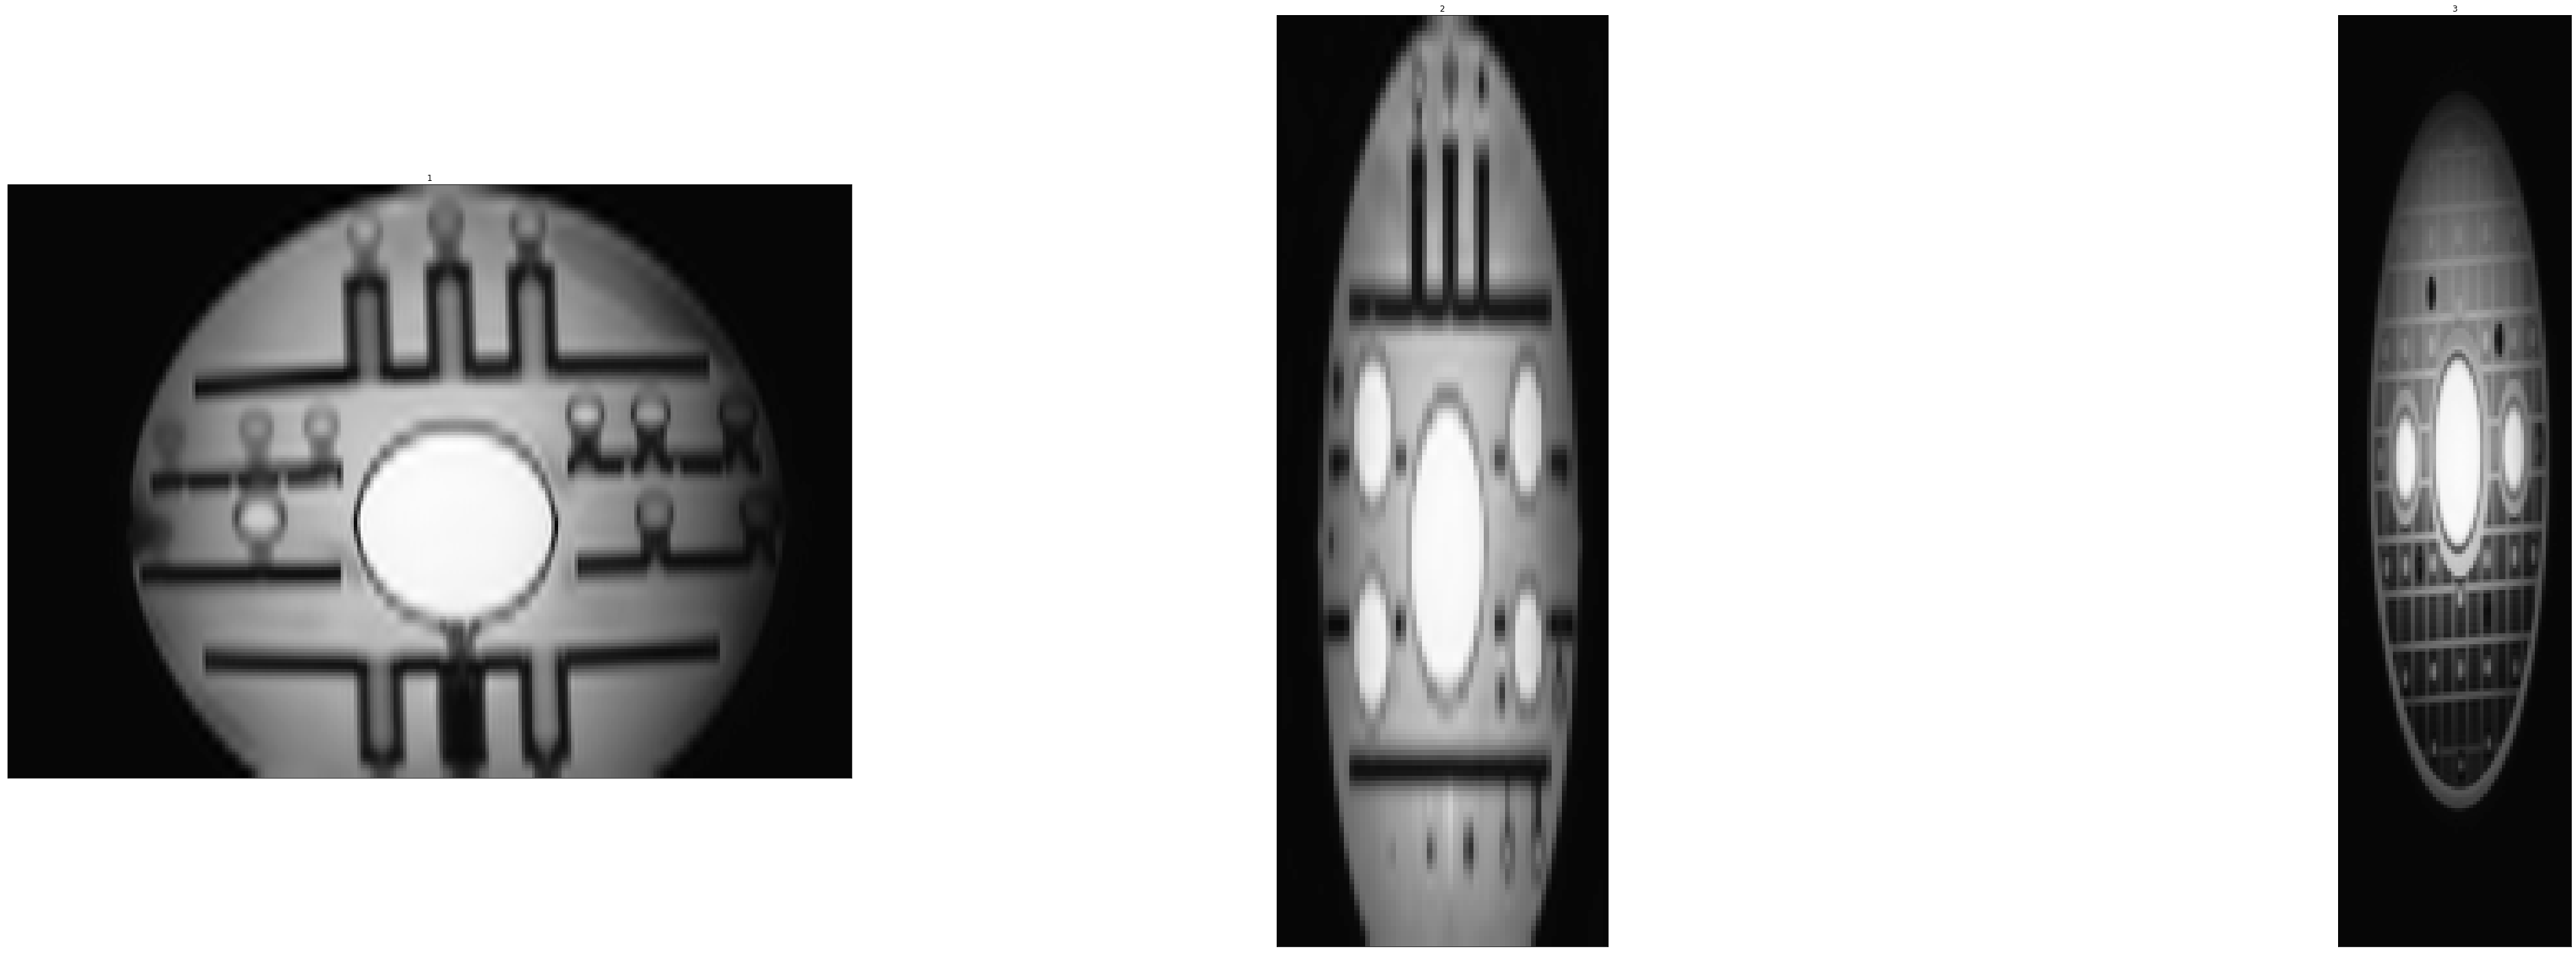

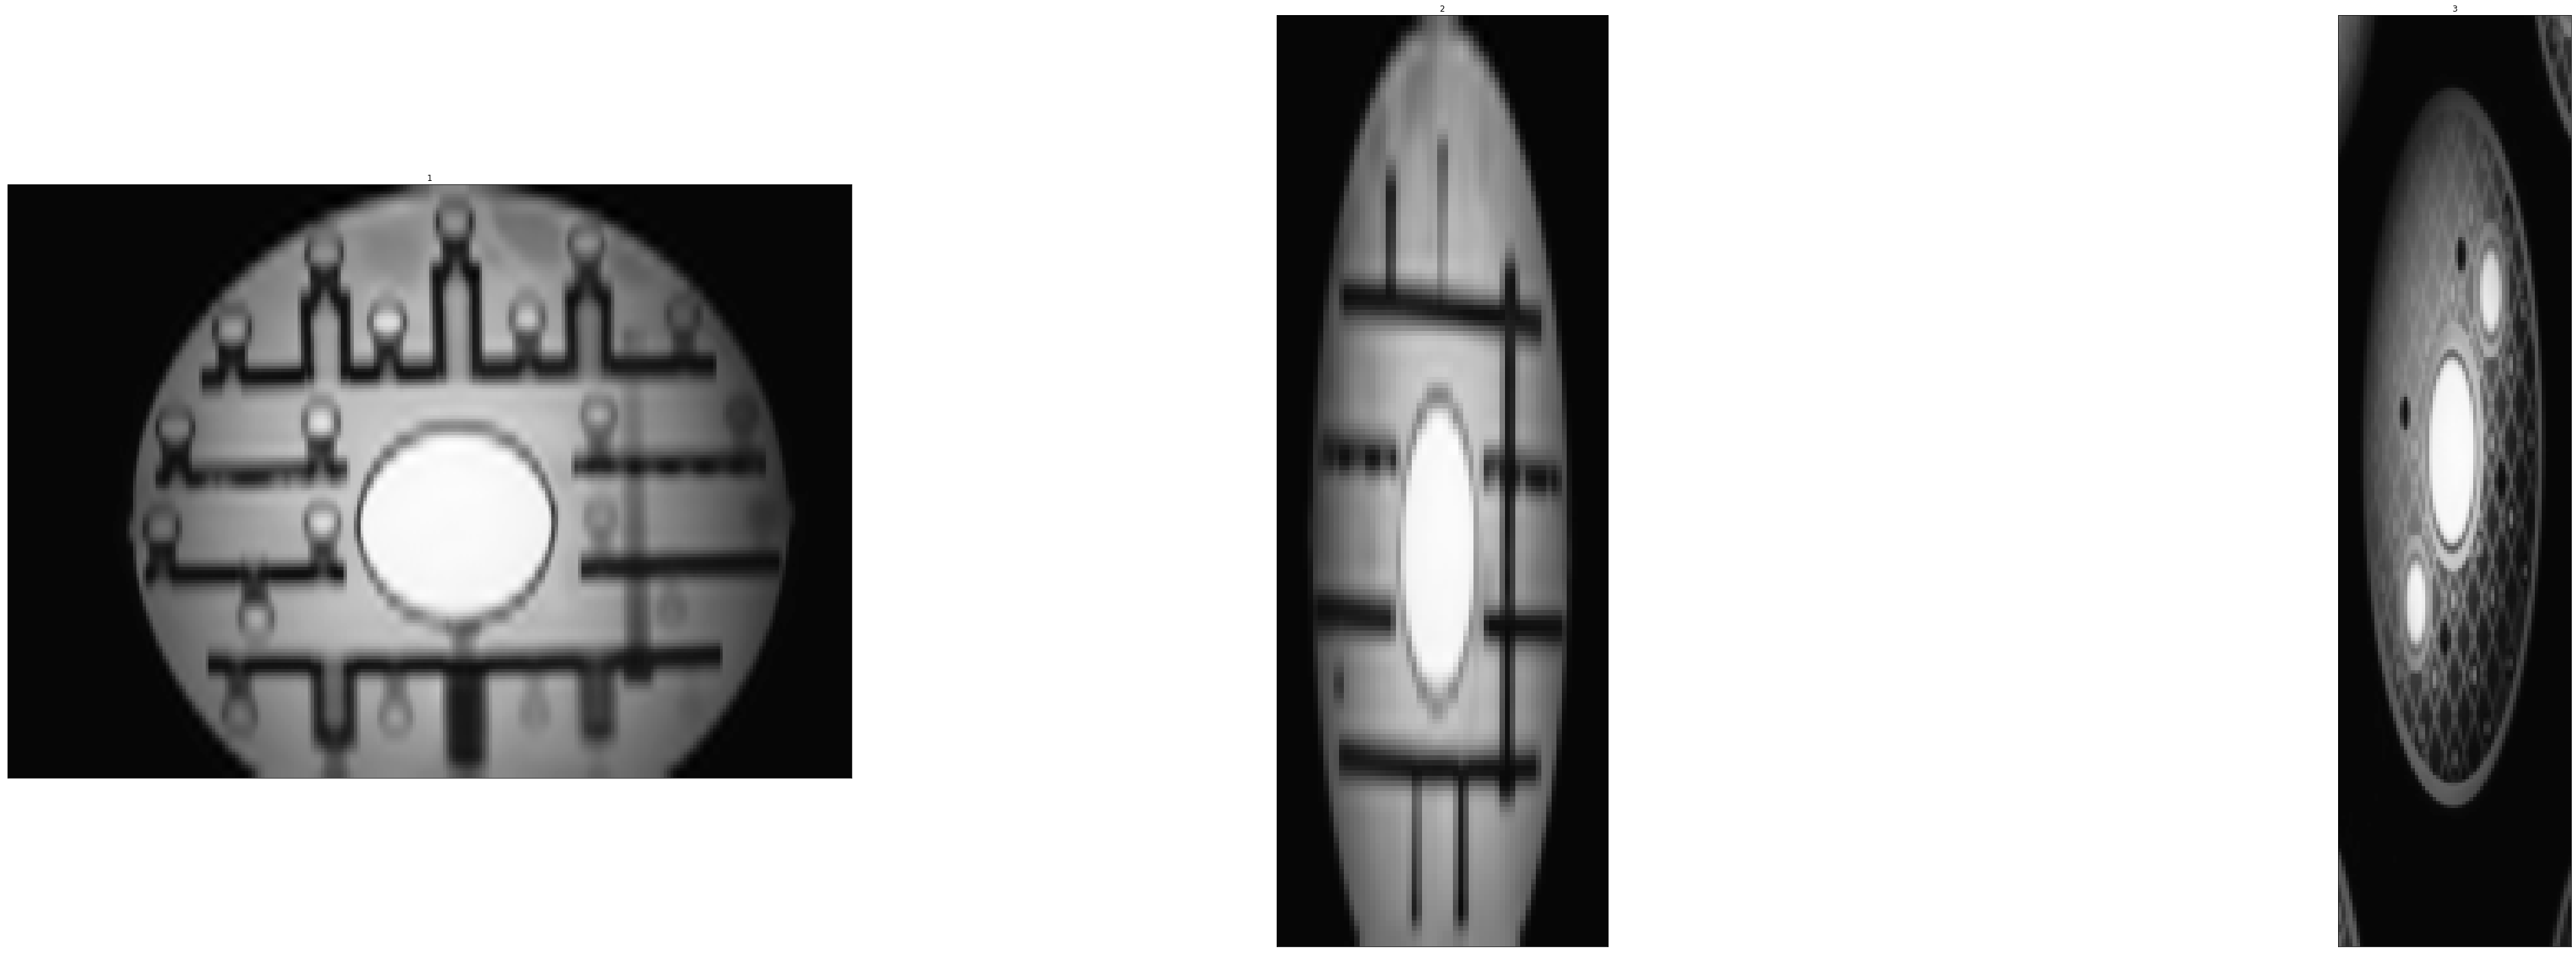

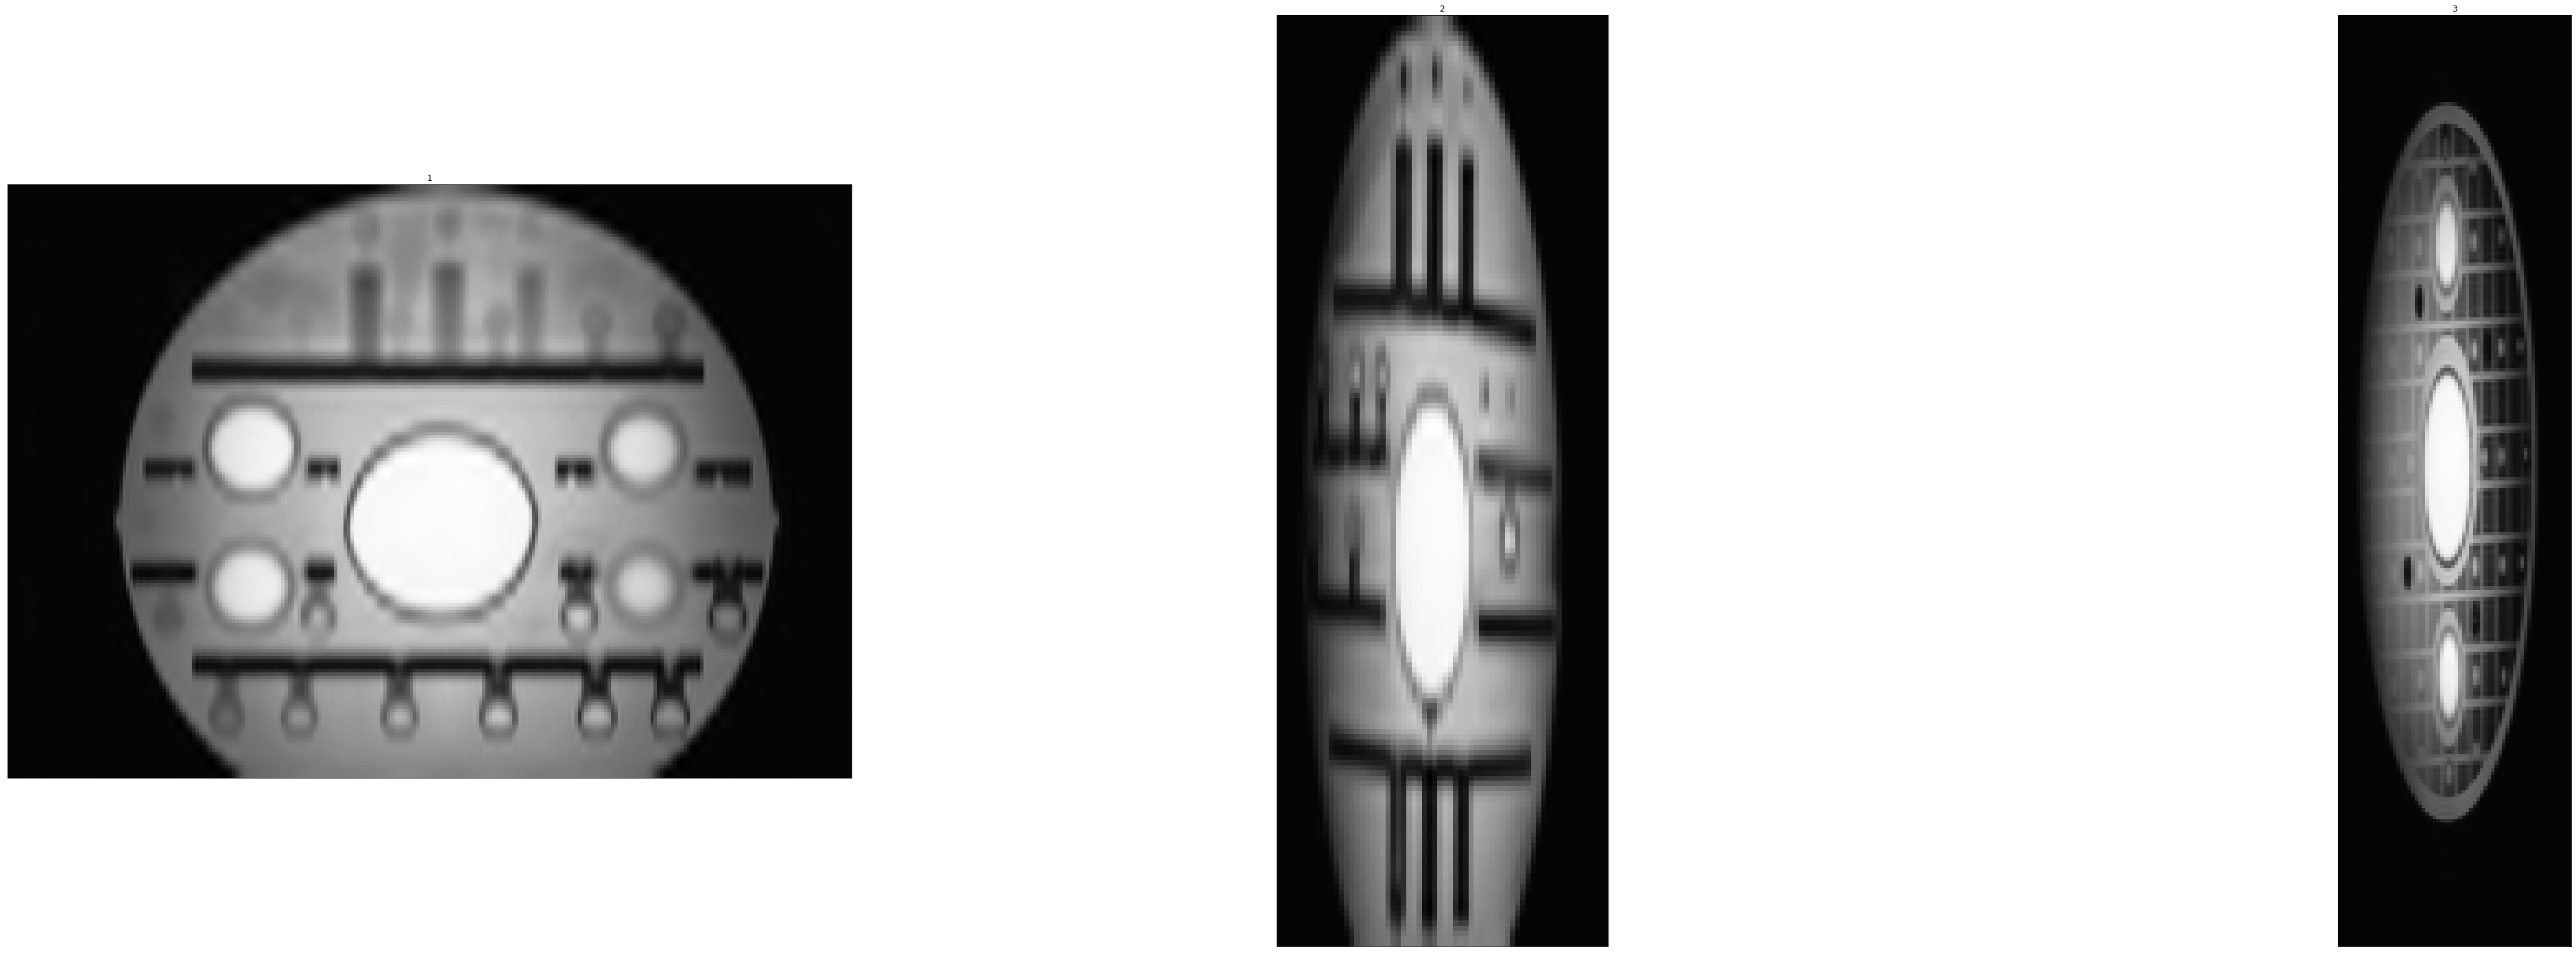

In [17]:
for img_ds in imgs_ds:
    center_vol_plot(img_ds)

# 8. Upsample in-plane in 1D, x-direction

In [18]:
dxyz_up = [1/k, 1, 1]
imgs_alias = [resize(img_ds, dxyz_up, order=3) for img_ds in imgs_ds]

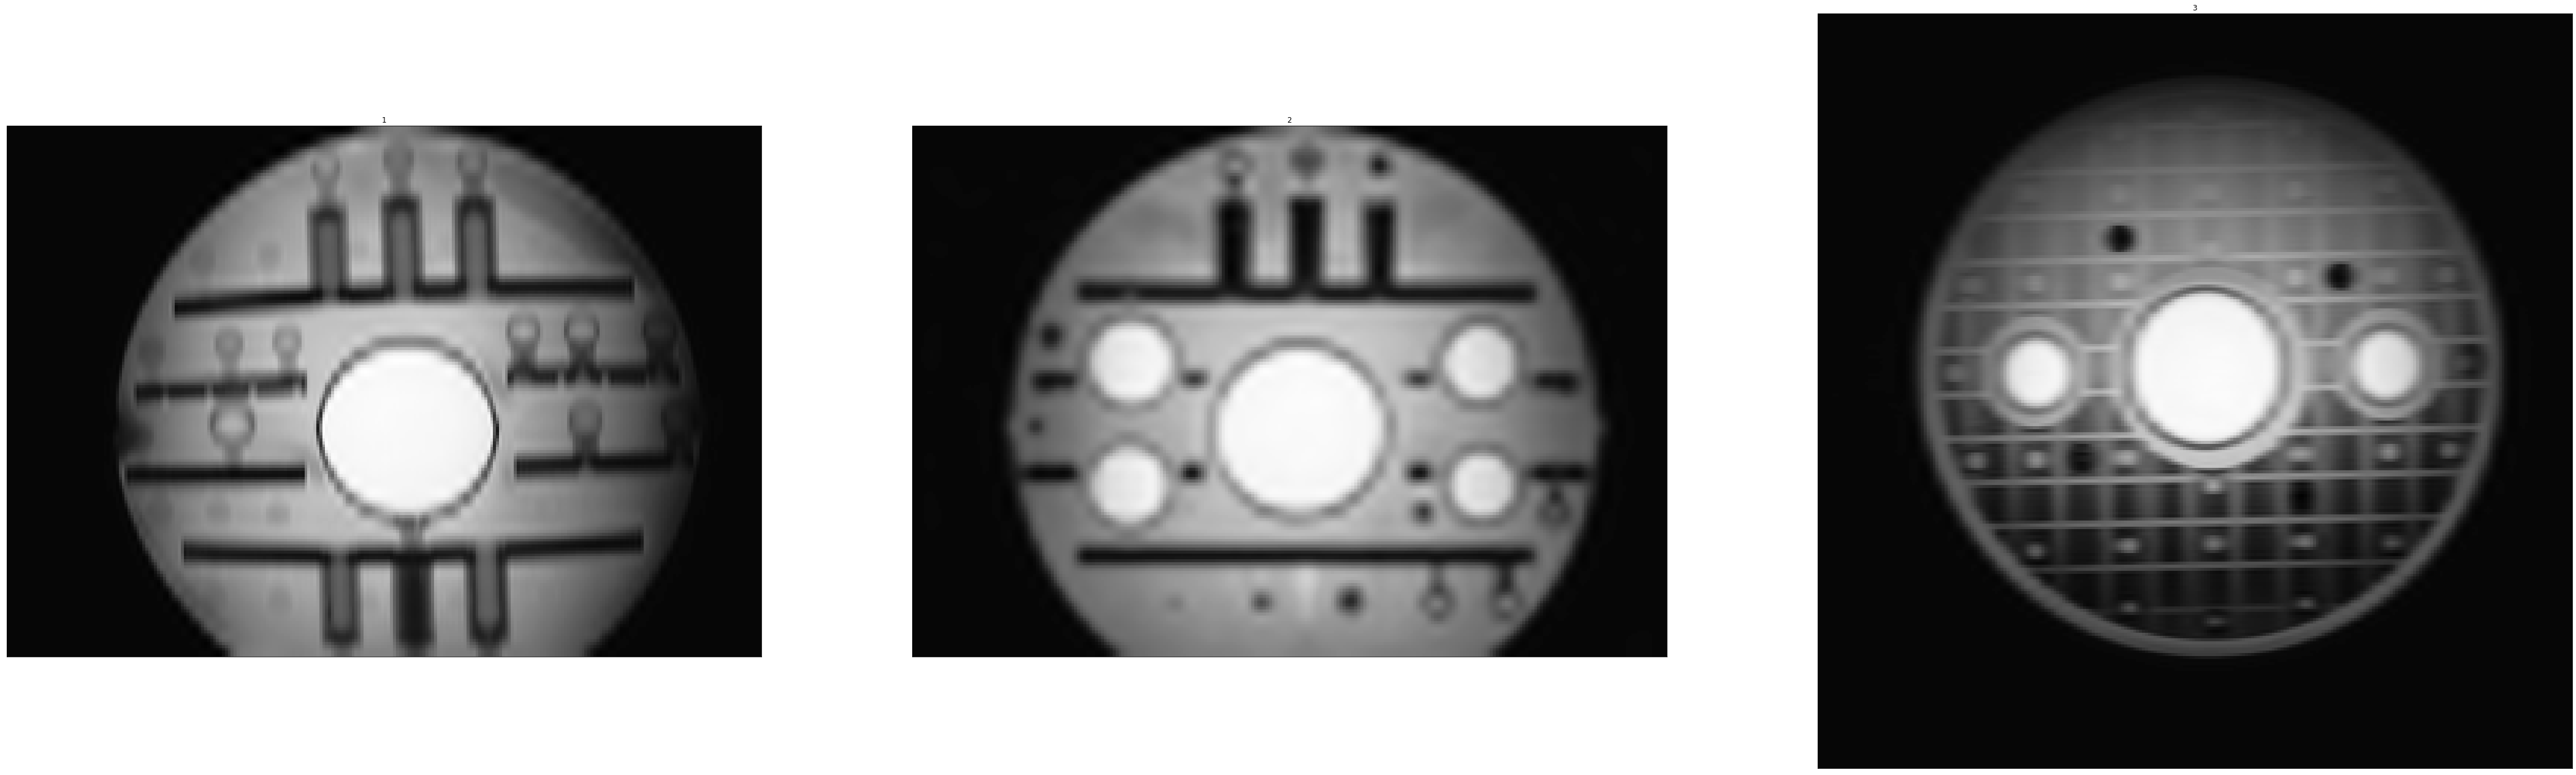

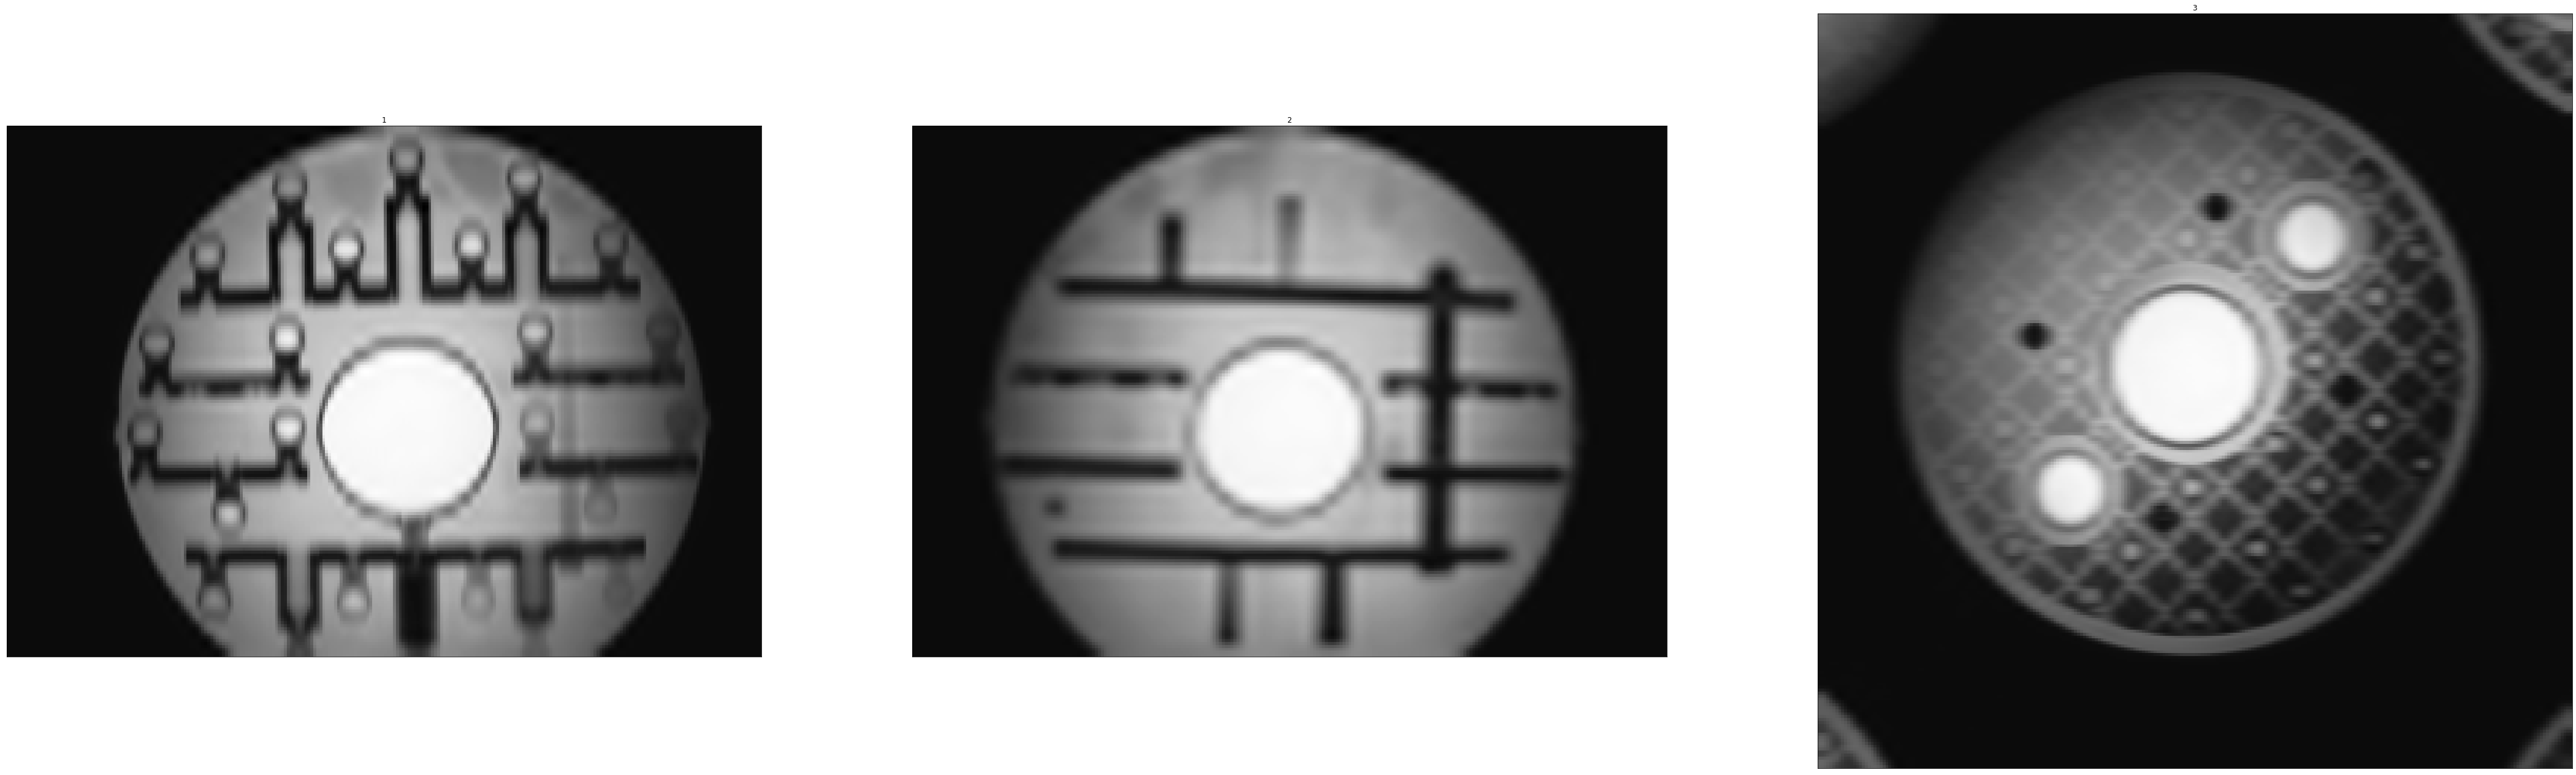

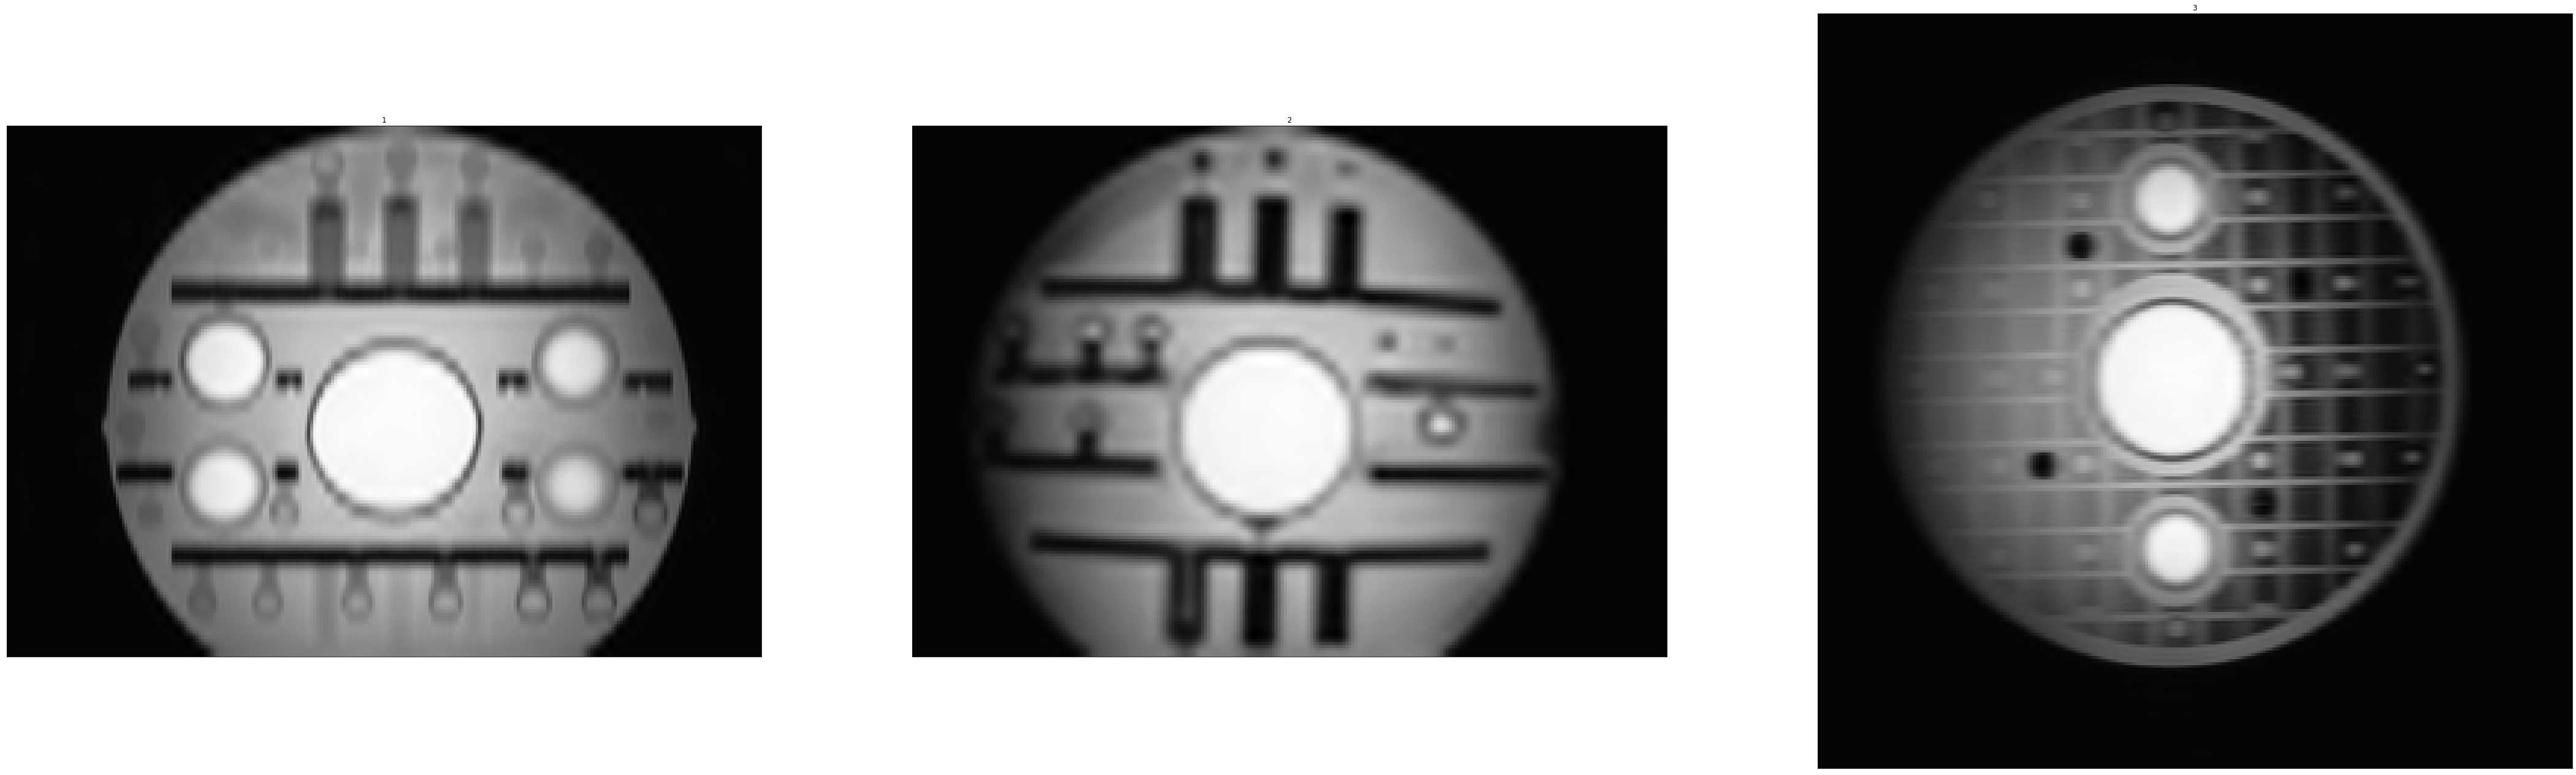

In [19]:
for img_alias in imgs_alias:
    center_vol_plot(img_alias)

# 9. Pull Patches

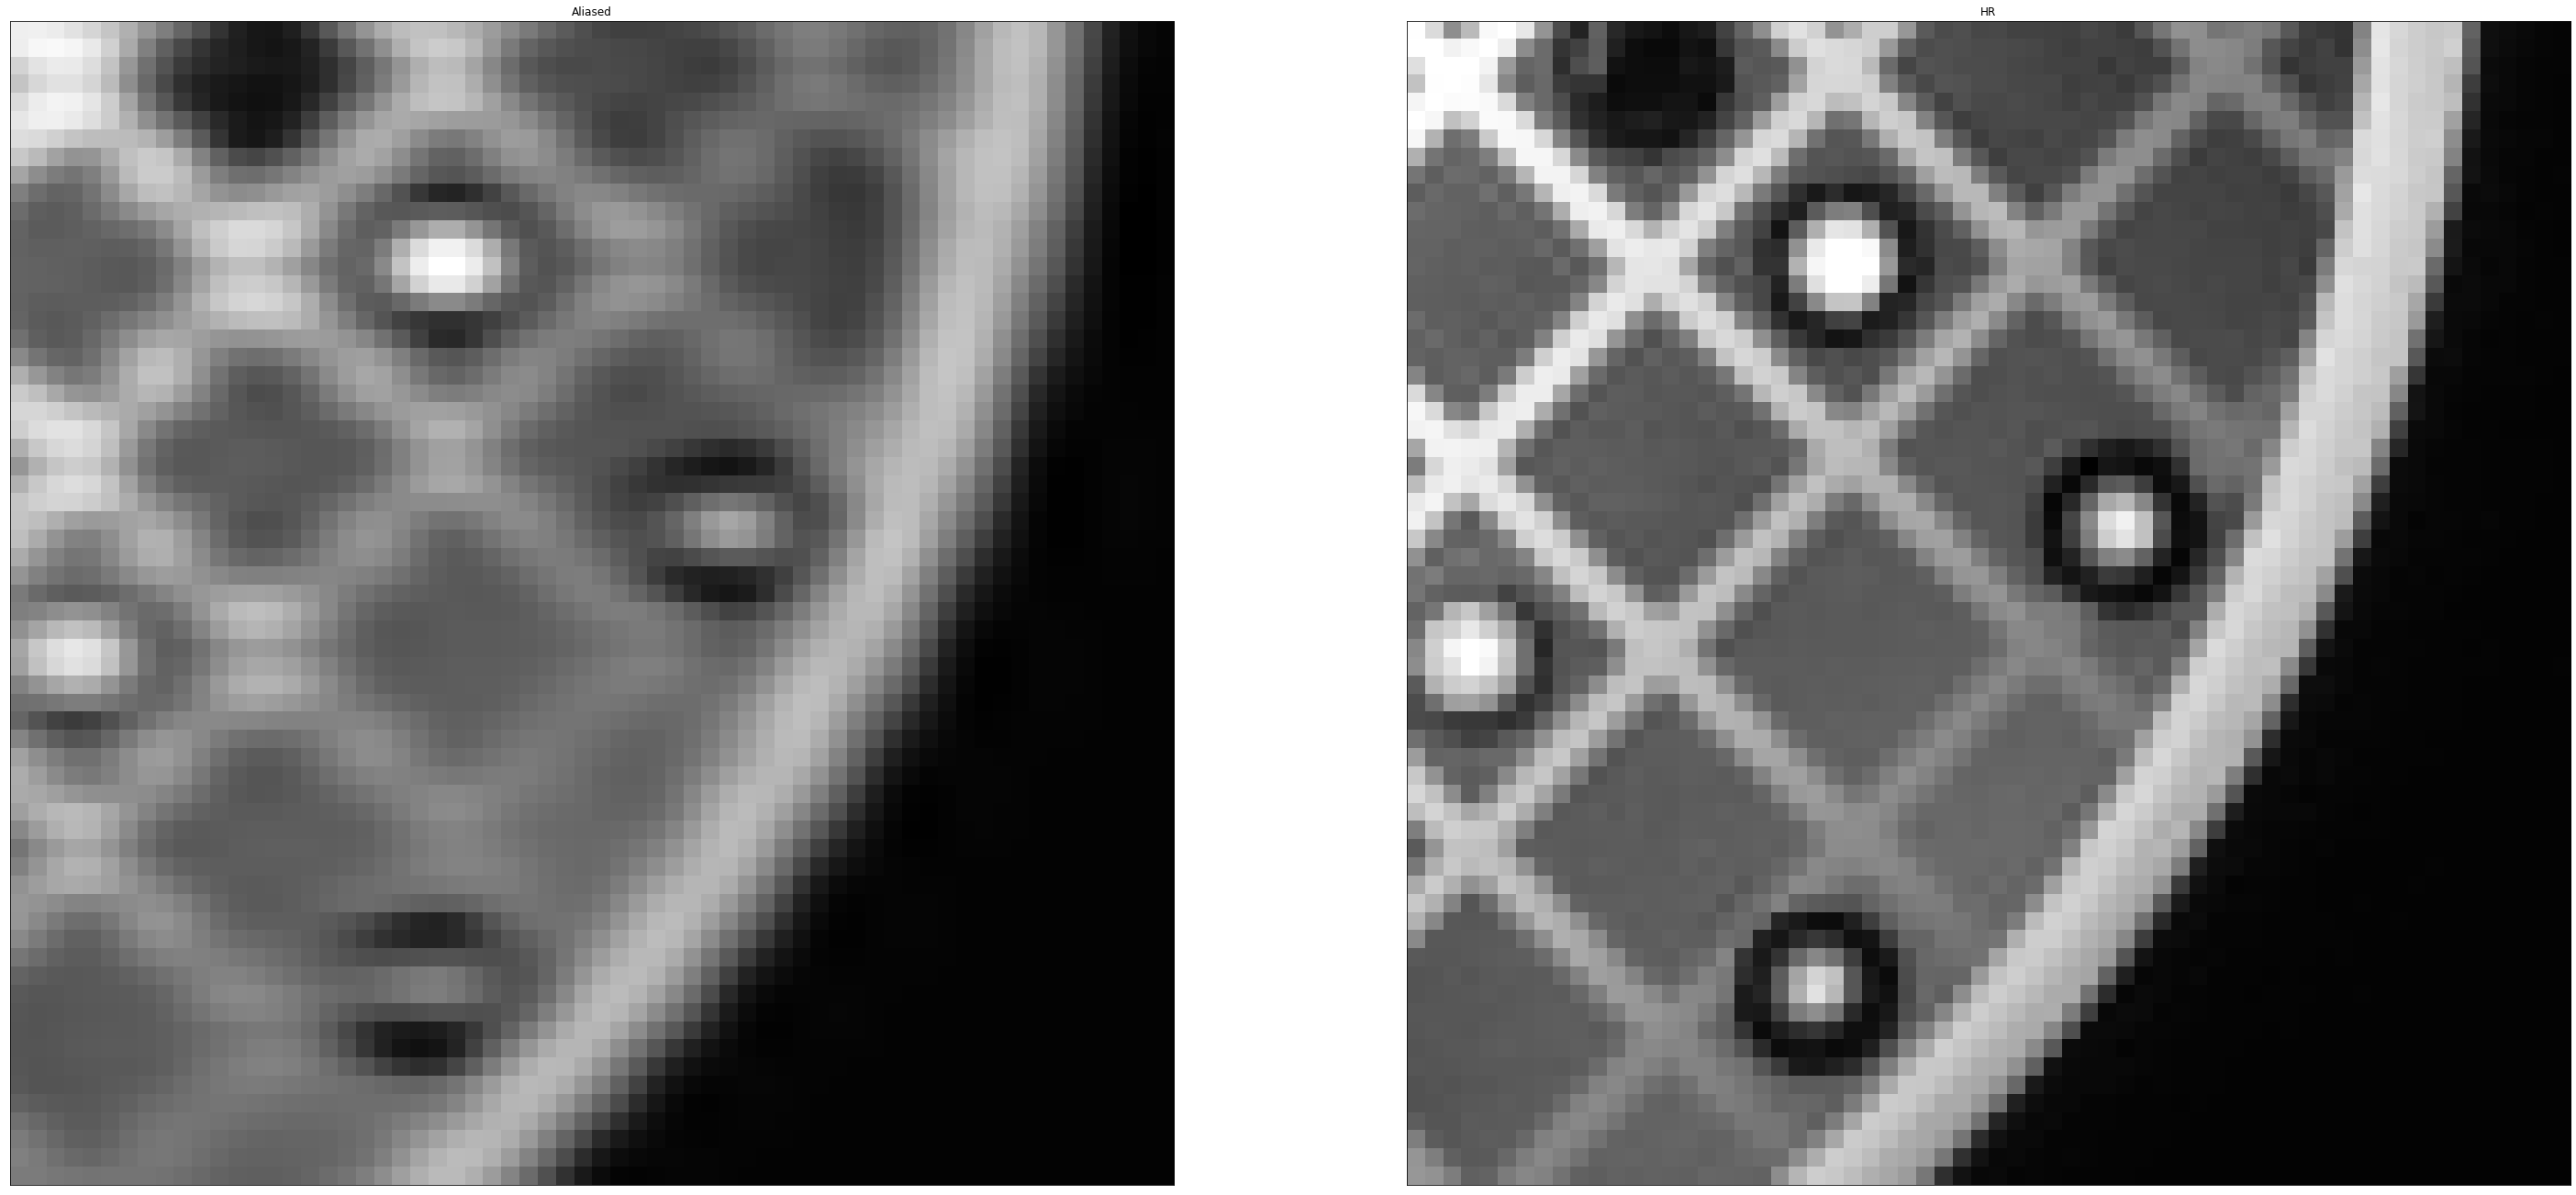

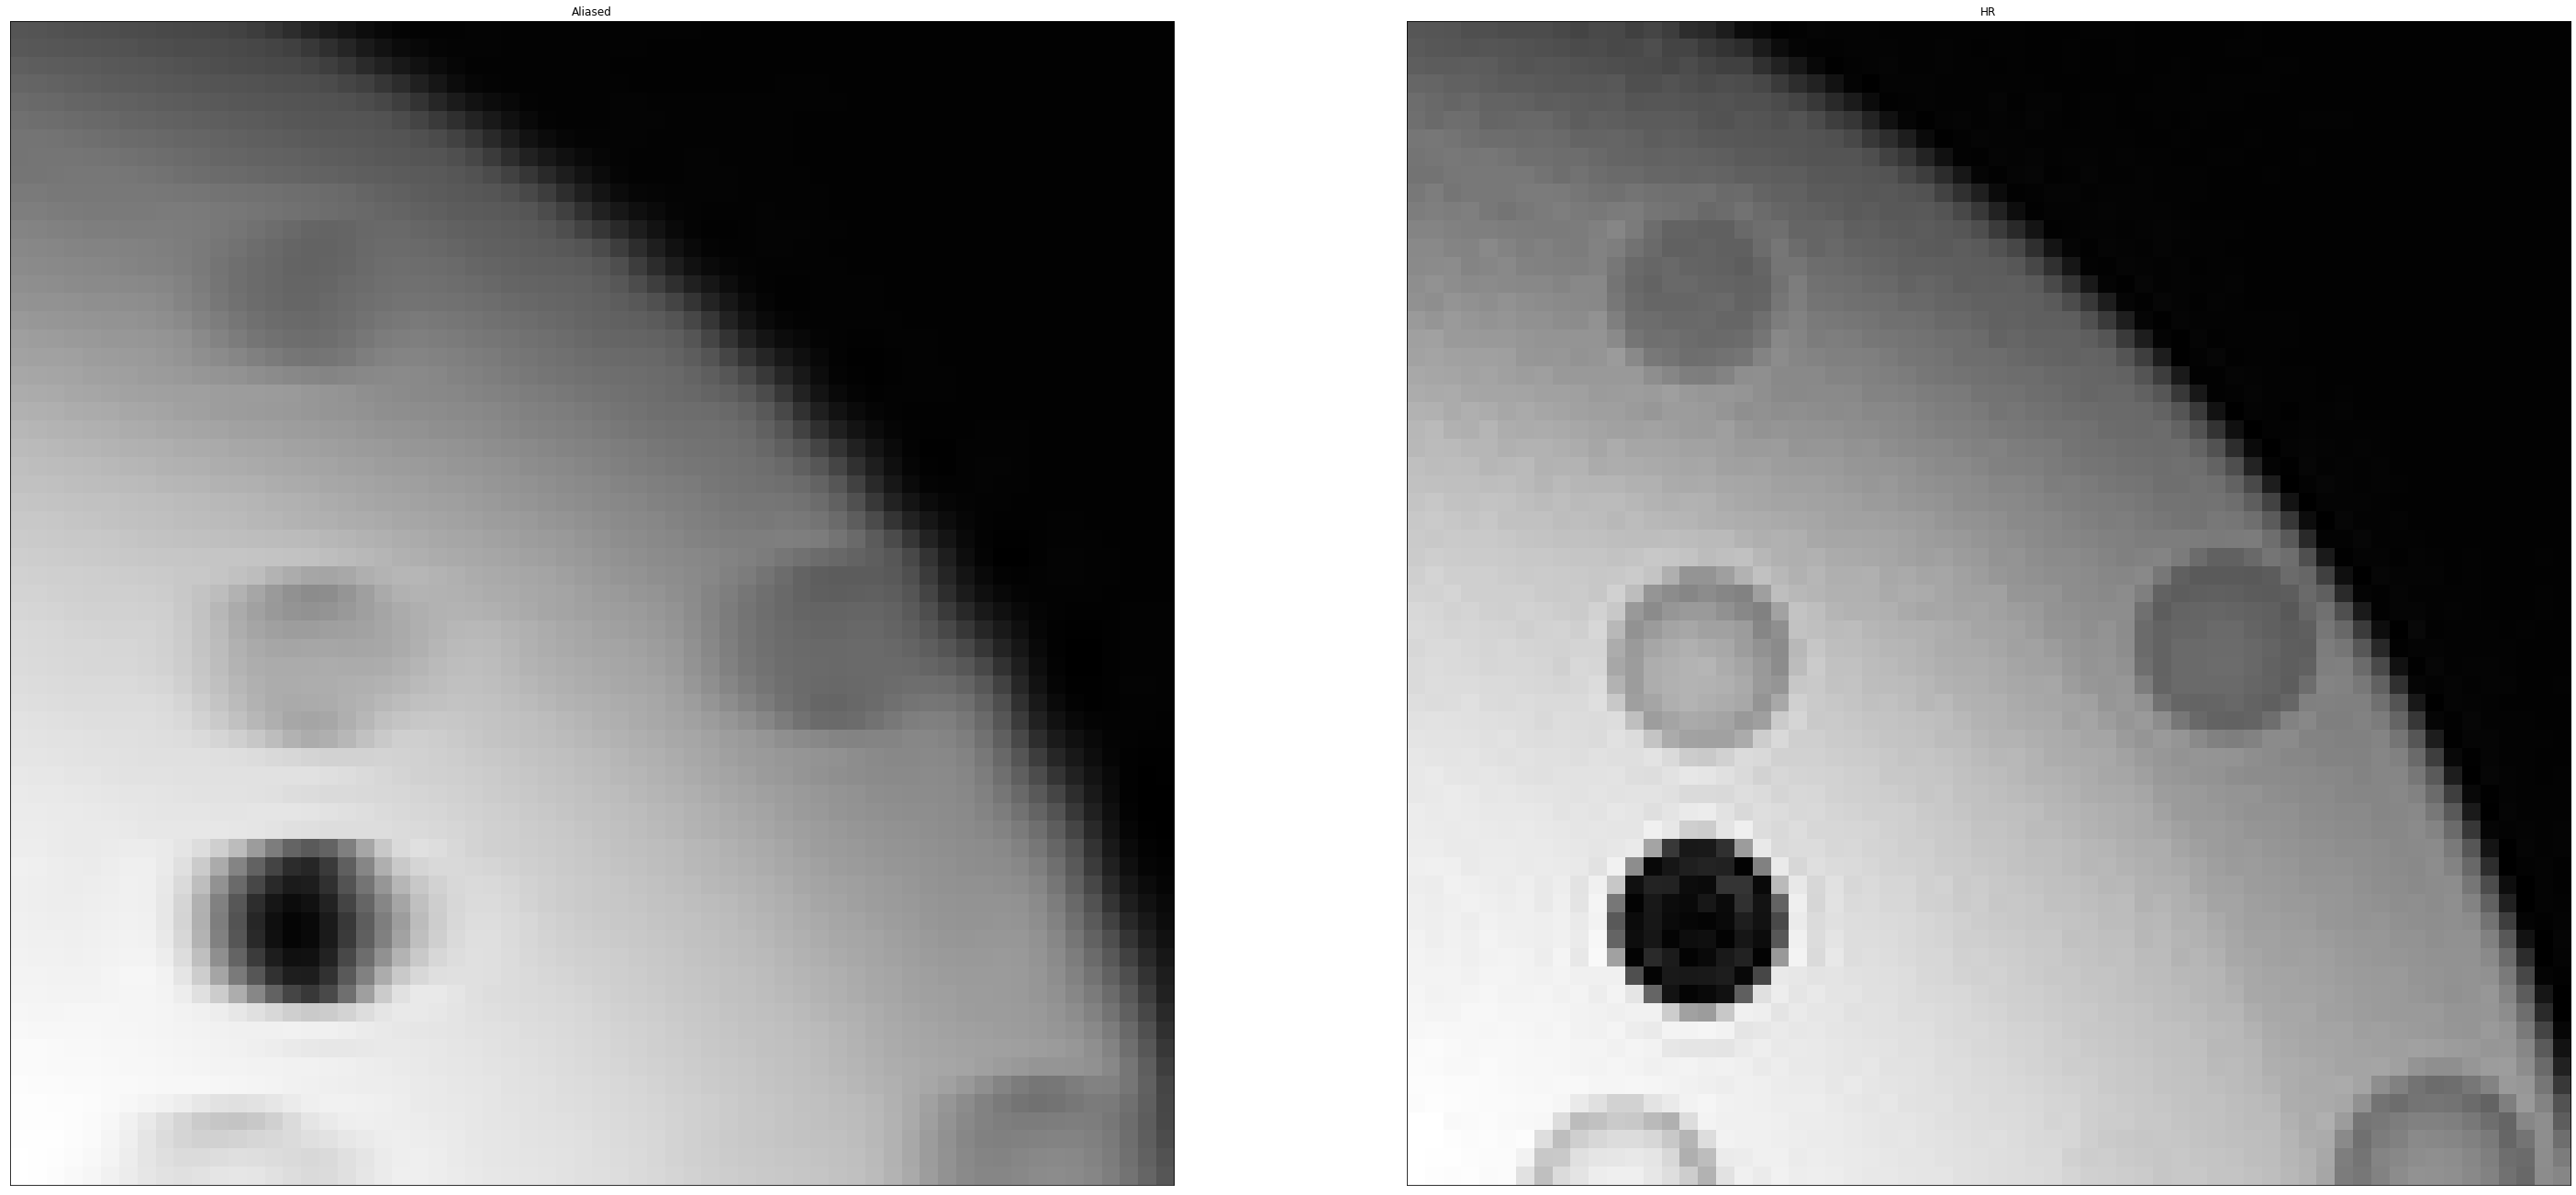

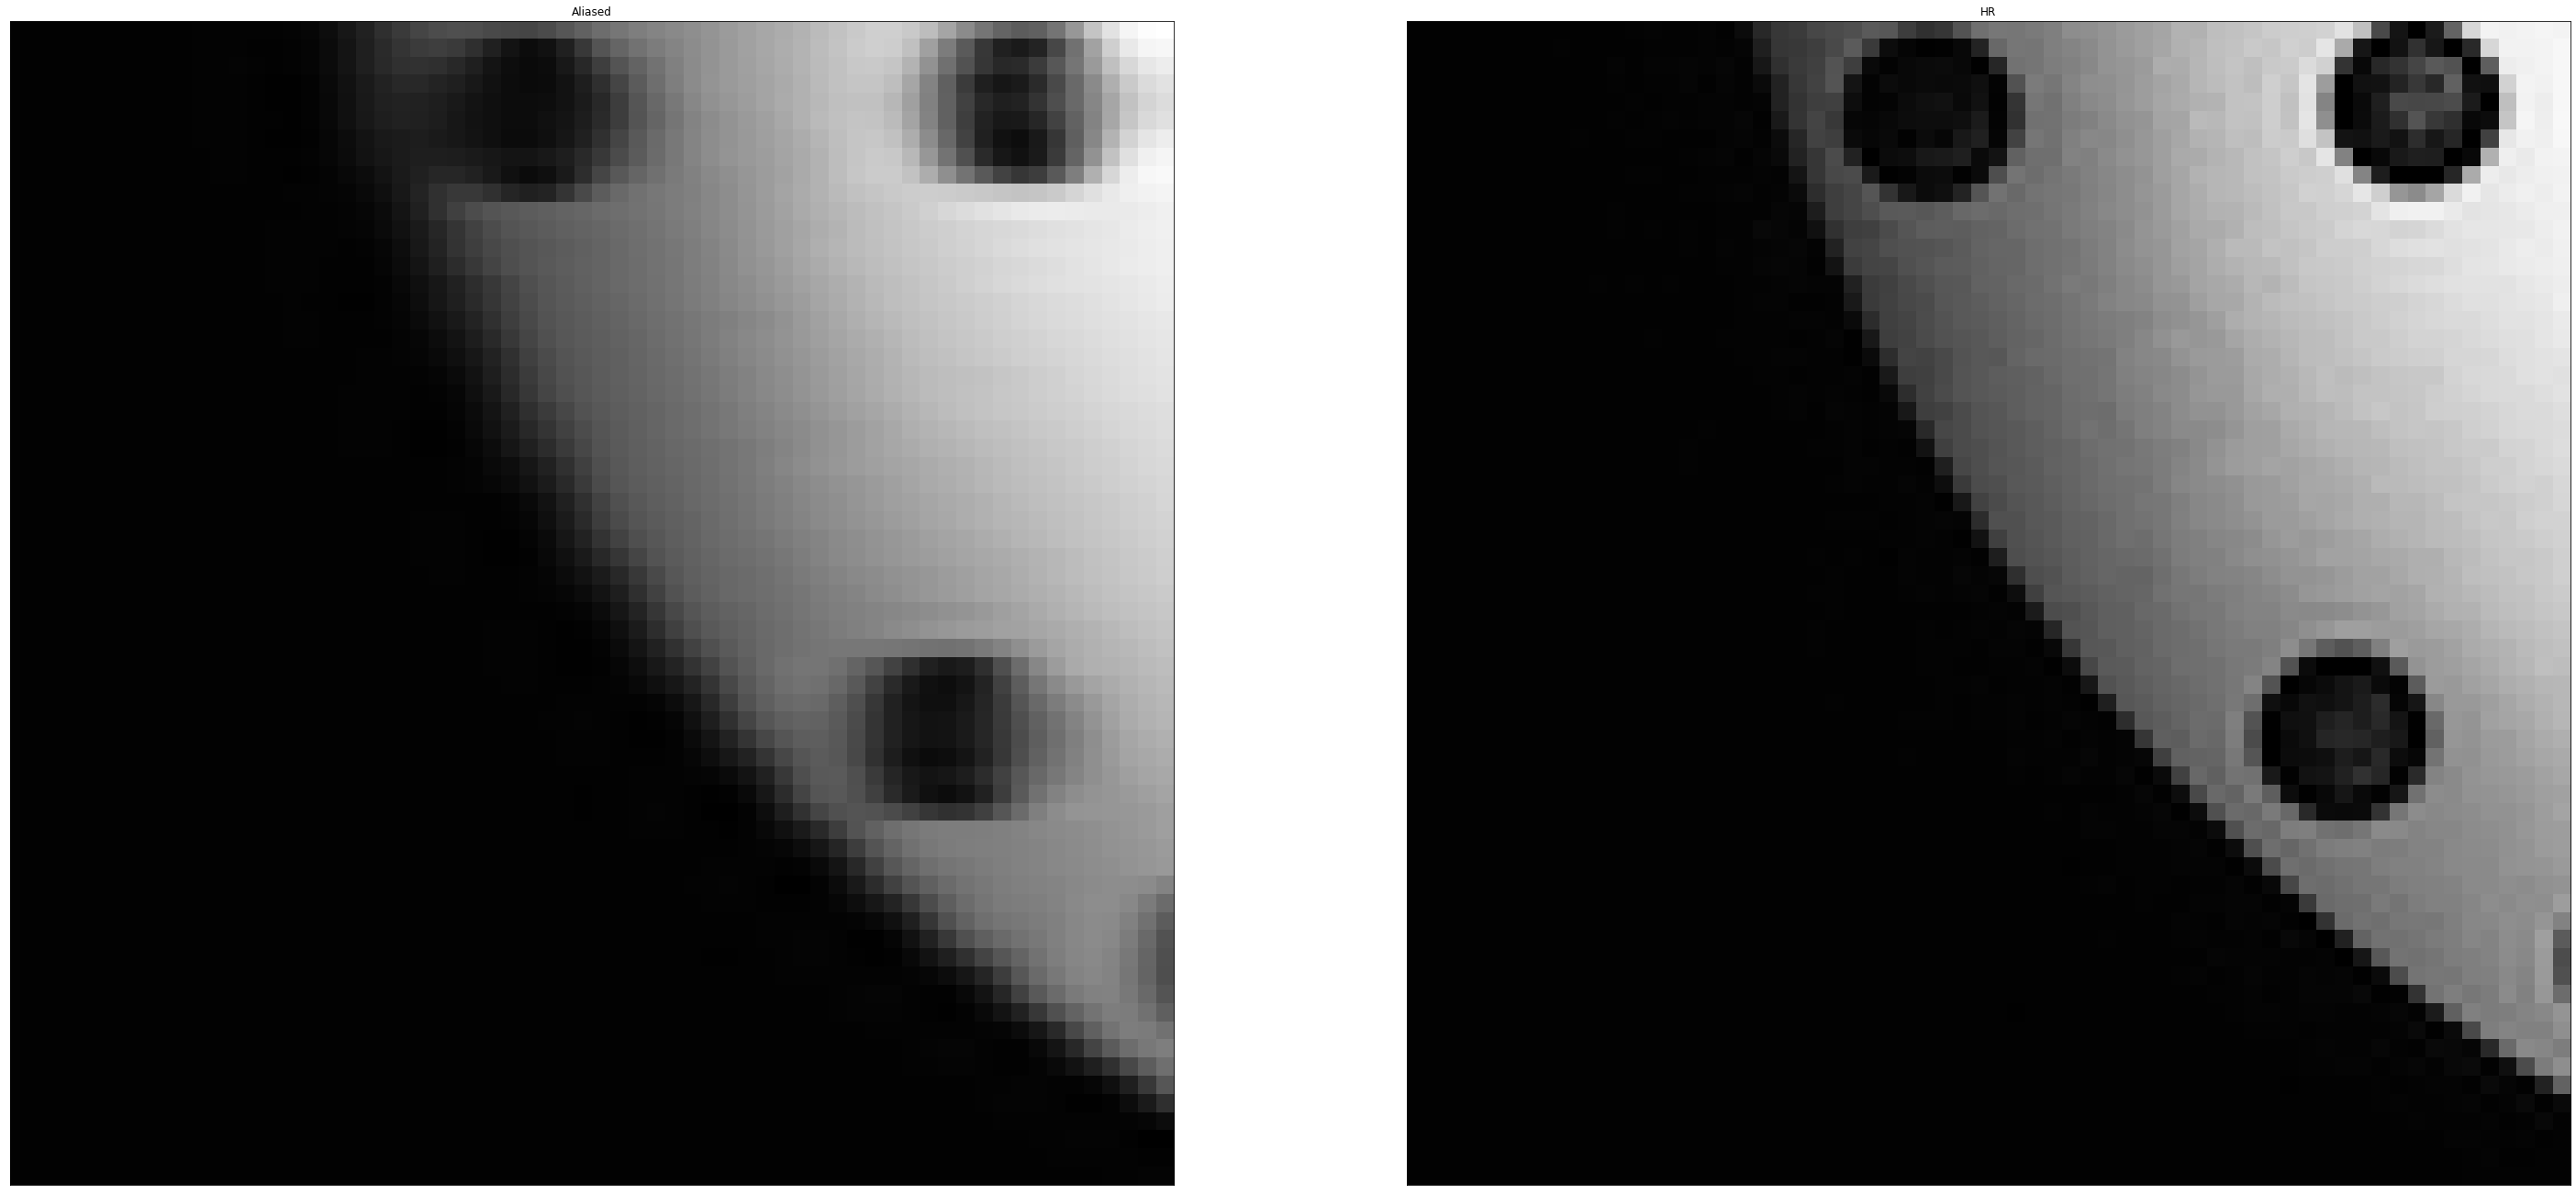

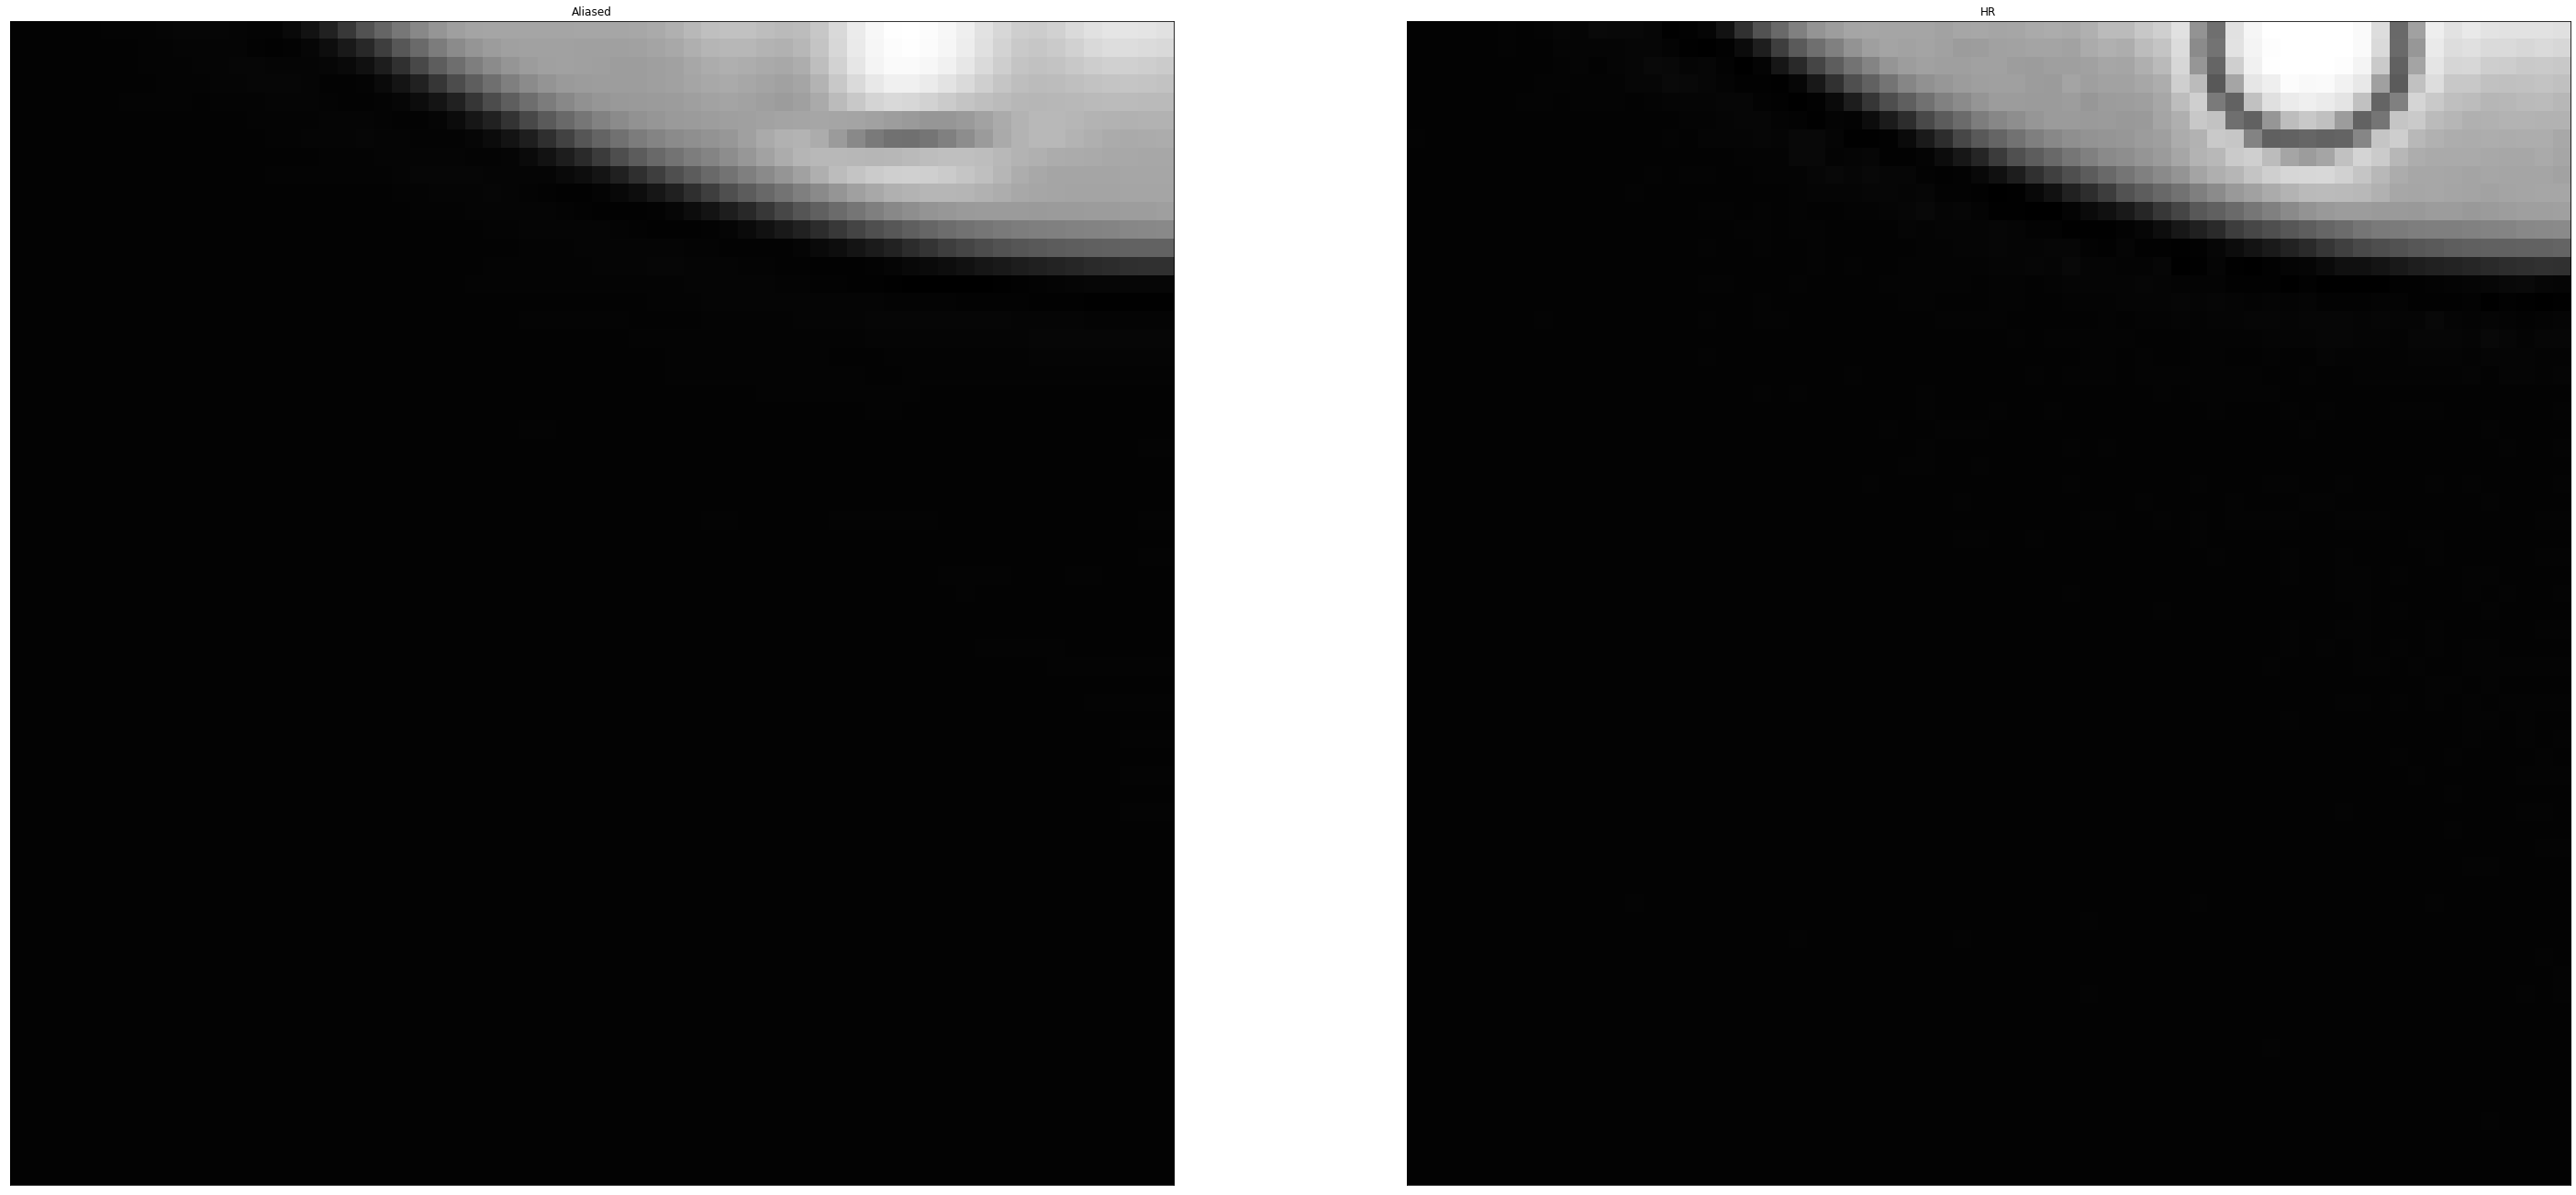

In [37]:
for _ in range(4):
    x, y = get_patch(imgs_rot, imgs_blur, imgs_alias,
                    patch_size=(64, 64, 1),
                    mode='SR')
    multiplot([x, y], ['Aliased', 'HR'])

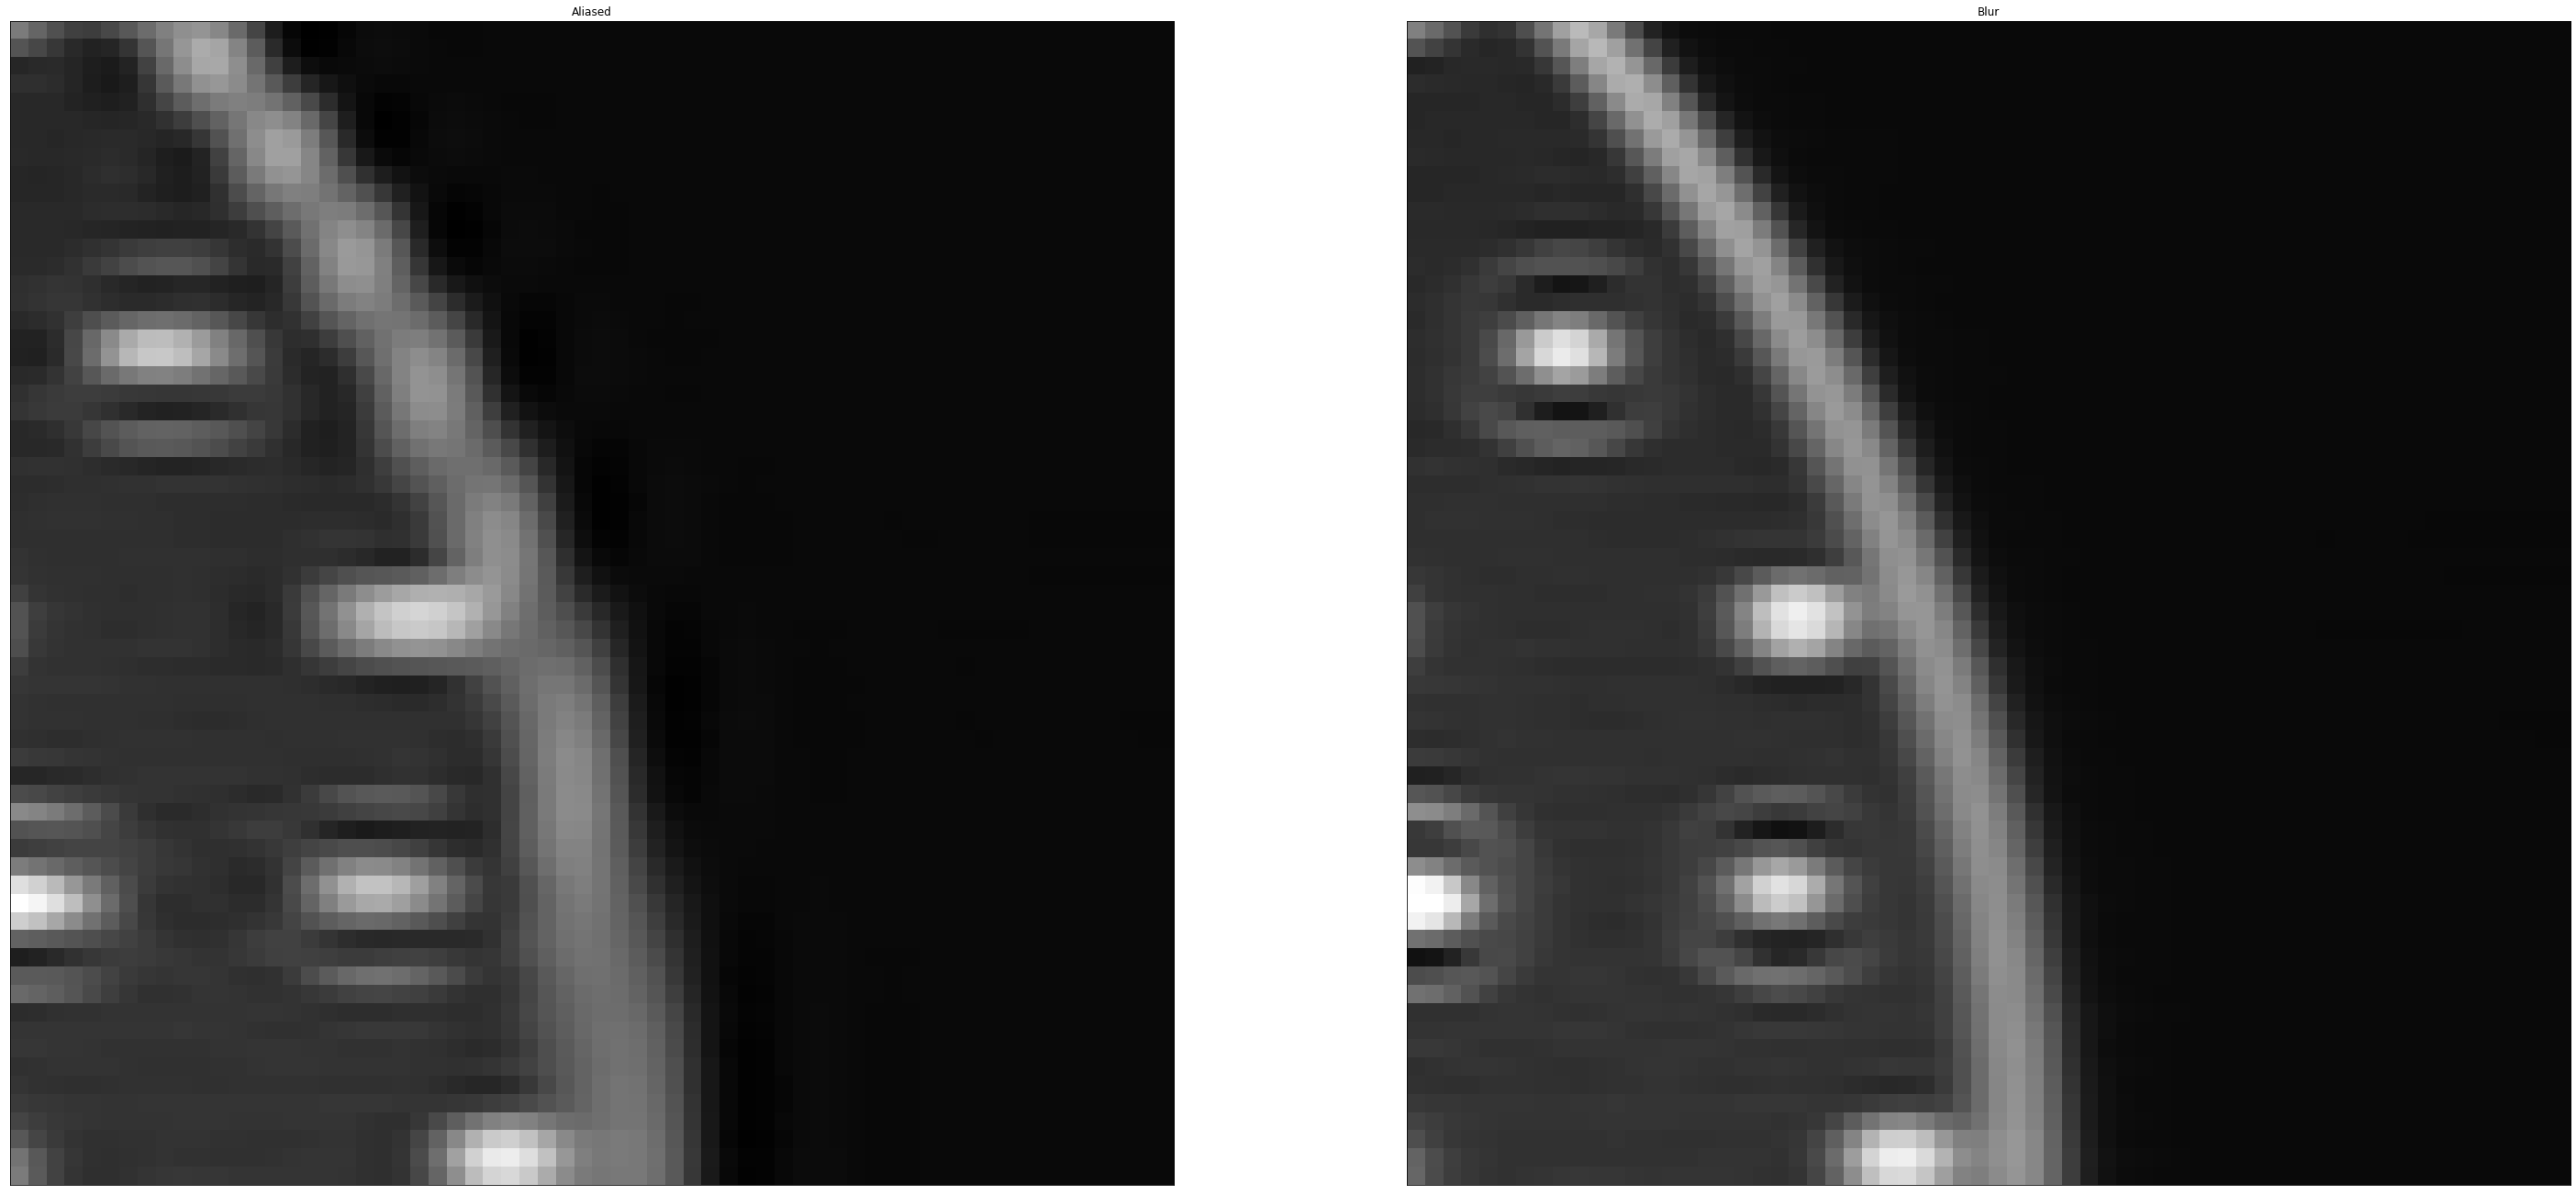

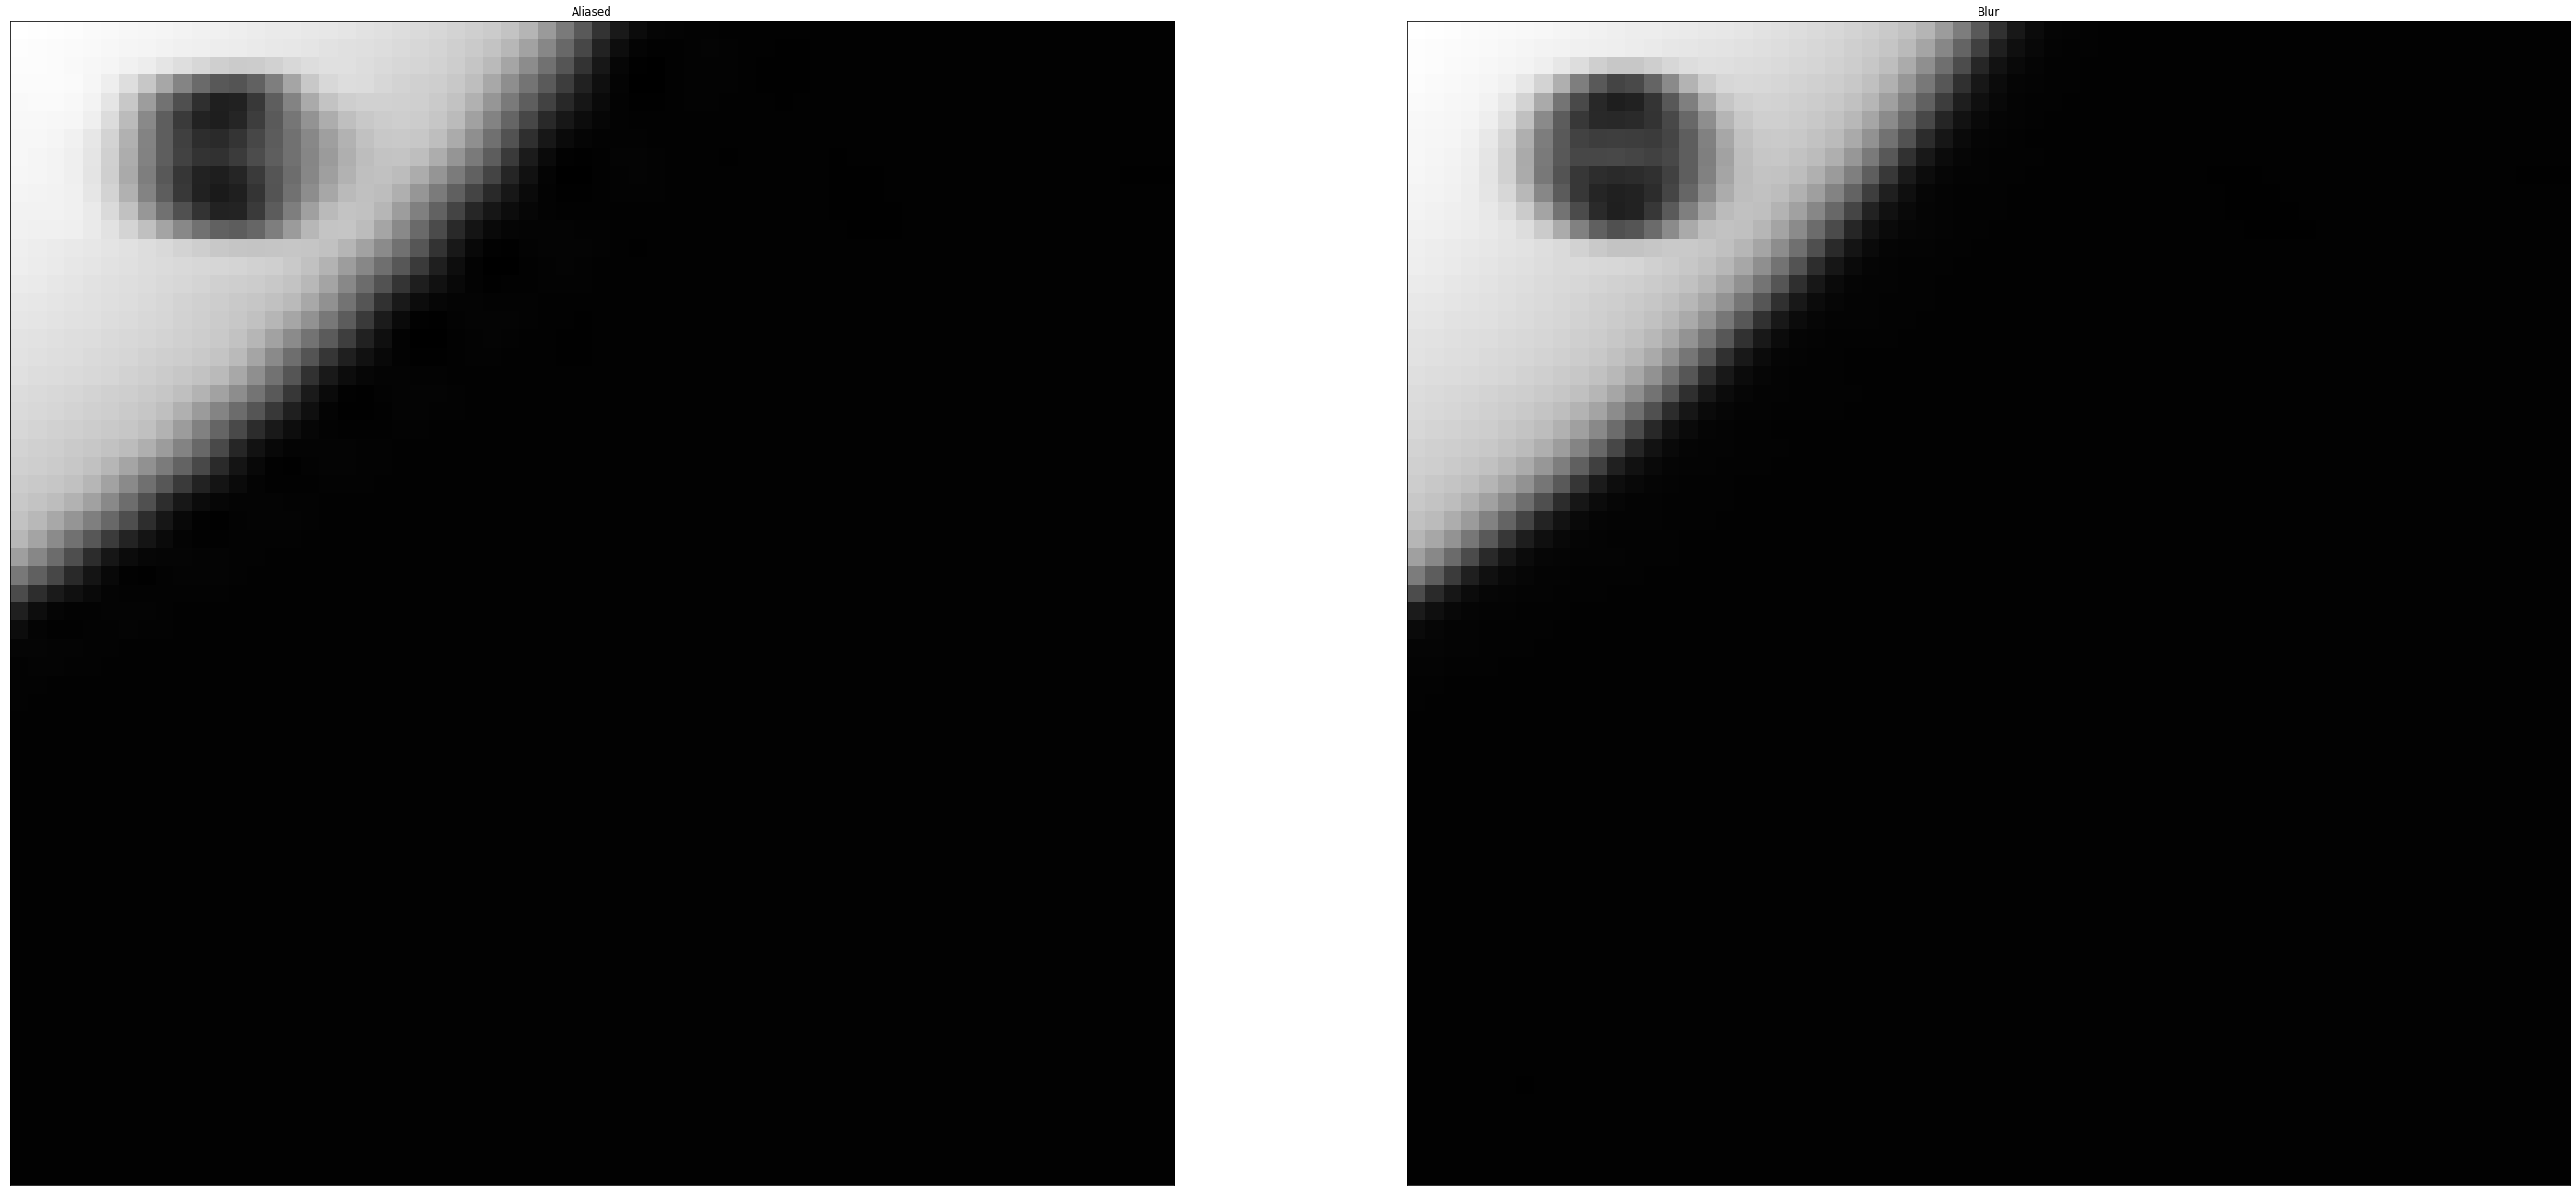

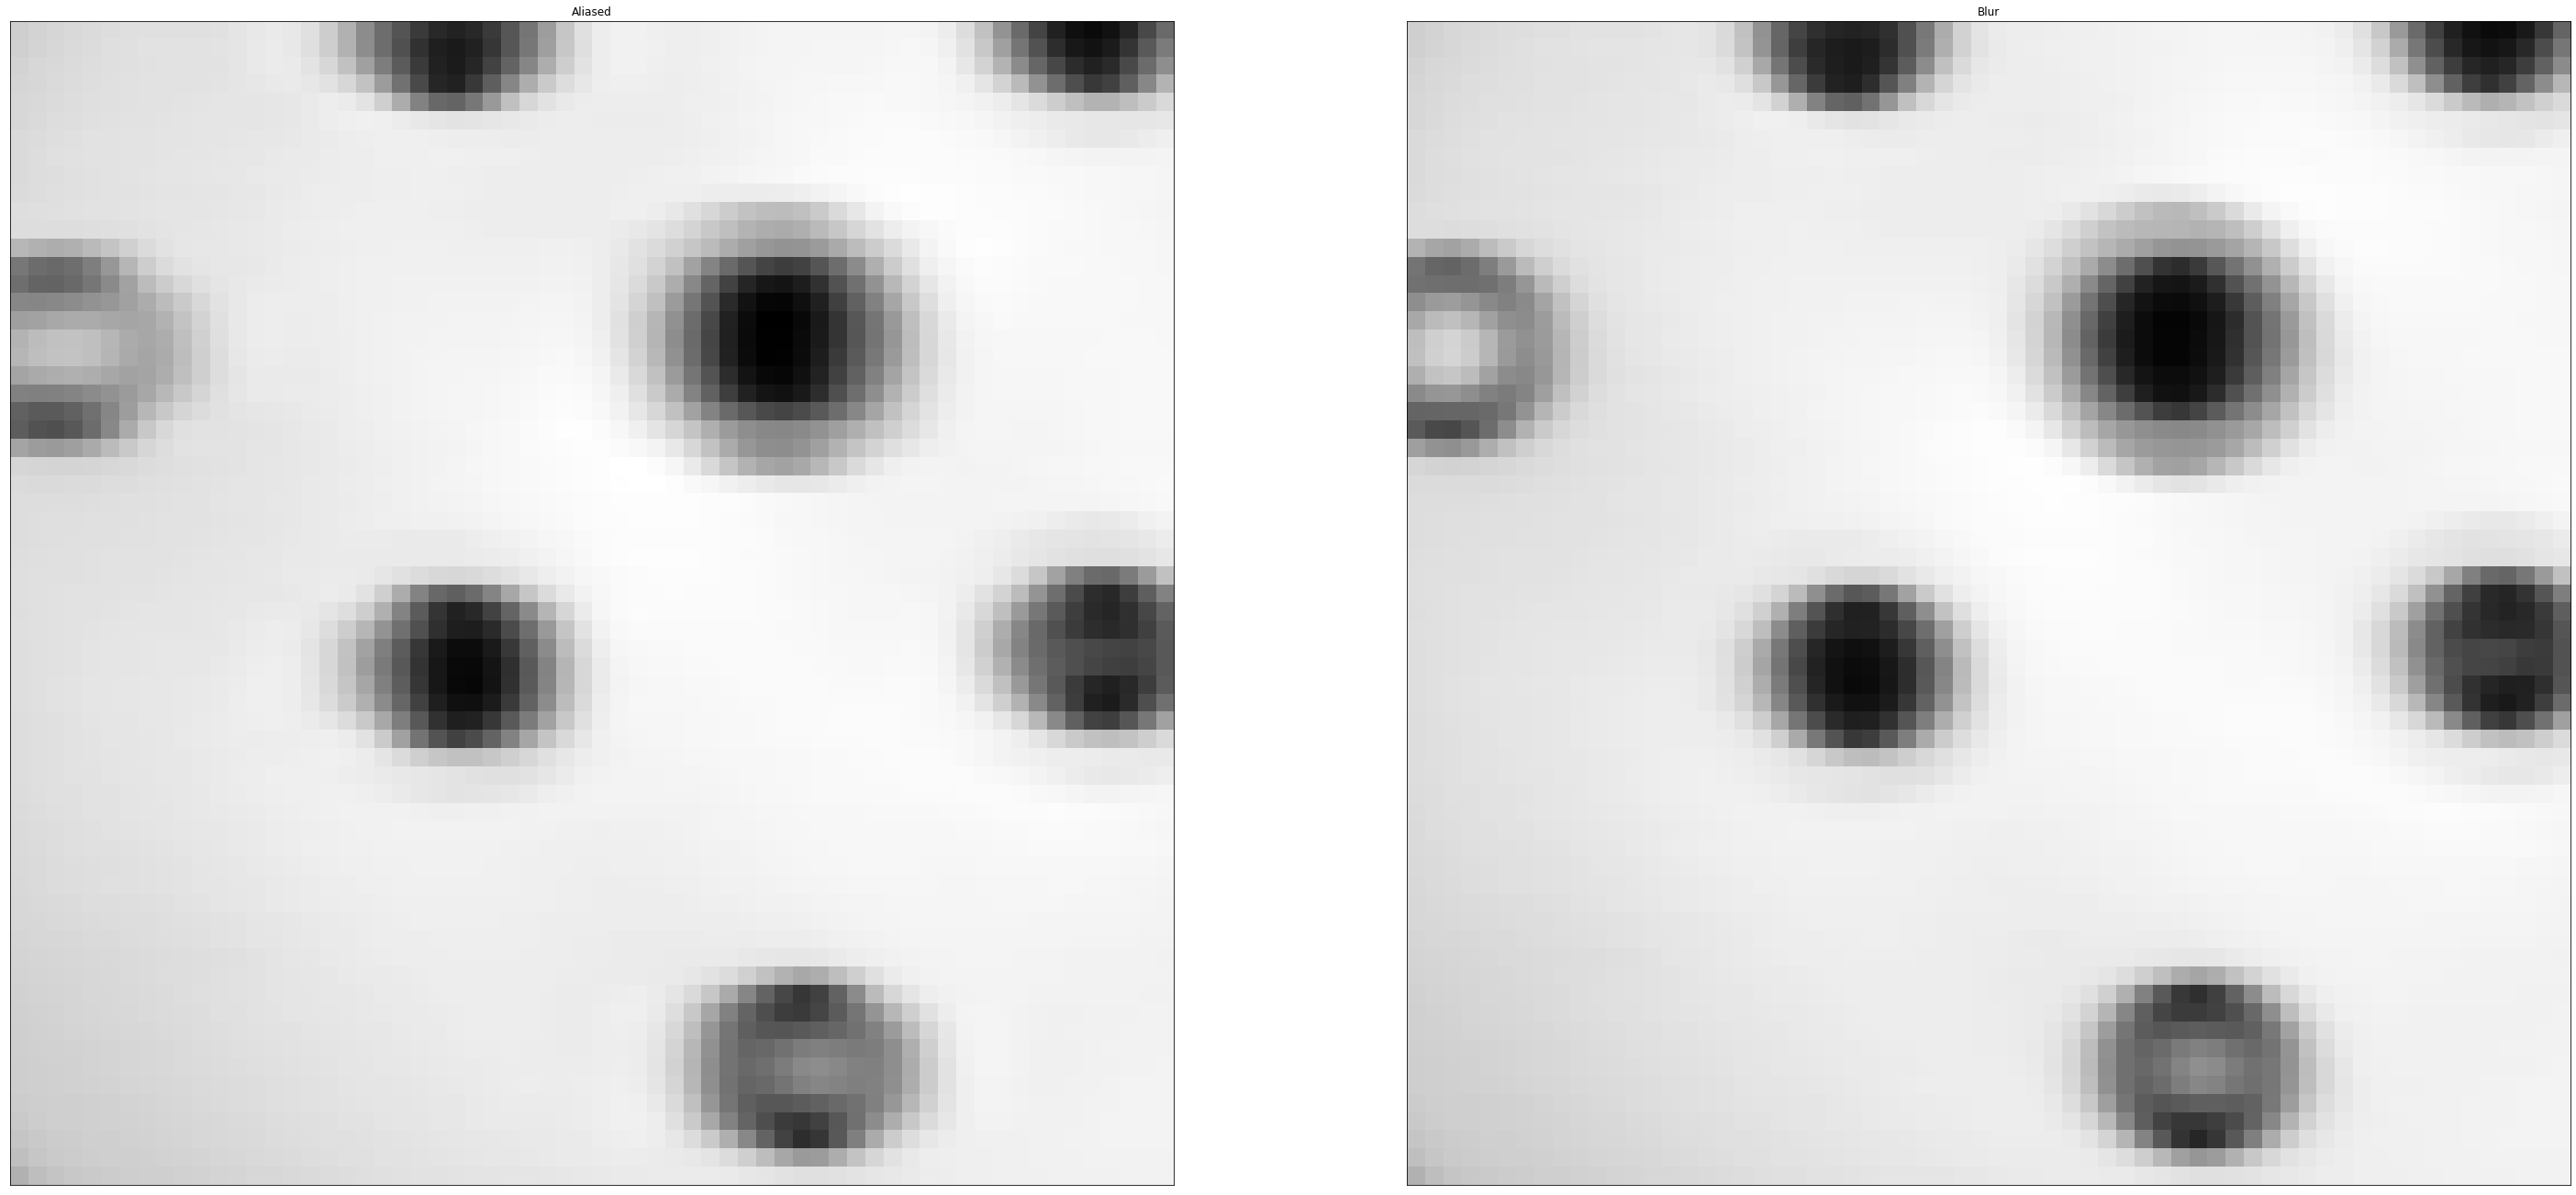

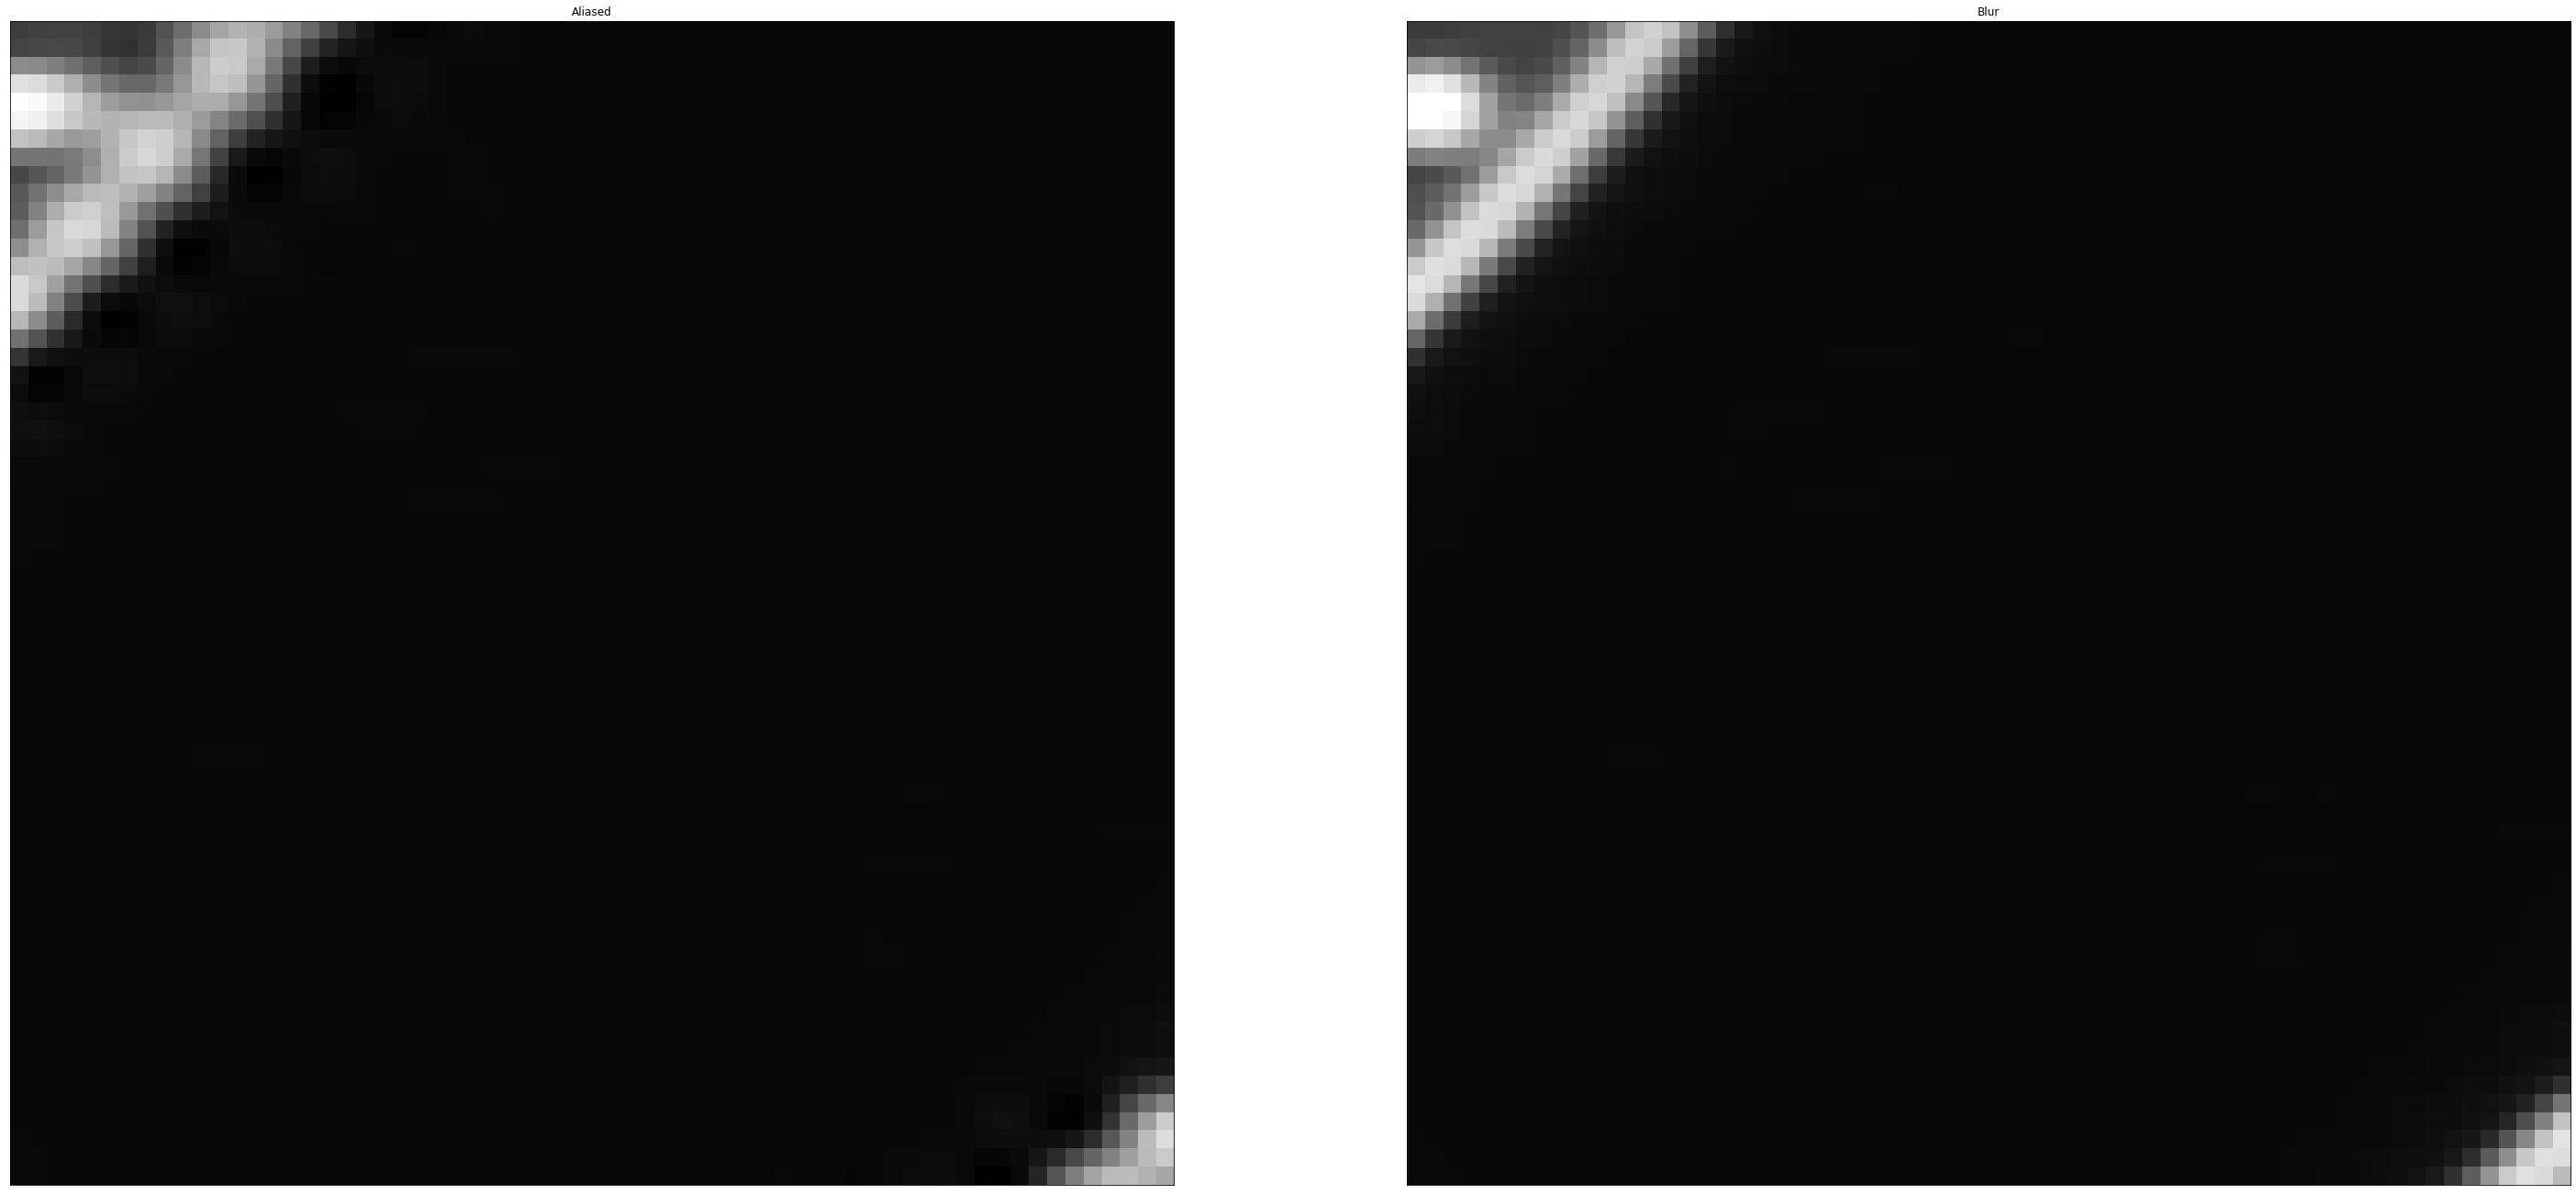

In [38]:
for _ in range(4):
    x, y = get_patch(imgs_rot, imgs_blur, imgs_alias,
                    patch_size=(64, 64, 1),
                    mode='AA')
    multiplot([x.squeeze(), y.squeeze()], ['Aliased', 'Blur'])

# 10. Augment Patches (Only Flipping atm)

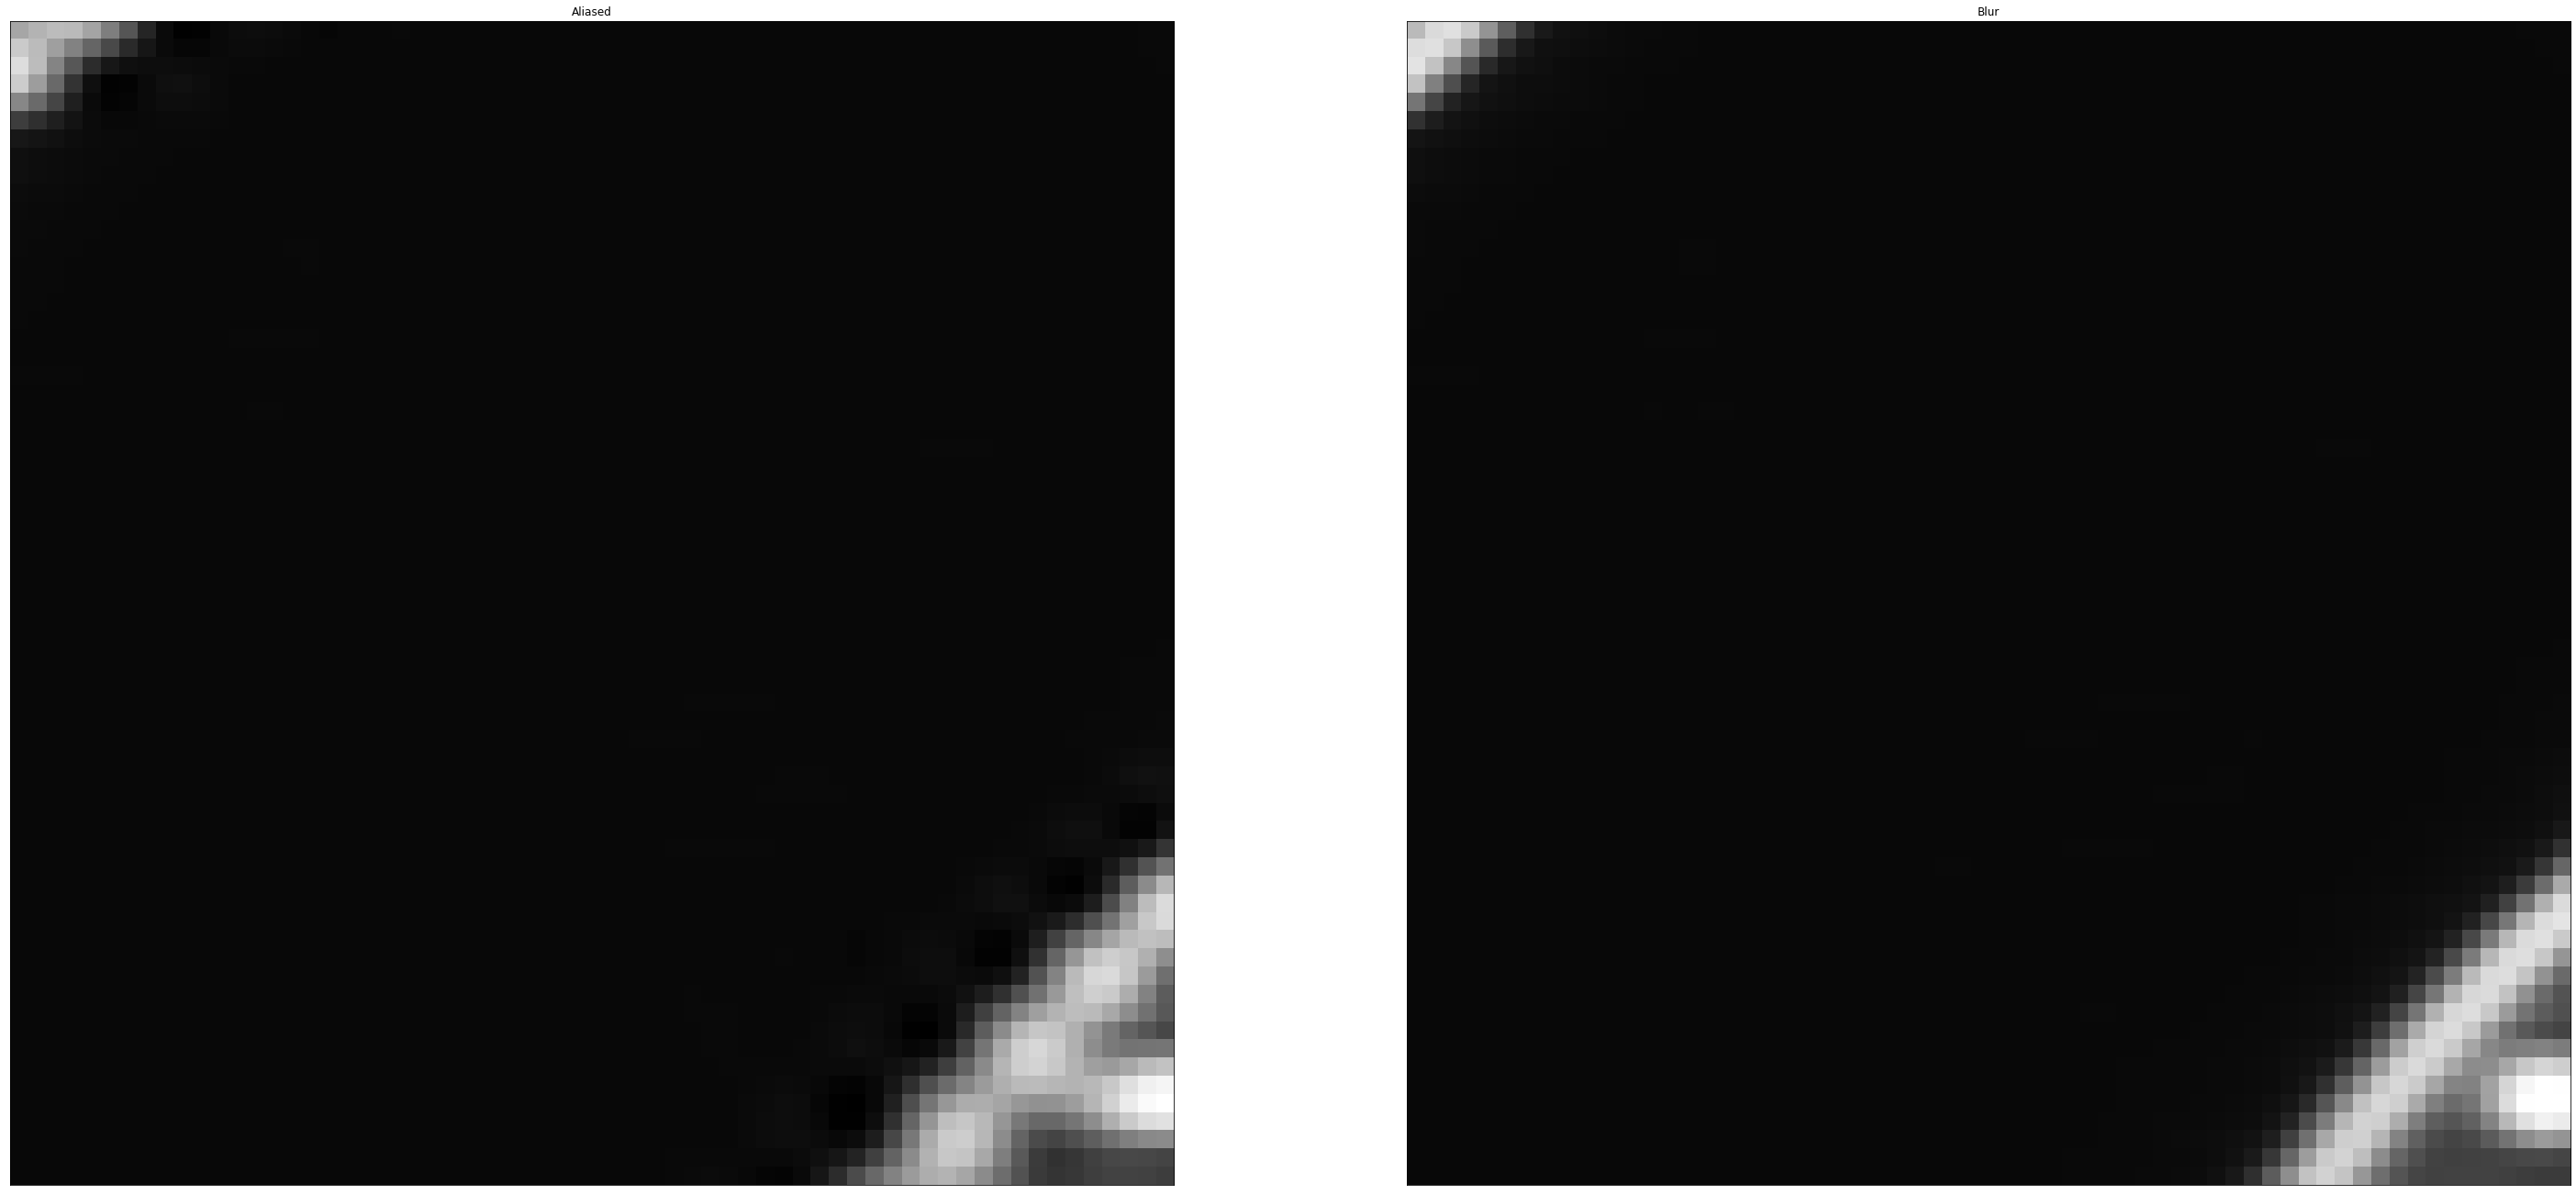

In [50]:
x2, y2 = flip_xy(x, y)
multiplot([x2, y2], ['Aliased', 'Blur'])

# If we do all the steps at once from scratch...

In [52]:
obj = nib.load(fpath)
header = obj.header
img = obj.get_fdata(dtype=np.float32)

k = max(header.get_zooms()) / min(header.get_zooms())
blur_k = k

dxyz = [1, 1, 1/k]
img = resize(img, dxyz, order=3)

min_angle = 0
max_angle = 90
n_rots = 2
angles = list(range(min_angle, max_angle+1, max_angle//n_rots))
imgs_rot = [rotate_vol_2D(img, angle) for angle in angles]
imgs_blur = [blur(img_rot, blur_k, axis=0) for img_rot in imgs_rot]
imgs_alias = [alias(img_blur, k, down_order=1, up_order=3, axis=0) 
              for img_blur in imgs_blur]

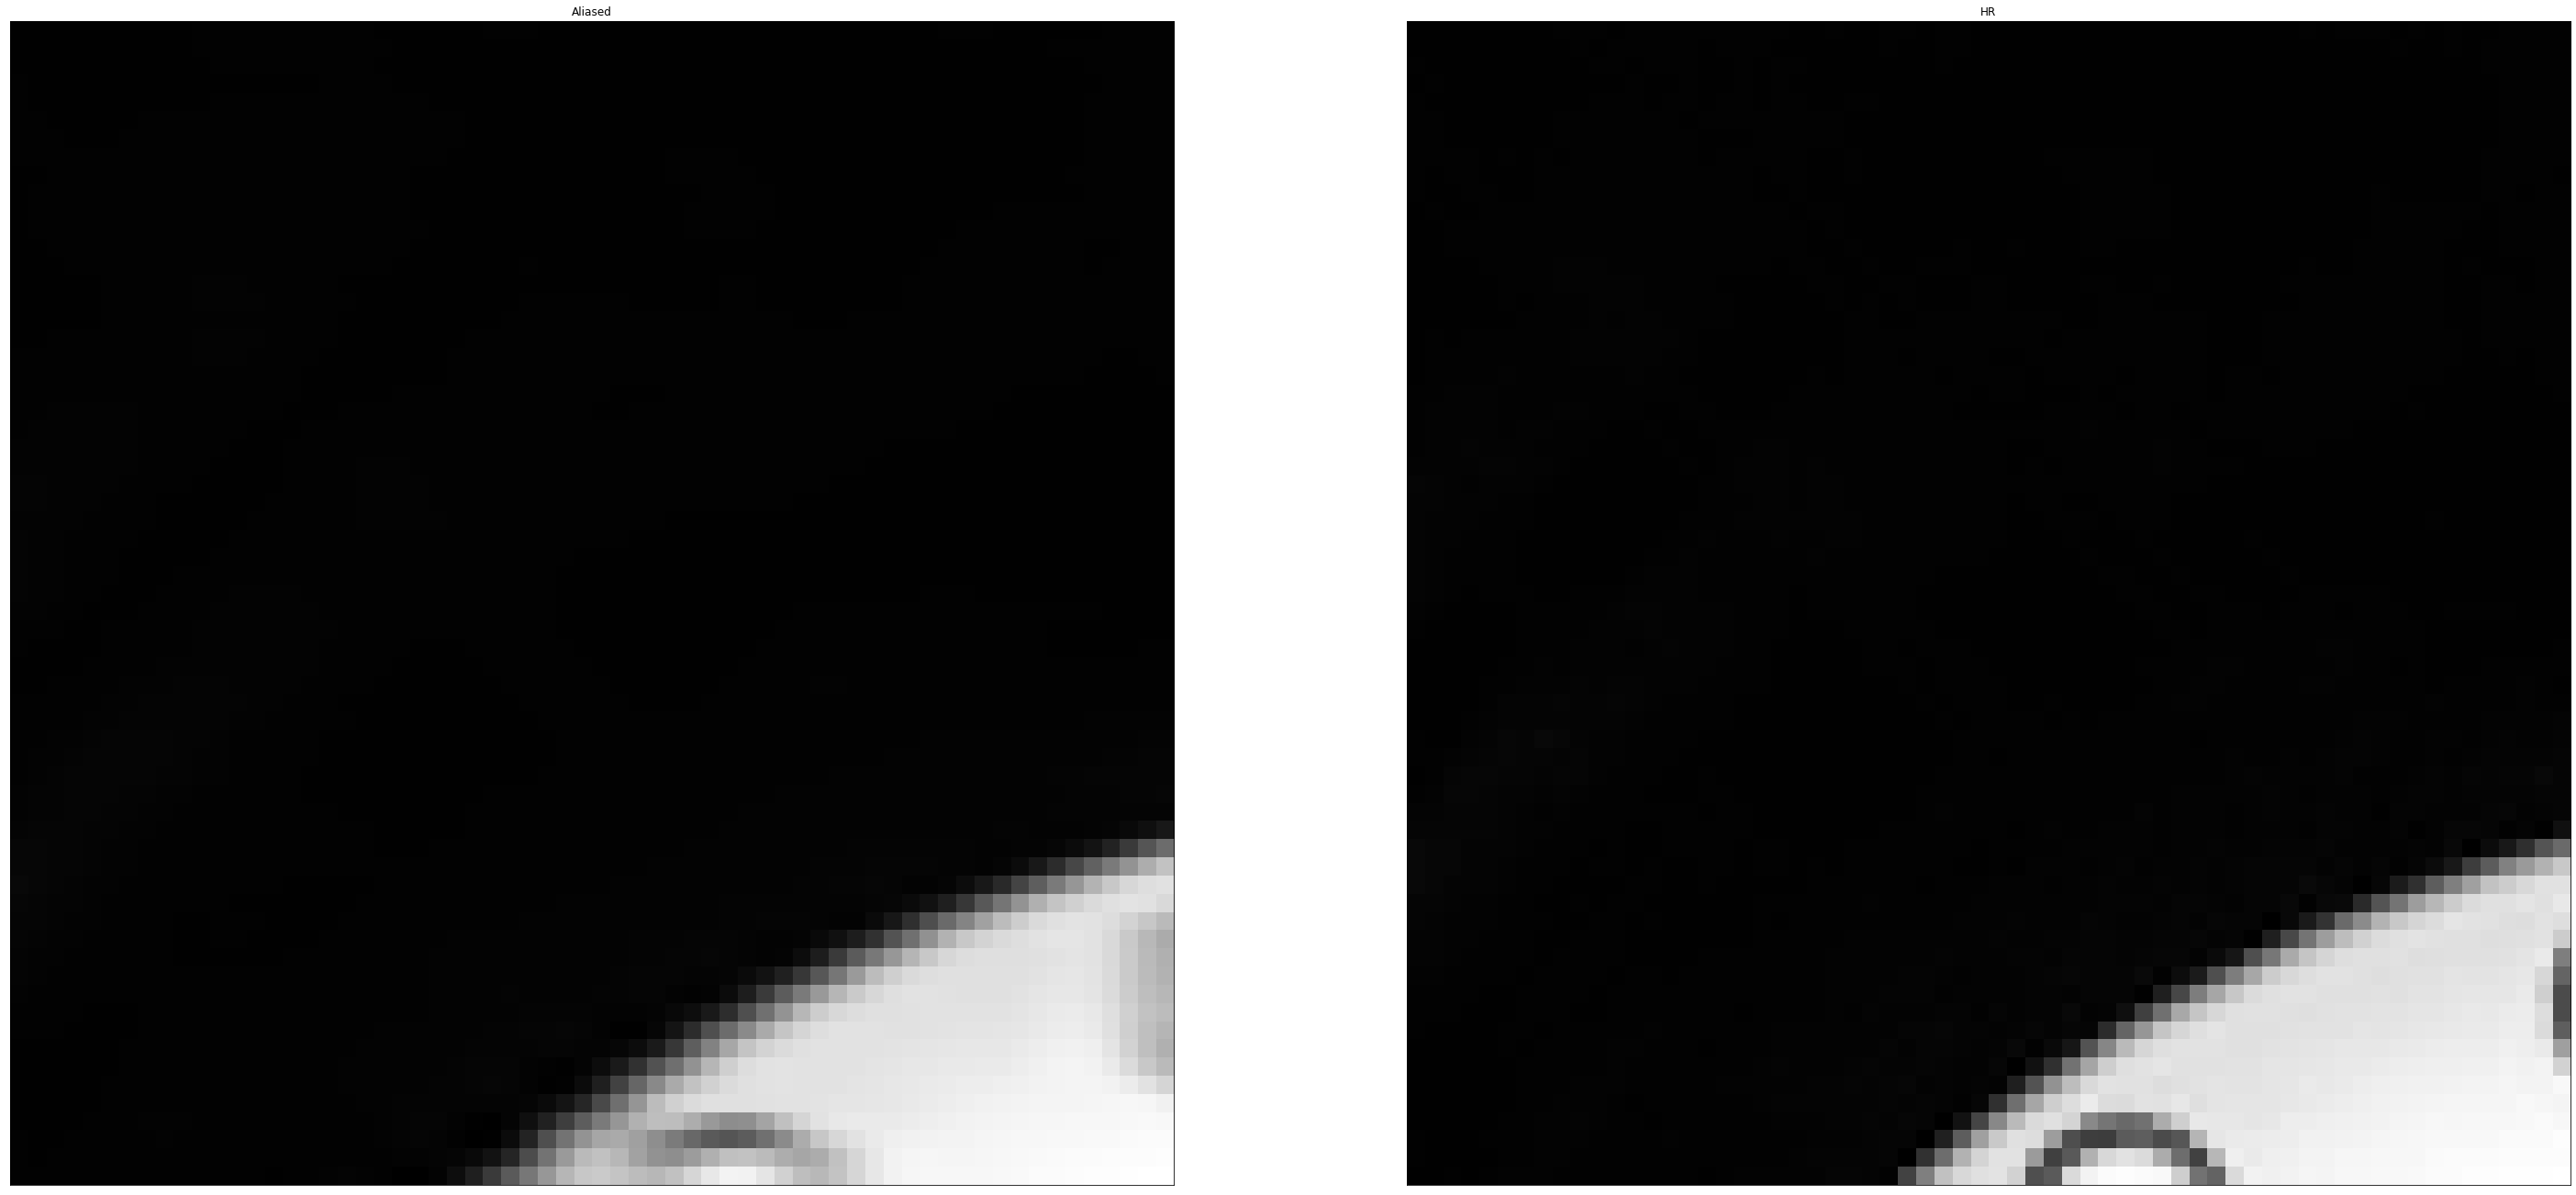

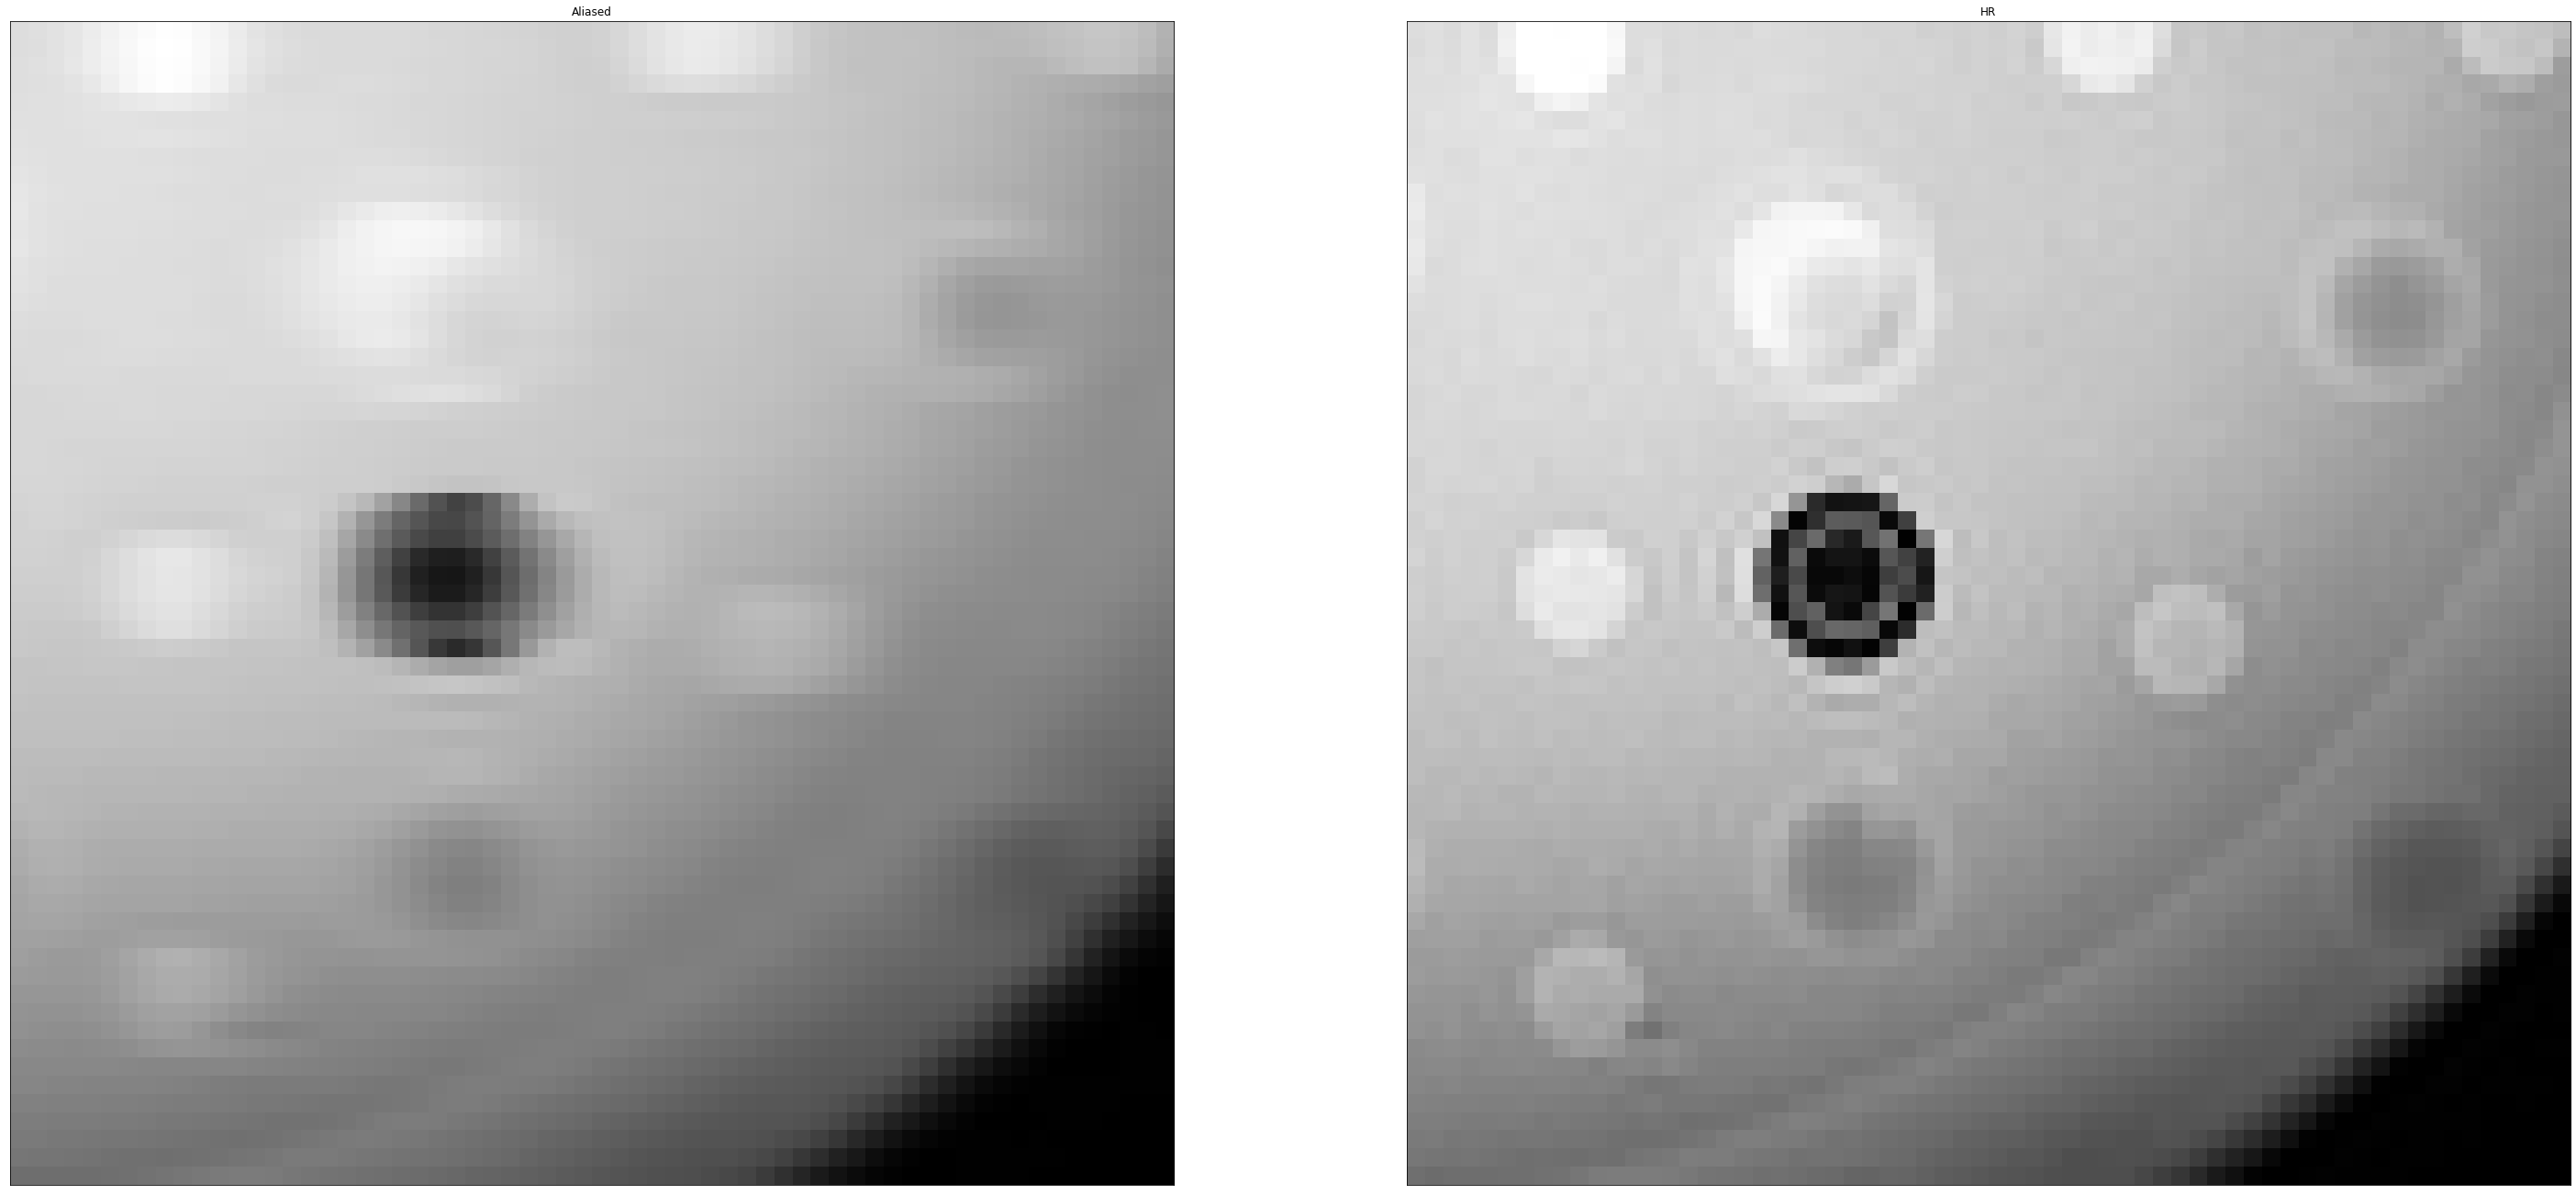

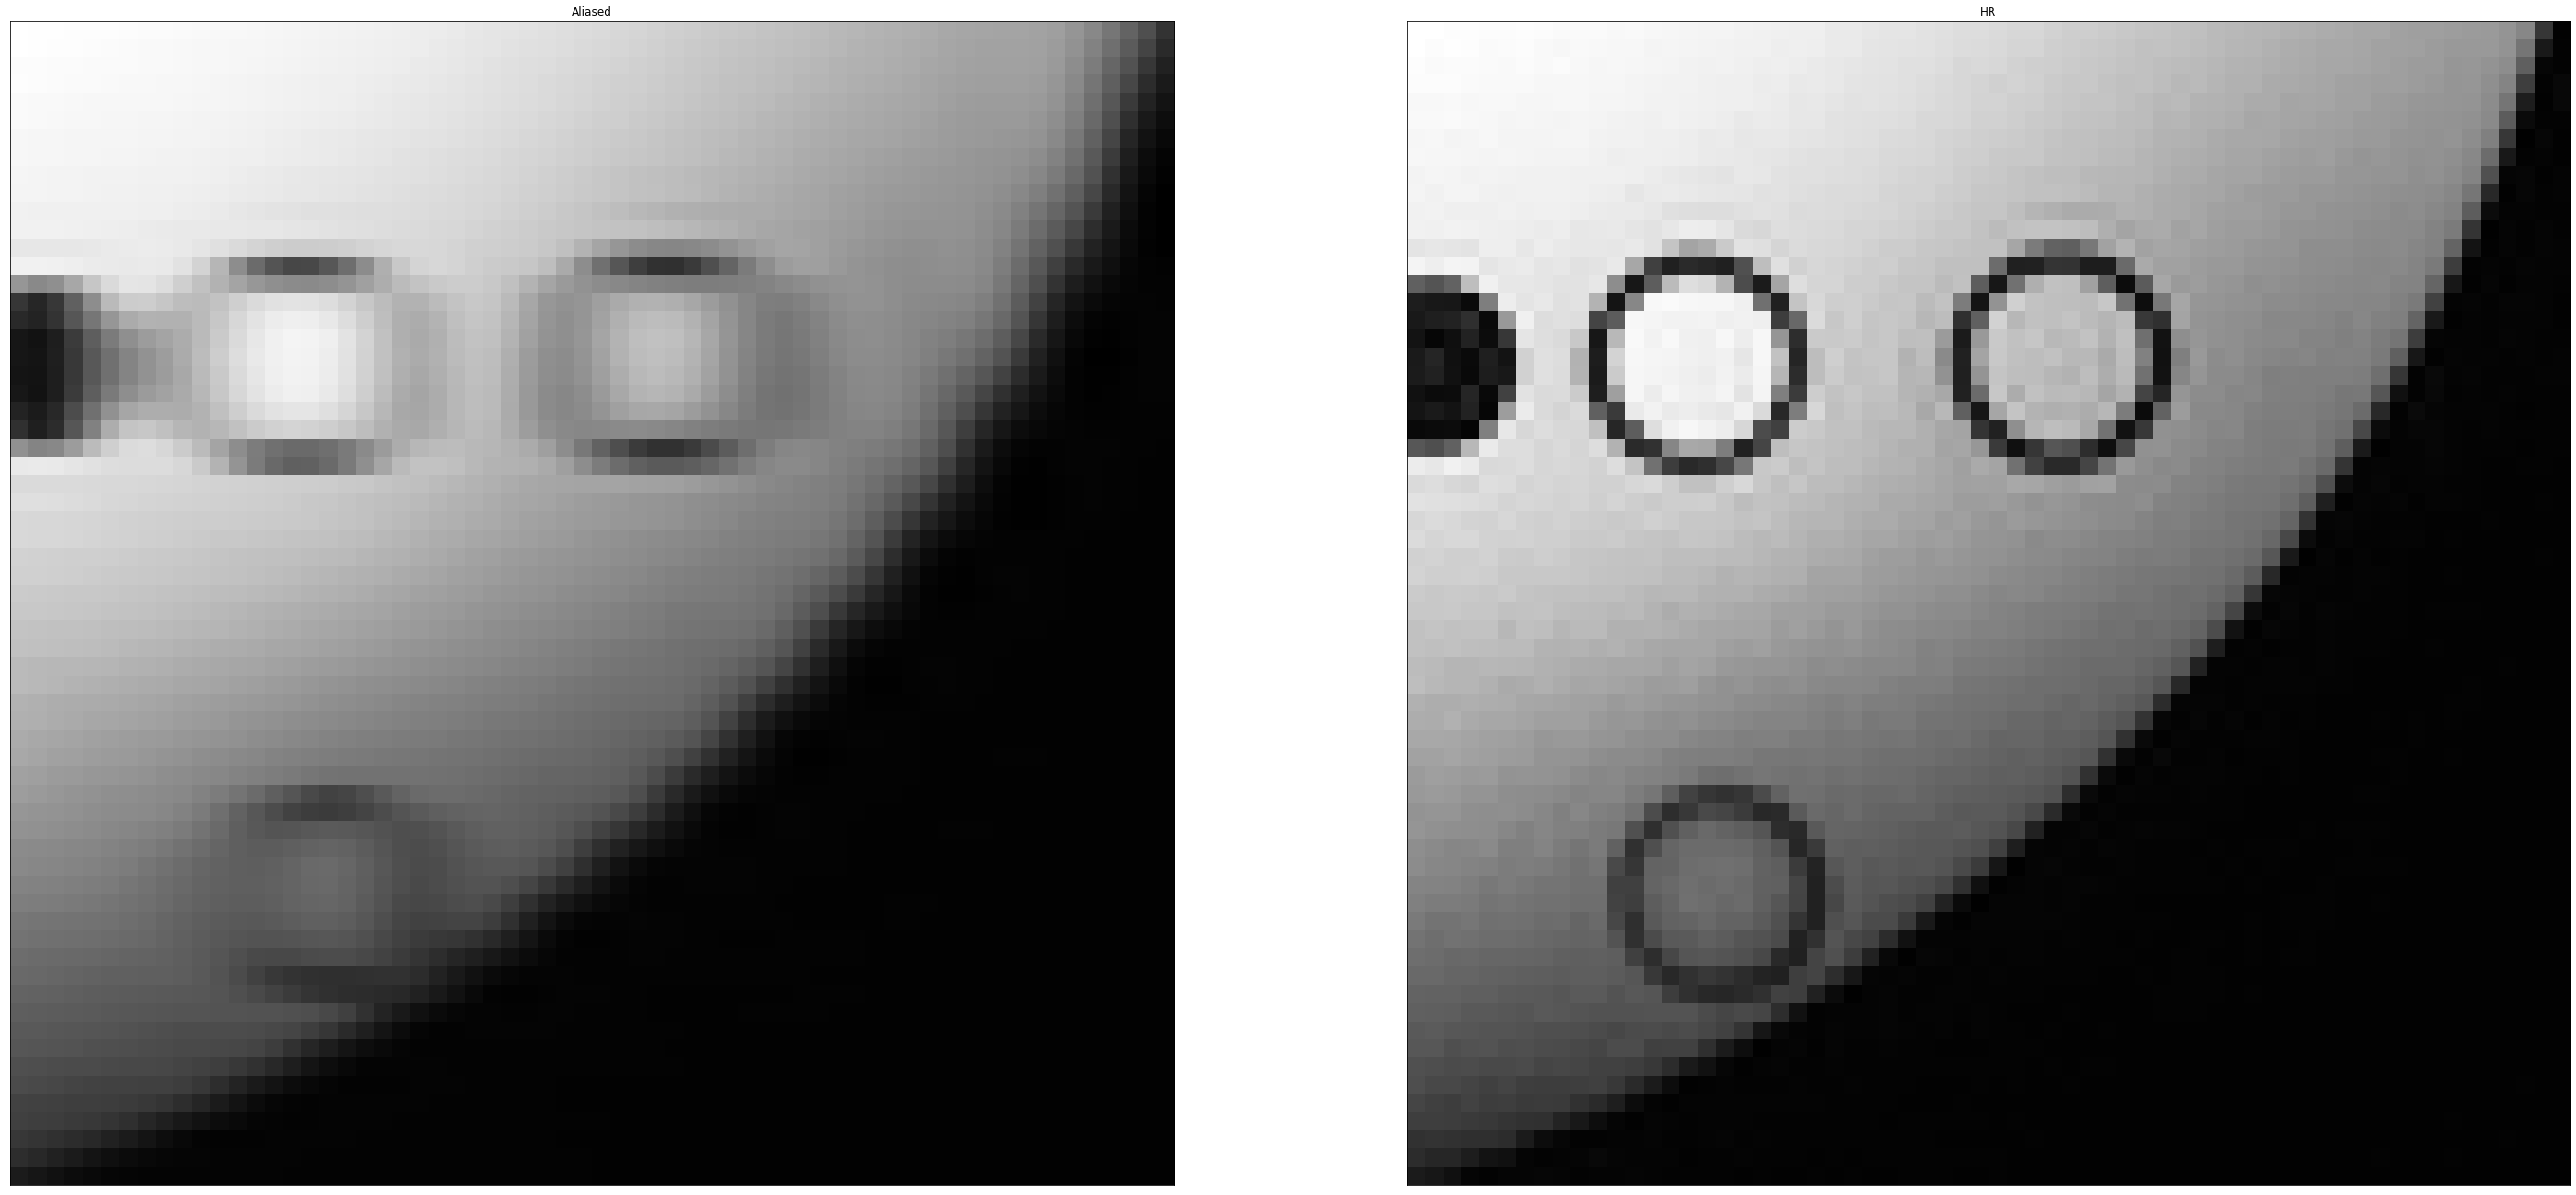

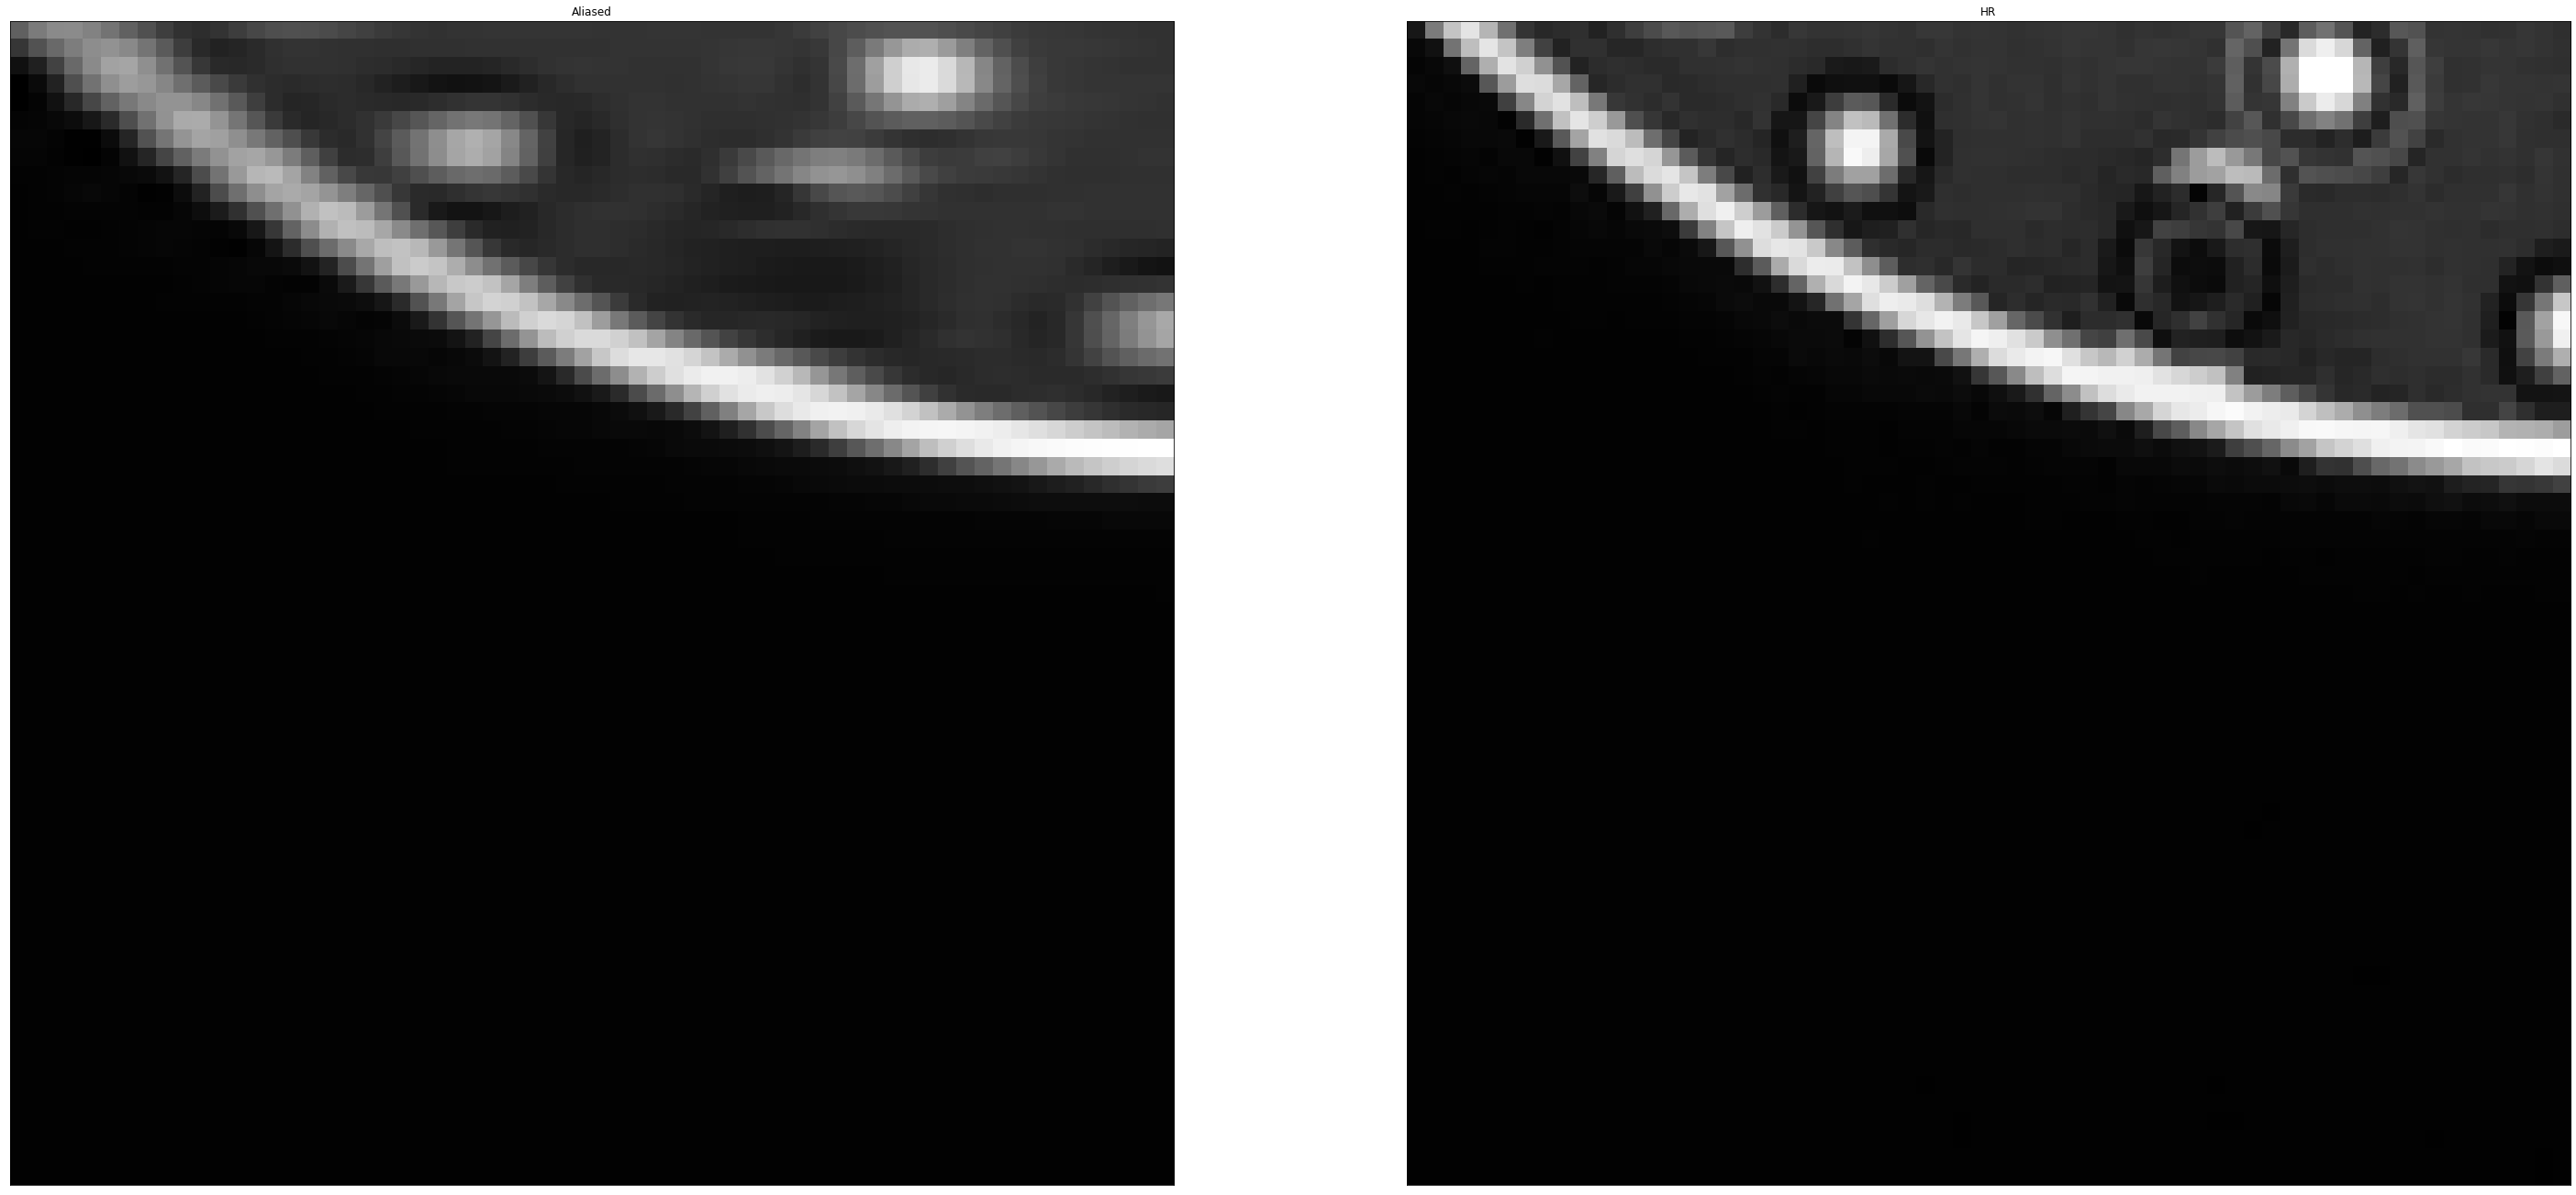

In [54]:
for _ in range(4):
    x, y = get_patch(imgs_rot, imgs_blur, imgs_alias,
                    patch_size=(64, 64, 1),
                    mode='SR')
    x, y = flip_xy(x, y)
    multiplot([x, y], ['Aliased', 'HR'])

In [61]:
9.9 / 2.355

4.203821656050955

In [62]:
fwhm_to_std(fwhm_needed(1, 9.9))

4.182640402853178

# Testing the Train Data Loader

In [64]:
from utils.train_loader import ImageLoader

In [72]:
ds = ImageLoader(
    img_fpath=fpath,
    patch_size=(64, 64, 1),
    n_steps=10,
    n_rots=2,
)

========== PREPROCESSING IMAGE ==========
Interpolating through-plane...
	Elapsed time: 3.8752s

Creating 2 rotations...
	Elapsed time: 0.4900s

Blurring in-plane...
	Elapsed time: 0.3770s

Generating in-plane aliasing artifacts...
	Elapsed time: 12.7594s



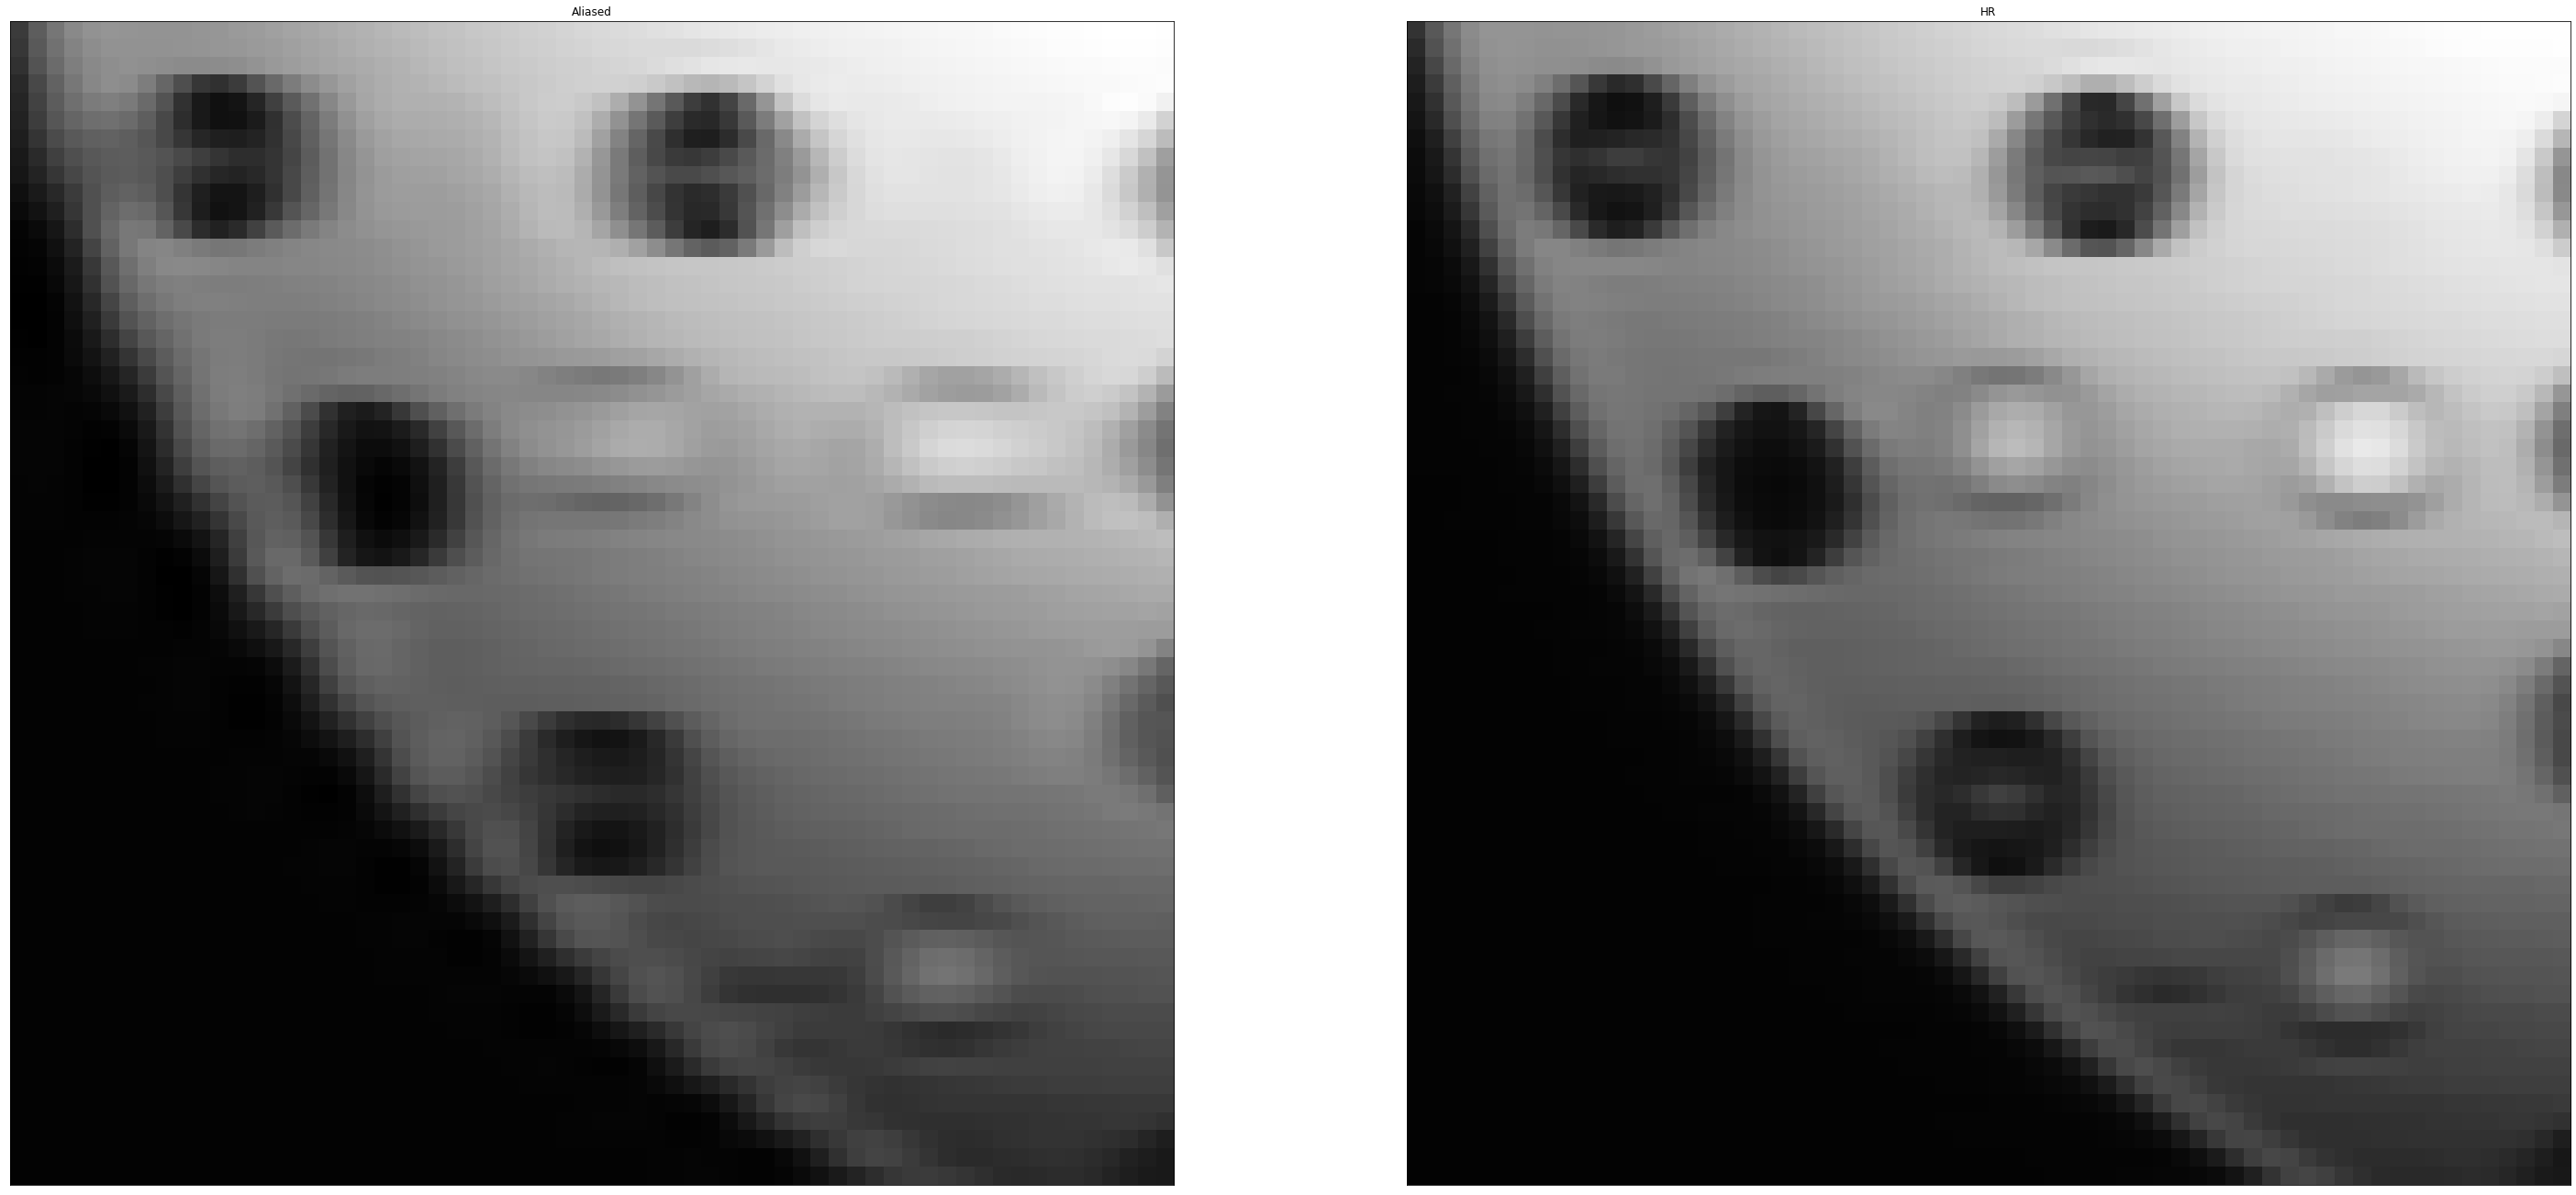

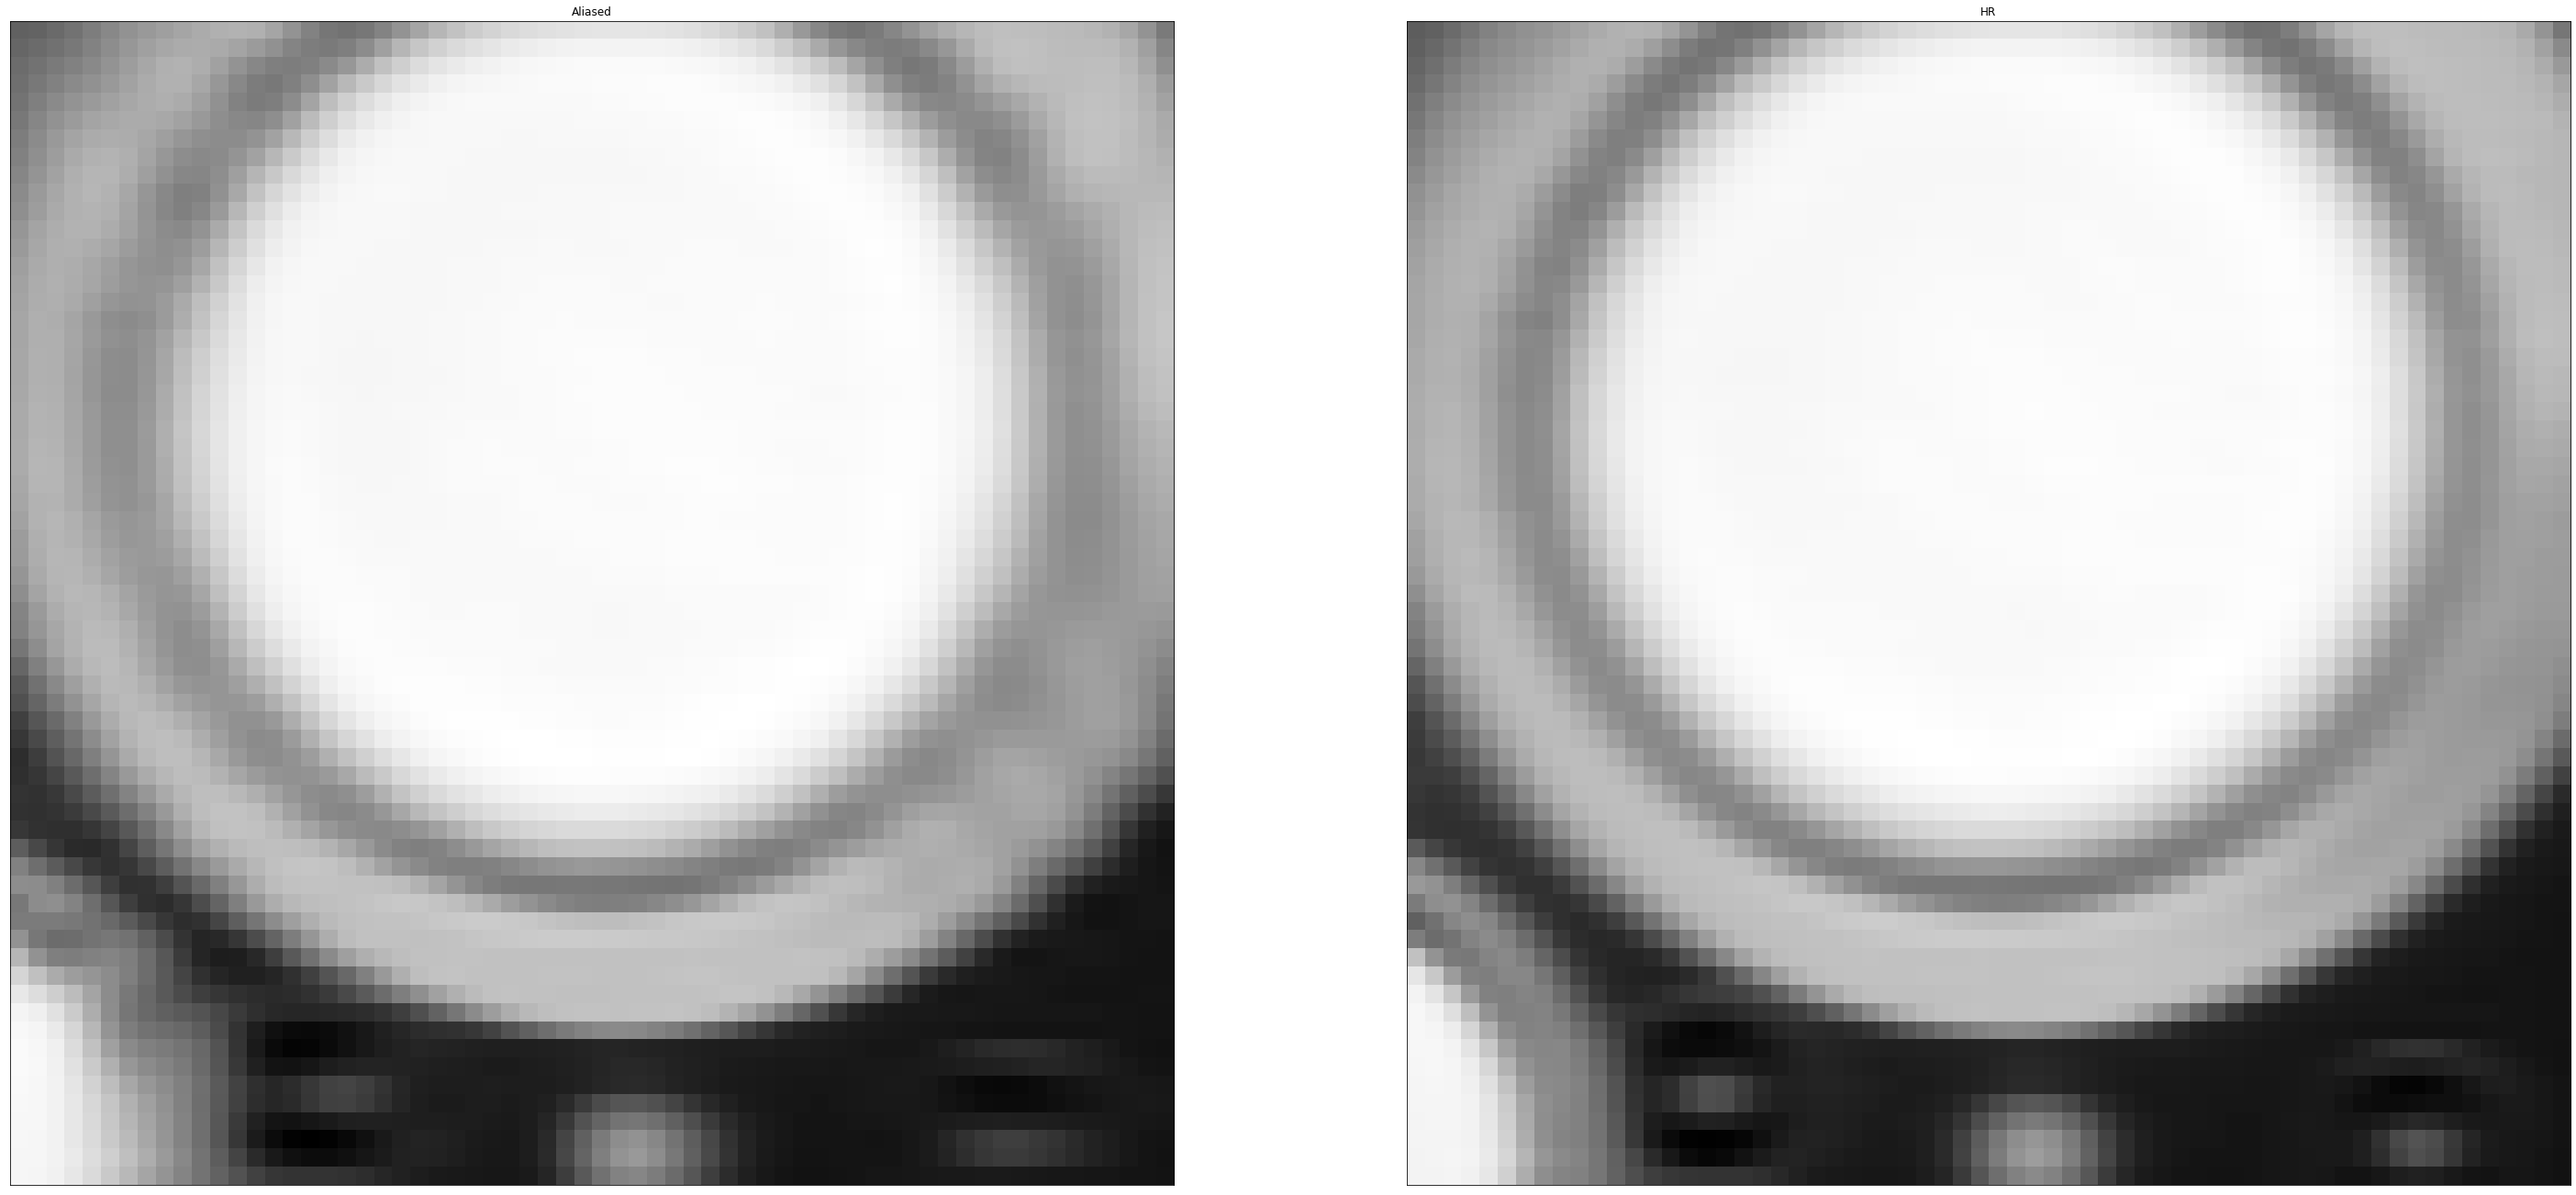

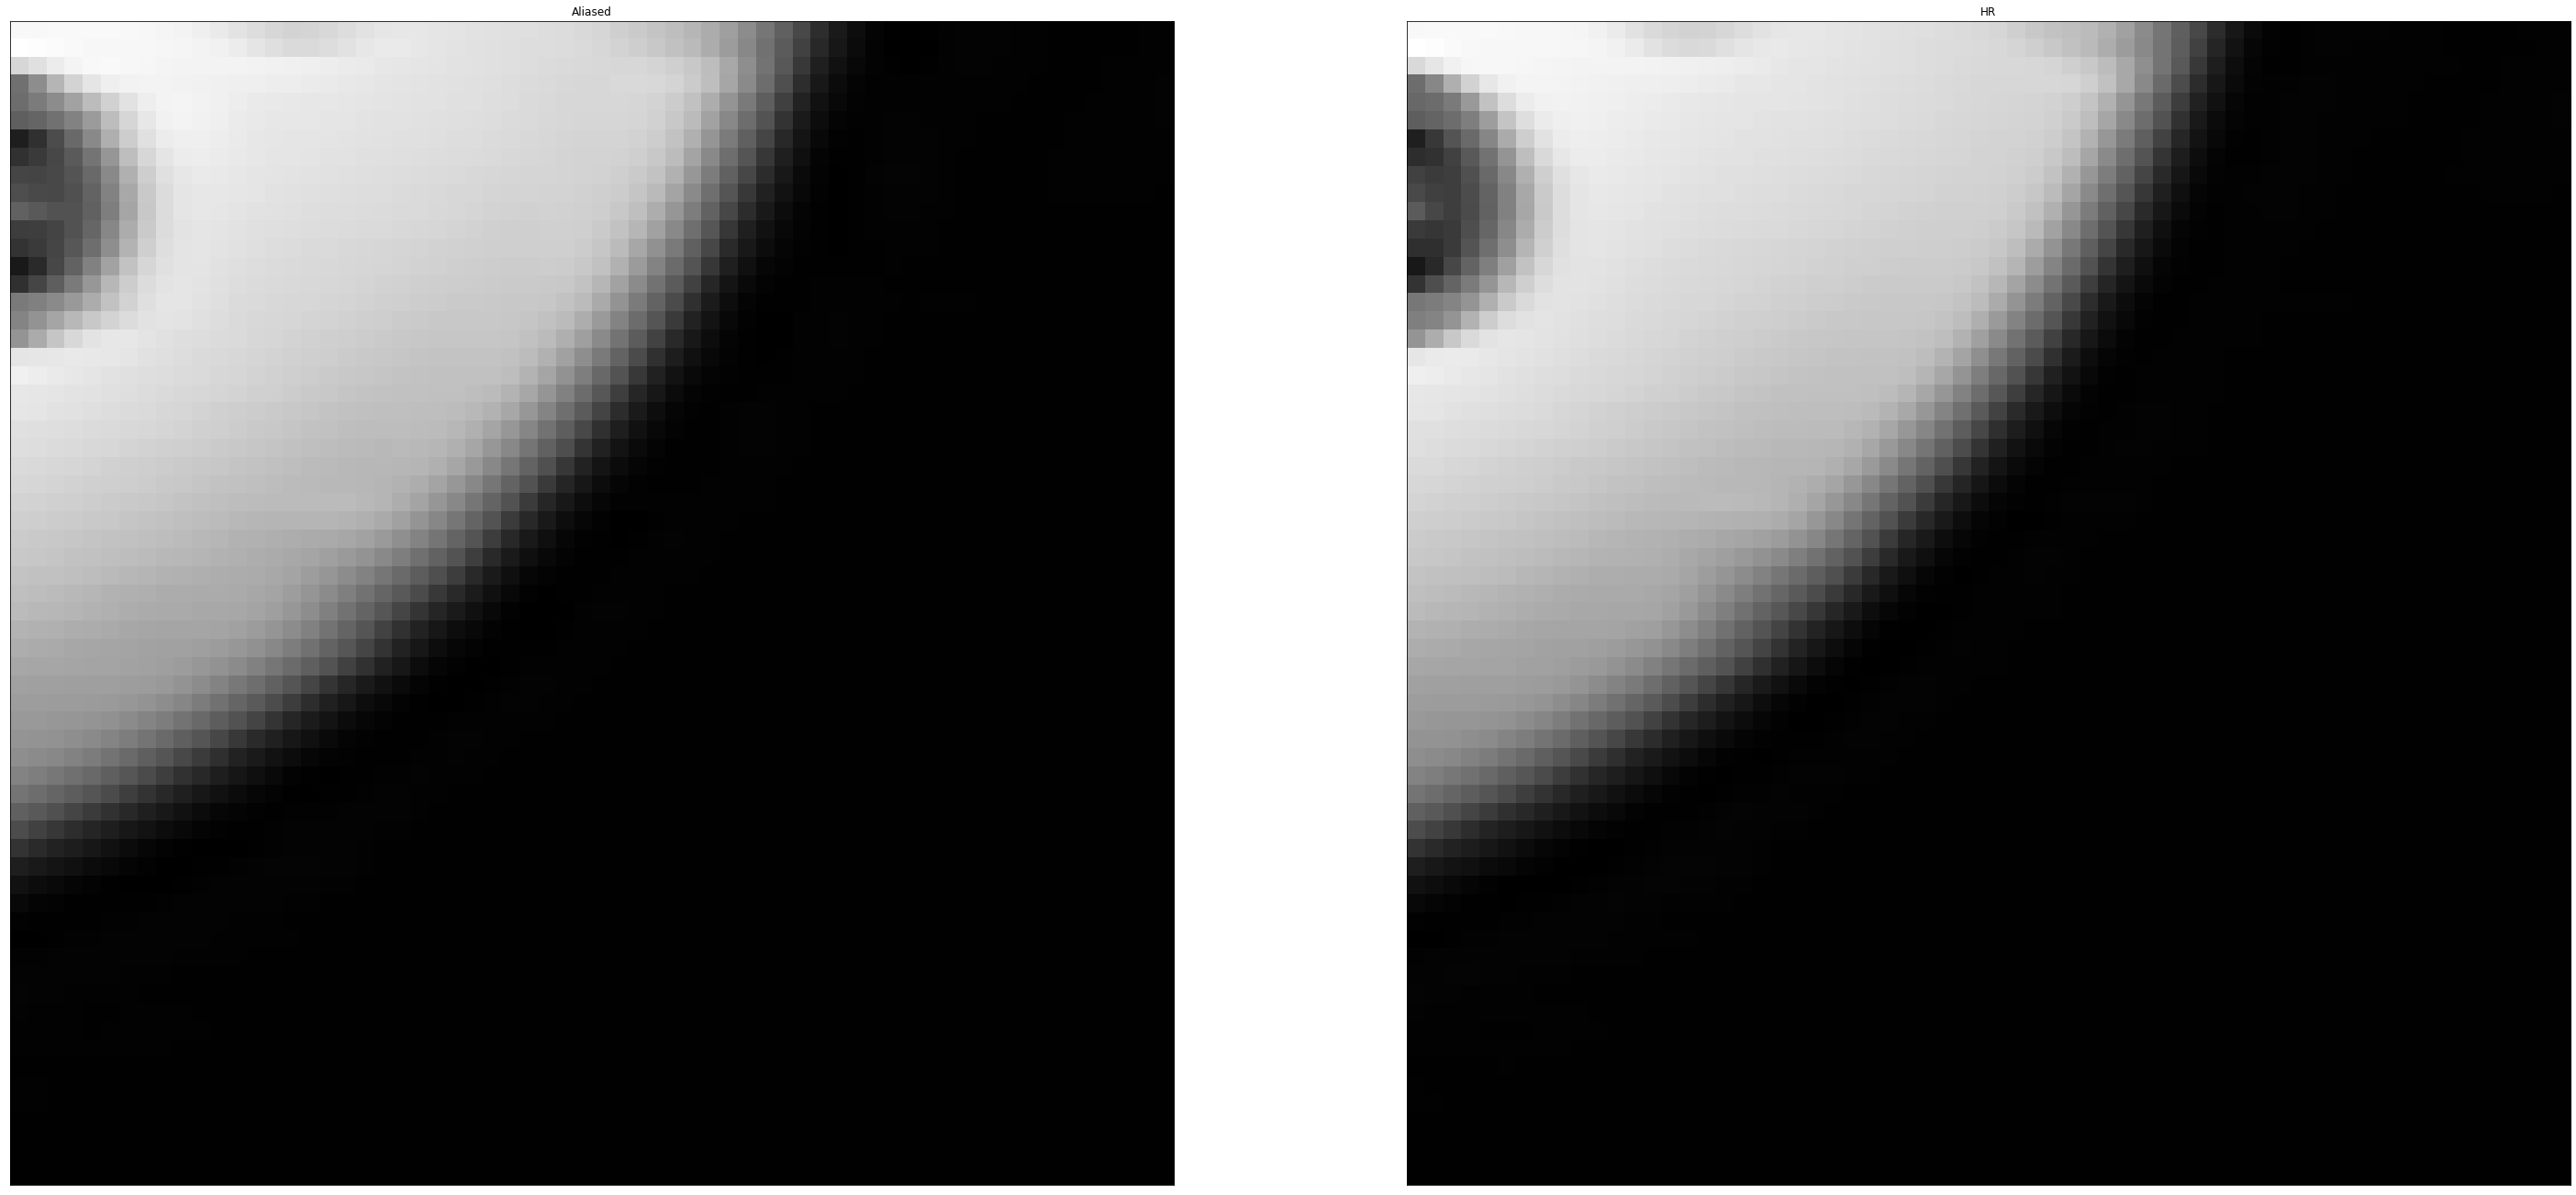

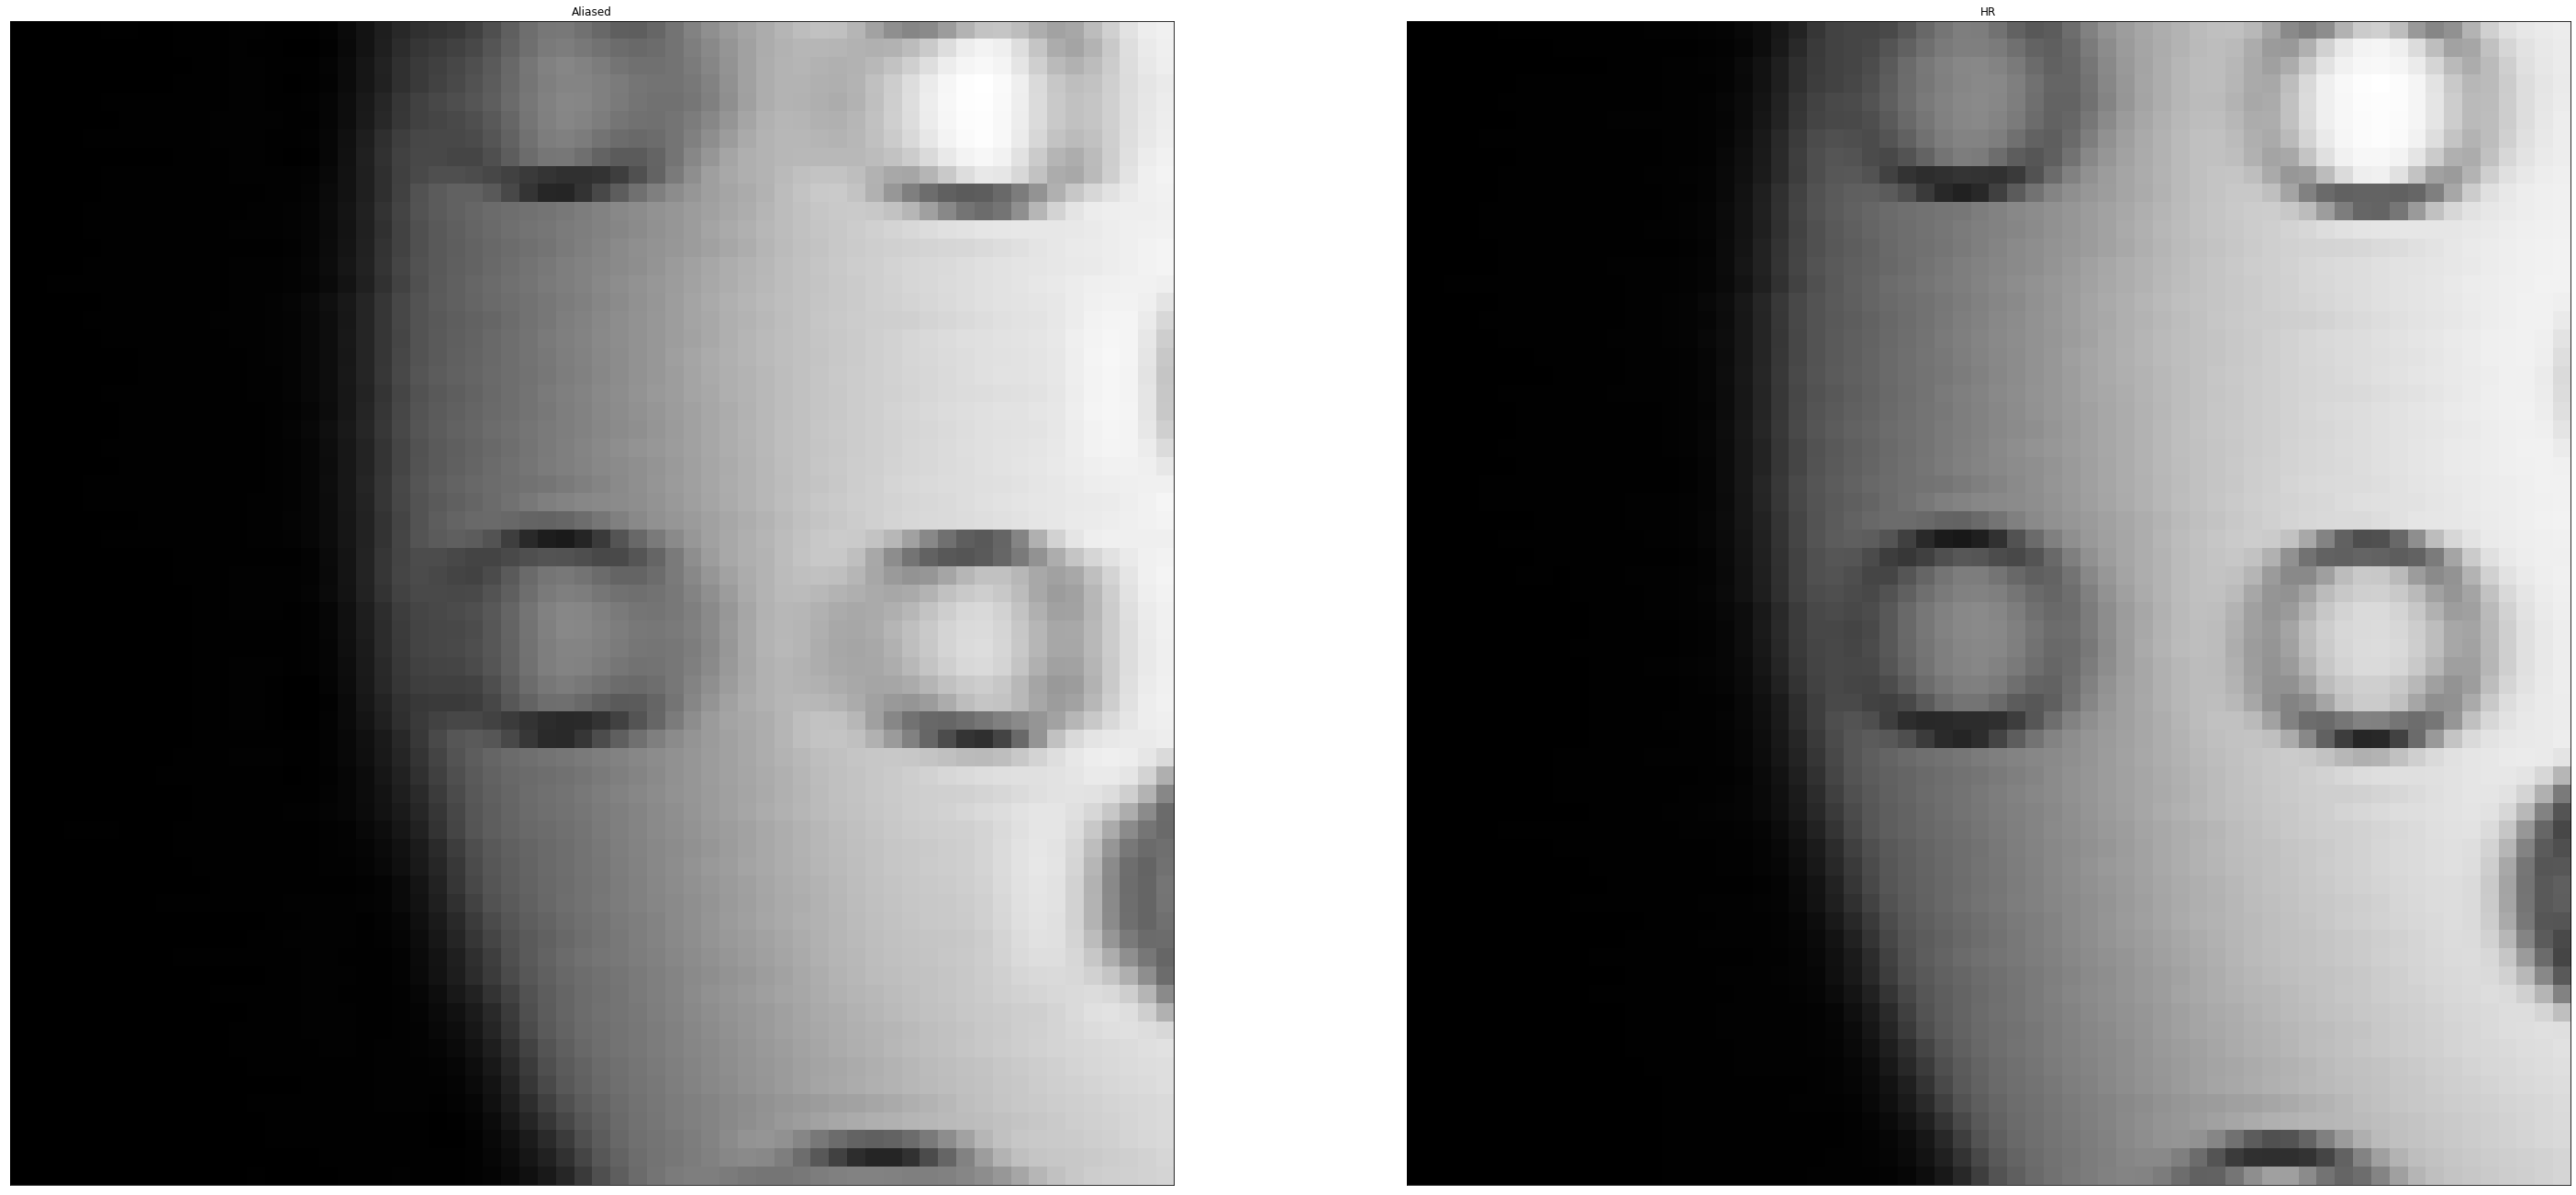

In [80]:
ds.set_mode("AA")
for i in range(4):
    x, y = ds.__getitem__(i)
    multiplot([x, y], ['Aliased', 'HR'])

In [81]:
x.min(), x.mean(), x.max()

(-4.1515036, 827.9765, 2339.119)

In [82]:
y.min(), y.mean(), y.max()

(0.520799, 828.4272, 2331.2747)